## WARNING !
All the questionable decisions i have marked with comment #TODO
to think about them and discuss.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pylab
import cvxpy as cp
from scipy.linalg import eigh
from collections import OrderedDict
import pandas as pd
import pickle
import scipy as sp
import seaborn as sns
import scipy.stats as stats
import random
import argparse
from time import time
import os
#from google.colab import files
from scipy.sparse import coo_matrix
%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(42)

## Parameters of experiment

In [3]:
nodes = 10#int(input(" NODES in the graph : "  )) #number of arms
super_arm_sparsity = 4 #int(input(" number of chosen arms in the super arm is : "  )) #number of chosen arms
rounds = 5000 #int(input(" rounds of observation (decision making) : "  )) # number of rounds of data we create

In [4]:
#change points
change_points = [0, 1000, 2500, 4000]#, 250, 500, 750] 

In [5]:
# Reasonable parameters I have found xi = 5e-08, gamma = 0.99
# Tuning resulted in xi = 1e-09, gamma = 0.97

In [6]:
xi = 1e-06 # larger -> more exploration
s = super_arm_sparsity
gamma = 0.985 # smaller -> more forgetting / more exploration

In [7]:
Delay = 200 #10
skiped = 0
best_lambda = 0.1

In [8]:
start_ts = time()

## Useful functions


### Create graph

In [9]:
# 12 

In [10]:
def create_graph(n):
    # This value is chosen so that resulting density of DAG is 0.15
    prob_of_edge = 0.25 #float(input("* Please enter the probability of having an edge in your random graph:"  ))
    
    G = nx.gnp_random_graph(n=n, p=prob_of_edge, directed=True, seed=6)
    
    # Make the graph directed and acyclic
#     DAG = nx.DiGraph([(u, v, {'weight': np.random.uniform(low=0.9, high=0.95)}) for (u, v) in G.edges() if u < v])
    DAG = nx.DiGraph([(u, v) for (u, v) in G.edges() if u < v])
    print('* Is the graph a DAG? ', nx.is_directed_acyclic_graph(DAG))
    
    # building the adjacency numpy matrix of the graph
    edge_list = list(DAG.edges())
    number_of_edges = len(edge_list)
    
    w = np.zeros((n, n)) # the numpy adjacency matrix with all edge weights equal to 1    
    for edge in edge_list:
        w[edge[0], edge[1]] = np.random.uniform(low=0.4, high=0.7)
    
    if np.count_nonzero(w) == number_of_edges:
        print('The adjacency matrix is correctly set as a randomly picked DAG!')
        
    temp1 = np.eye(w.shape[0]) - w
    C = np.linalg.inv(temp1)
    C_axis_0_sum = np.sum(C, axis=0)
    
    print('the elements of the vector C are:  ', np.transpose(C_axis_0_sum))
    return w , C

In [11]:
def change_point_index(time_point):
    """Return index of last happened change point by the time `time_point`"""
    global change_points
    global rounds
    assert time_point >= change_points[0], f"Time point smaller than first change point {change_points[0]}"
    assert time_point <= rounds, f"Time point larger than total num of rounds {rounds}"
    
    for ind, ch_p in enumerate(change_points):
        if time_point < ch_p:
            return ind - 1
    else:
        return len(change_points) - 1

### Rewards

In [12]:
	#       B
# def instantaneous_Gaussian_rewards(maxx, minn):
#     mean_b_gt_Gauss = np.zeros((len(change_points), nodes, 1))
#     B = np.zeros((nodes, rounds))
#     variance = 0.2#float(input(" The variance for all reward distributions is : "  ))
#     for i in range(0, len(change_points)):
#         mean_b_gt_Gauss[i, :, :] = np.random.uniform(low=minn, high=maxx, size=nodes) #uniformally at random the means
#         for j in range(rounds):
#             if j == change_points[i]:
# #                 print(j)
#                 if j == change_points[len(change_points)-1]:
                    
#                     for k in range(nodes):
#                         B[k,j:rounds] = variance * np.random.randn(1,rounds-j) + mean_b_gt_Gauss[i,k] # create the samples
#                 else:
# #                     print(j)
# #                     print(change_points[i+1])
# #                     print(B[1,j:change_points[i+1]].shape)
#                     for k in range(nodes):
#                         B[k,j:change_points[i+1]] = variance * np.random.randn(1,change_points[i+1]-j) + mean_b_gt_Gauss[i,k] # create the samples
# #     for i in range(1,nodes):
# #         temporary_1 = variance * np.random.randn(1,rounds) + mean_b_gt_Gauss[i]
# #         B = np.concatenate((B,temporary_1),axis=0)
#     return B, mean_b_gt_Gauss;

# def instantaneous_Gaussian_rewards_with_gap(maxx, minn):
#     mean_b_gt_Gauss = np.zeros((len(change_points), nodes, 1))
#     B = np.zeros((nodes, rounds))
    
#     variance = 0.1#float(input(" The variance for all reward distributions is : "  ))
    
#     for i in range(0, len(change_points)):
#         # For s nodes chose mean values higher than for others.
#         high_reward_nodes = np.random.choice(a=range(nodes), size=s, replace=False)
        
#         high_reward_nodes = [(ind + i*s) % nodes for ind in range(s)]
#         print(high_reward_nodes)
#         low_reward_nodes = np.array([i for i in range(nodes) if i not in high_reward_nodes])
        
#         interval_size = maxx - minn
#         # Chose means uniformly at random
#         mean_b_gt_Gauss[i, high_reward_nodes, :] = np.random.uniform(
#             low=maxx - interval_size / 4, high=maxx, size=(len(high_reward_nodes), 1)
#         )
        
#         mean_b_gt_Gauss[i, low_reward_nodes, :] = np.random.uniform(
#             low=minn, high=minn + interval_size / 4, size=(len(low_reward_nodes), 1)
#         ) 
        
        
#     for j in range(rounds):
#         ch_p_ind = change_point_index(j)
#         for k in range(nodes):
#             B[k, j] = variance * np.random.randn(1) + mean_b_gt_Gauss[ch_p_ind, k]
    
#     return B, mean_b_gt_Gauss;

def instantaneous_Bernoulli_rewards(high_interval, low_interval):
    mean_b_gt_Bern = np.zeros((len(change_points), nodes, 1))
    B = np.zeros((nodes, rounds))
    

    for i in range(0, len(change_points)):
        # For s nodes chose mean values higher than for others.
        high_reward_nodes = [(ind + i*s) % nodes for ind in range(s)]
        
        print(high_reward_nodes)
        low_reward_nodes = np.array([i for i in range(nodes) if i not in high_reward_nodes])
        
        # Chose means uniformly at random
        mean_b_gt_Bern[i, high_reward_nodes, :] = np.random.uniform(
            low=high_interval[0], high=high_interval[1], size=(len(high_reward_nodes), 1)
        ) 
        
        
        mean_b_gt_Bern[i, low_reward_nodes, :] = np.random.uniform(
            low=low_interval[0], high=low_interval[1], size=(len(low_reward_nodes), 1)
        )
        
        # Make sure one of the base arms almost reaches high and low ends.
        mean_b_gt_Bern[
            i, np.random.choice(high_reward_nodes), :
        ] = high_interval[1] - np.random.normal(scale=(high_interval[1] - high_interval[0])/20)
        
        mean_b_gt_Bern[
            i, np.random.choice(low_reward_nodes), :
        ] = low_interval[0] + np.random.normal(scale=(low_interval[1] - low_interval[0])/20)
        
    for j in range(rounds):
        ch_p_ind = change_point_index(j)
        for k in range(nodes):
            B[k, j] = np.random.binomial(n=1, p=mean_b_gt_Bern[ch_p_ind, k])
    
    return B, mean_b_gt_Bern;
	
#   function to create the random action X

def rand_binary_array(number_of_chosen_arms=super_arm_sparsity, n=nodes): 
    
    arr = np.zeros((n,1))
    arr[:(number_of_chosen_arms)] = 1
    np.random.shuffle(arr)
    return arr

def create_random_action(number_of_chosen_arms=super_arm_sparsity, n=rounds):

    X = rand_binary_array(number_of_chosen_arms=number_of_chosen_arms)
    for i in range(n-1):
        temp2 = rand_binary_array(number_of_chosen_arms=number_of_chosen_arms)
        X = np.concatenate((X,temp2),axis=1)
    return X
	
def f_measure_func(x, xgt): #Not read yet
    
    x=np.where(x!=0,1,0)
    xgt=np.where(xgt!=0,1,0)
    true_pos = np.count_nonzero(np.multiply(x,xgt))
    fals_pos = np.count_nonzero(np.where((x-xgt)>0,1,0))
    fals_neg = np.count_nonzero(np.where((xgt-x)>0,1,0))
    true_neg = nodes**2 - true_pos - fals_neg - fals_pos
    f_measure=true_pos/(true_pos+0.5*(fals_neg+fals_pos))
    
    return f_measure

### Graph learning

In [13]:
#................................SEM + L1 graph learning
def graph_learning(
    current_time, A_gt, observ, perturb, nodes = nodes, skiped=skiped, best_lambda=best_lambda, Delay=Delay
):

    if skiped == 0: 
        lambda_params = np.array([0.00001,0.0001,0.001,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10\
                          ,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9\
                          ,10,20,30,40,50,60,70,80,90,100,1000,10000,100000,1000000])
    elif skiped == 1:
        lambda_params = np.asarray([best_lambda])
    
    # If no current time < Delay then agent has no observations yet. 
    # Must be > 0 because otherwise indexing works wrong, starts from the end.
    time_up_to_delay = max(0, current_time - Delay)
    observ = observ[:,:time_up_to_delay] #!
    perturb = perturb[:,:time_up_to_delay] #!

    error_SEM_L1 = np.ones([lambda_params.shape[0],1])*10000000000000000000
    for k in range (lambda_params.shape[0]):
        A        = cp.Variable((nodes,nodes))
        #TODO When no observations - just minimize the regularizer term.
        cost     = (
            cp.sum_squares(observ - (A @ observ) - perturb) + lambda_params[k] * cp.atoms.norm1(A) 
            if time_up_to_delay > 0 
            else lambda_params[k]*cp.atoms.norm1(A) 
        )
        obj      = cp.Minimize(cost)
        constr   = [cp.diag(A) == 0 , A[:,:] >= 0]
        prob     = cp.Problem(obj, constr)
        opt_val  = prob.solve()
        solution_L1Norm = A.value

        error_SEM_L1[k] = np.sum(np.power((A_gt - A.value),2)) / (nodes*nodes) 
    
        if error_SEM_L1[k] <= np.amin(error_SEM_L1):
            The_final_solution_SEM_L1 = A.value
            
            # Enforce constraints post-hoc (numerical solver does not enforce them)
#             The_final_solution_SEM_L1 = np.triu(The_final_solution_SEM_L1, k=1)
#             The_final_solution_SEM_L1 = np.maximum(
#                 The_final_solution_SEM_L1, np.zeros(The_final_solution_SEM_L1.shape)
#             )
            
            
            solution_threshold_SEM_L1 = np.where(np.absolute(A.value)<\
                                             (0.1*np.amax(np.absolute(A.value))),0,A.value)
#             solution_Boolean_SEM_L1 = np.where(solution_threshold_SEM_L1==0,0,1)
            best_lambda = lambda_params[k]
#             optvalue1 = opt_val
    
    
    
    f_measure = f_measure_func(solution_threshold_SEM_L1, A_gt)
#     print('the f-measure is : ', f_measure)
    
    # sanity checks that estimated graph follows constraints
#     assert np.allclose(The_final_solution_SEM_L1, np.triu(The_final_solution_SEM_L1, k = 1)), (
#         "Solution is not upper triangular with zero diagonal"
#     )
    
#     assert np.all(The_final_solution_SEM_L1 >= -1e-12), (
#         "Solution is not non-negative "
#     )
    
    return The_final_solution_SEM_L1, f_measure, best_lambda, np.amin(error_SEM_L1)

In [14]:

# Finding solution new function

def Best_action_func_new(A, b, s = super_arm_sparsity):
#A --> Estimated A or w_gt
#b --> UCB or mean_b_gt[i,:]
    
    temp_inv        = np.linalg.inv(np.eye(nodes) - A)
    b_diag          = np.diagflat(b) 
    C               = np.matmul(temp_inv, b_diag)
#     print("C.shape is", C.shape)
    C_axis_0_sum    = np.sum(C,axis=0) 
#     print("C_axis_0_sum.shape is", C_axis_0_sum.shape)
    ind             = np.argsort(C_axis_0_sum,axis=0)[-s:]
    x               = np.zeros((nodes,1))
    for i in range(ind.shape[0]):
        x[ind[i],0] = 1
        
    if (b == b[0]).all():
#             print(f'All UCBs are same, taking random action')
            np.random.shuffle(x)
    
    return x


### UCB func


In [15]:

# UCB  function as part of decision making strategy

# def UCB_func(t, x, T, b_bar, b_hat, b):
def UCB_func(t, x, num_plays_state, inst_reward, xi, s, gamma, Delay):
    
    emp_avg_reward_state_builtin = np.zeros((num_plays_state.shape[0], 1))
    UCB_state_builtin = np.ones((num_plays_state.shape[0], 1))
    
    m_t_gamma = sum([gamma ** (t - tau) for tau in range(1, t + 1)])
    
    delayed_discounted_counts_state = np.zeros(num_plays_state.shape[0])
    for k in range(num_plays_state.shape[0]):
        for j in range(t - Delay):
            delayed_discounted_counts_state[k] += num_plays_state[k,:,j]*(gamma**(t-j))


    emp_avg_reward_state_temp = np.zeros(num_plays_state.shape[0])
    for k in range(num_plays_state.shape[0]):
        for j in range(t - Delay):
            emp_avg_reward_state_temp[k] = emp_avg_reward_state_temp[k] + inst_reward[k,j]*num_plays_state[k,:,j]*(gamma**(t-j))

    array_indices_of_chosen_base_arms = np.where(x!=0)
    for i in range(array_indices_of_chosen_base_arms[0].shape[0]):
        j = array_indices_of_chosen_base_arms[0][i]
        
        if delayed_discounted_counts_state[j] != 0 and t >= Delay:
            emp_avg_reward_state_builtin[j,0] = emp_avg_reward_state_temp[j] / (delayed_discounted_counts_state[j])
            
            inside_sqrt = (xi * s * np.log(m_t_gamma)) / (delayed_discounted_counts_state[j]) 
            if inside_sqrt < 0:
                raise ValueError('UCB calculation produced nan value, because inside sqrt is ', inside_sqrt)

            UCB_state_temp = emp_avg_reward_state_builtin[j, 0] + np.sqrt(inside_sqrt) # UCB calculations for the chosen arms
            UCB_state_builtin[j, 0] = UCB_state_temp
            # print((xi *s*np.log(t+1)) / (delayed_discounted_counts_state[j]))
        else:
            print("The given base arm is not pulled yet")
#             print("Its UCB is:", UCB_state_builtin[j,0])
#             print(delayed_discounted_counts_state[j])
    
    array_indices_of_not_chosen_base_arms = np.where(x==0)
    for i in range(array_indices_of_not_chosen_base_arms[0].shape[0]):
        k = array_indices_of_not_chosen_base_arms[0][i]
        
        if delayed_discounted_counts_state[k] != 0 and t >= Delay:
            #TODO Added this line, why did it work without it?
            # Without this line for all not-chosen arms had empirical reward zero
            emp_avg_reward_state_builtin[k,0] = emp_avg_reward_state_temp[k] / (delayed_discounted_counts_state[k])
            
            inside_sqrt = (xi * s * np.log(m_t_gamma)) / (delayed_discounted_counts_state[k]) 
            if inside_sqrt < 0:
                raise ValueError('UCB calculation produced nan value, because inside sqrt is ', inside_sqrt)
            UCB_state_temp = emp_avg_reward_state_builtin[k,0] + np.sqrt(inside_sqrt) # UCB calculations for the non-chosen arms 
            UCB_state_builtin[k,0] = UCB_state_temp
    #         print((xi*s*np.log(t+1))) # / (delayed_discounted_counts_state[k])
    #         print(delayed_discounted_counts_state[k])
        else:
            print("The given (not selected) base arm is not pulled yet")
#             print("Its UCB is:", UCB_state_builtin[k,0])
#             print(delayed_discounted_counts_state[k])
            
    new_num_plays_state = (np.asanyarray([x])).T.astype(int) #(num_plays_state[:,:,] + )

    return new_num_plays_state, emp_avg_reward_state_builtin, UCB_state_builtin



In [16]:

def overall_reward(x, b, A):
#b --> mean_b_gt[i,:]
#A --> w_gt
    assert x.shape == (nodes, 1), f"Shape is {x.shape}"
    assert b.shape == x.shape, f"Shape of b {b.shape} must be same as x.shape={x.shape}"
    temp_inv = np.linalg.inv(np.eye(nodes) - A)
    temp_multiply = np.multiply(b, x)
    temp = np.matmul(temp_inv, temp_multiply)
    rew = np.sum(temp)
    
    return rew

## Create ground truth rewards and graph, set parameters

In [17]:
# Parameters of the experiment

# create the graph and the B
w_gt, C_gt = create_graph(n=nodes); # create the gt graph
print('Density of the ground truth graph is: ',(np.count_nonzero(w_gt))/((nodes*nodes)-nodes))

# B, mean_b_gt = instantaneous_Gaussian_rewards(maxx=0.7, minn=0.3); # create the gt 'b'
# B, mean_b_gt = instantaneous_Gaussian_rewards_with_gap(maxx=0.7, minn=0.3);
B, mean_b_gt = instantaneous_Bernoulli_rewards(high_interval=[0.75, 0.9], low_interval=[0.1, 0.3]);

print('The elements of the vector of expected instantaneous rewards of base arms are:  ', mean_b_gt)

* Is the graph a DAG?  True
The adjacency matrix is correctly set as a randomly picked DAG!
the elements of the vector C are:   [1.         1.         1.         1.         1.         1.51236204
 1.         1.57959755 4.46831448 1.41742508]
Density of the ground truth graph is:  0.08888888888888889
[0, 1, 2, 3]
[4, 5, 6, 7]
[8, 9, 0, 1]
[2, 3, 4, 5]
The elements of the vector of expected instantaneous rewards of base arms are:   [[[0.84016725]
  [0.85621089]
  [0.91293688]
  [0.89548648]
  [0.26648853]
  [0.09437712]
  [0.13636499]
  [0.1366809 ]
  [0.16084845]
  [0.20495129]]

 [[0.2236772 ]
  [0.1764924 ]
  [0.29664618]
  [0.09970161]
  [0.90220049]
  [0.89606333]
  [0.7849157 ]
  [0.76359097]
  [0.27198808]
  [0.23606151]]

 [[0.75239494]
  [0.78463407]
  [0.14820509]
  [0.2366527 ]
  [0.22199933]
  [0.26663898]
  [0.13467293]
  [0.09295547]
  [0.83449323]
  [0.89575415]]

 [[0.18995083]
  [0.17903005]
  [0.89576652]
  [0.83515505]
  [0.75469699]
  [0.87634272]
  [0.28533177]
  [0.2

In [18]:

# calculate the best action for the given graph and 'b'
best_action_choice = np.zeros((len(change_points), nodes, 1))
for i in range(len(change_points)):
    best_action_choice[i,:,:] = Best_action_func_new(A=w_gt, b=mean_b_gt[i, :], s=super_arm_sparsity)

# calculate the best reward for the best action so that later use it in regret calculation
best_expected_reward = np.zeros(len(change_points))
for i in range(len(change_points)):
    best_expected_reward[i] = overall_reward(x=best_action_choice[i,:], b=mean_b_gt[i,:], A=w_gt)

print('the best overall reward is ', best_expected_reward)


the best overall reward is  [3.5048015  4.67886735 6.53547161 3.81096602]


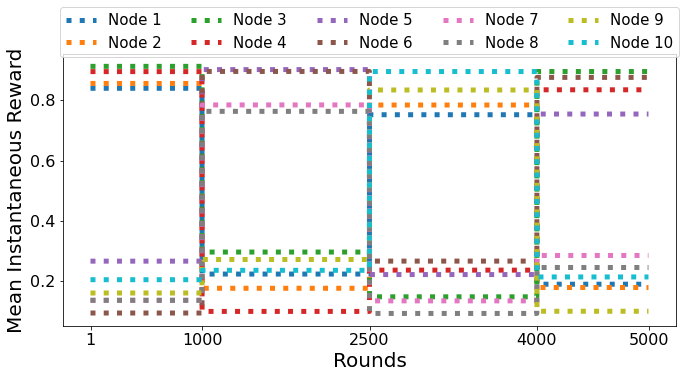

In [19]:
plot_array = np.zeros((nodes, rounds))
for i in range(0, len(change_points)):
    
    for j in range(rounds):
        if j == change_points[i]:
            if j == change_points[len(change_points)-1]:
                for k in range(nodes):
                    plot_array[k,j:rounds] = mean_b_gt[i,k]
            else:
                for k in range(nodes):
                    plot_array[k,j:change_points[i+1]] = mean_b_gt[i,k]

fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(nodes):
#     expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(plot_array[arm,:], label=f"Node {arm+1}", linestyle=':', linewidth=5)
#     print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = [1] + change_points[1:] + [rounds]
plt.xticks(extraticks, fontsize=16) #, rotation=35

plt.yticks(fontsize=16)

ax.set_xlabel('Rounds', fontsize=20)
ax.set_ylabel(fr"Mean Instantaneous Reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.2), prop={'size': 15})
fig.savefig(f"mean_instantaneous_reward.jpg", format = 'jpg', dpi = 300, bbox_inches='tight')

plt.show()

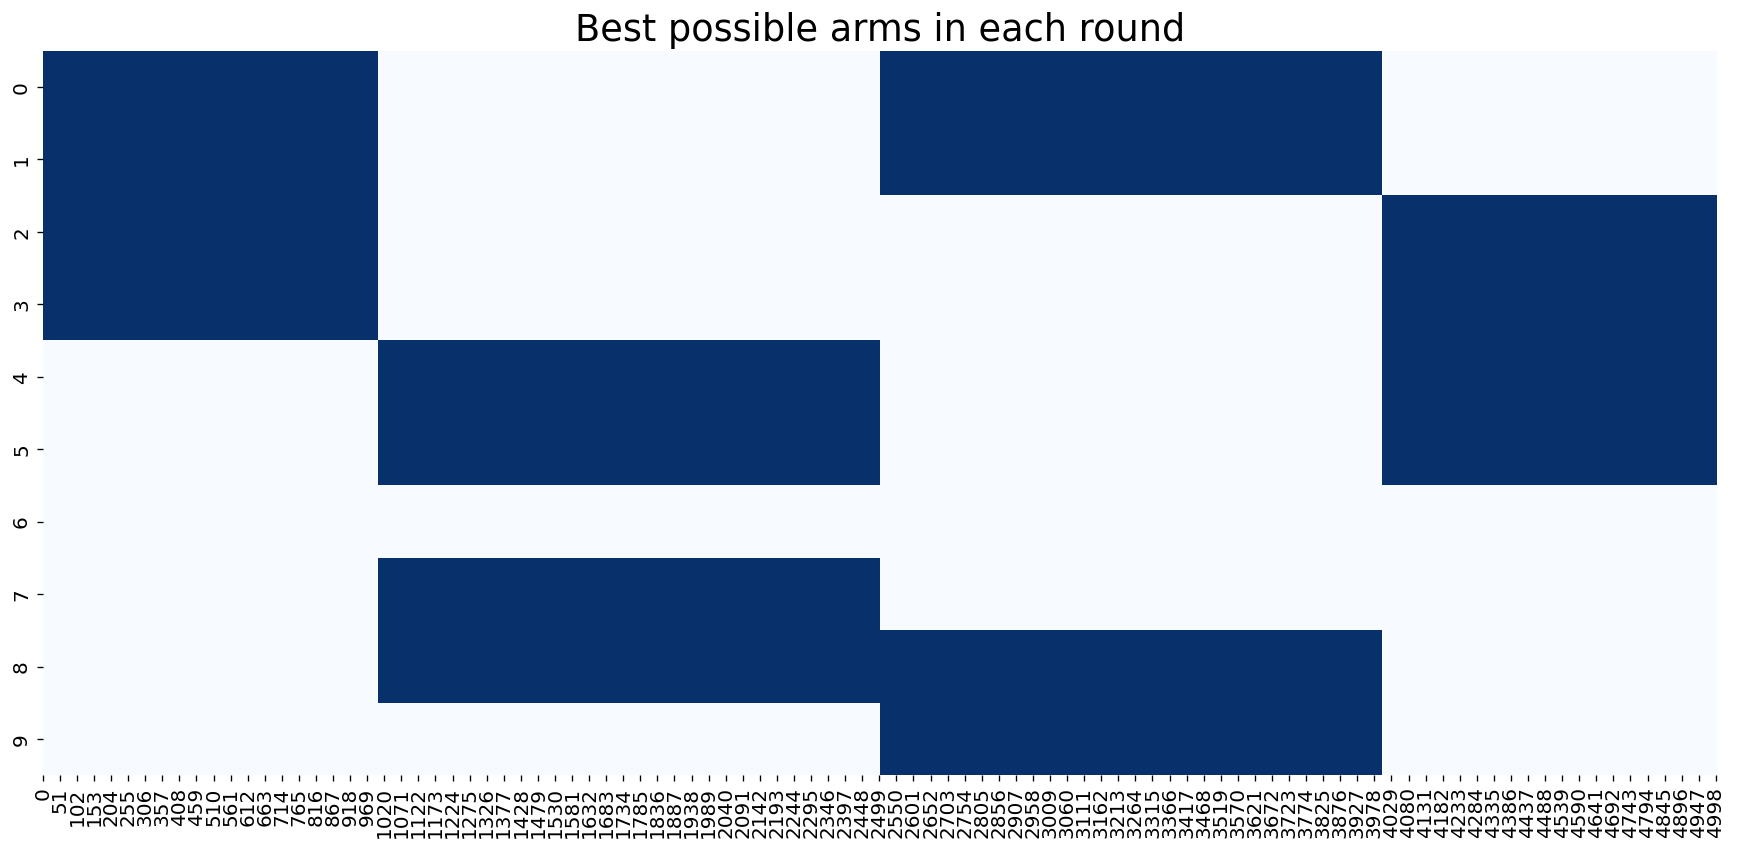

In [20]:
oracle_actions = best_action_choice[0]
for i in range(rounds):
    ch_p_ind = change_point_index(i)
    oracle_actions = np.concatenate((oracle_actions, best_action_choice[ch_p_ind]), axis=1)

# Plot
fig3 = plt.figure(figsize=(18,8), dpi= 120)
tttt=sns.heatmap(oracle_actions, cmap='Blues',linewidth=0.001, linecolor='k',cbar=False)

# Decorations
plt.title('Best possible arms in each round', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [21]:
# s is the sparsity of the chosen action vector 
# nodes is the number of arms 

def initial_rounds_actions(nodes,s):

    initial_actions = np.zeros((nodes,nodes))
    initial_actions = initial_actions + np.eye(nodes)
    for i in range(nodes):
        if i <= s:
            for j in range(i):
                initial_actions[i,j] = 1
        elif i > s:
            temp = rand_binary_array(number_of_chosen_arms=s-1, n=i-1)
            temp1 = np.nonzero(temp)
            for j in range(temp1[0].shape[0]):
                temp2 = temp1[0][j]
                initial_actions[i,temp2] = 1
            
#     np.random.shuffle(initial_actions) #!
    needed_initial_matrix=initial_actions.T
    
    return needed_initial_matrix

In [22]:
all_actions_taken = initial_rounds_actions(nodes=nodes, s=super_arm_sparsity)
initial_rounds = nodes

In [23]:
#Up until this point was editted and fixed <----------------

## NDC-SEM initial rounds

In [24]:
# NDC-SEM variables
f_measure = np.zeros((1, rounds)) 
collected_expected_rewards = np.zeros((1, rounds))
collected_instantaneous_rewards = np.zeros((1, rounds))
instantaneous_regret = np.zeros((1, rounds))
expected_regret = np.zeros((1, rounds))
graph_mse = np.zeros((1, rounds))


#To record number of plays of each state #(B_signals.shape[0],1,num_rounds)
num_plays_state = np.zeros((nodes, 1, rounds)) #T = np.ones((nodes,1)) --> Maybe zeros?

#To record empirical average reward of each state #(B_signals.shape[0],1,num_rounds)
emp_avg_reward_state = np.zeros((nodes, 1, rounds)) #b_bar = np.ones((nodes,1)) --> Maybe zeros?

#To record UCB index of each state #(B_signals.shape[0],1,num_rounds)
UCB_state = np.ones((nodes, 1, rounds)) #b_hat = np.ones((nodes,1))

In [25]:
################ initial rounds ######################

for i in range(initial_rounds):
    ch_p_ind = change_point_index(i)
    
    base_reward_i = np.transpose(np.asarray([B[:,i]]))
    x_i = np.transpose(np.asarray([all_actions_taken[:, i]]))  
    z_i = np.multiply(base_reward_i, x_i)
    
    y_i = np.matmul(C_gt, z_i)
    if i == 0:
        Y = y_i
    else:
        Y = np.concatenate((Y, y_i),axis=1)
    
    collected_expected_rewards[0,i] = overall_reward(x=x_i, b=mean_b_gt[ch_p_ind], A=w_gt) 
    collected_instantaneous_rewards[0,i] = overall_reward(x=x_i, b=base_reward_i, A=w_gt)
    
    expected_regret[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards[0,i]
    instantaneous_regret[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i, A=w_gt
    ) - collected_instantaneous_rewards[0, i]
    
    num_plays_state[:,:,i], emp_avg_reward_state[:,:,i], UCB_state[:,:,i] = UCB_func(
      t=i, x=all_actions_taken[:, i], num_plays_state=num_plays_state,
      inst_reward=B, xi=xi, s=s, gamma=gamma, Delay=Delay,
    )

    print('collected reward of round ', i , ' is ', collected_expected_rewards[0,i])


The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward of round  0  is  0.8401672517614813
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The 

## 1. Acting based on NDC-SEM (our algorithm)

In [26]:
# How to learn graph if delay is more than observations?

In [27]:
for i in range(initial_rounds, rounds):
    ch_p_ind = change_point_index(i)
    
    # Matrix which columns are z_t values up to current moment. 
    # Truncated matrix with up to (t - D) is calculated inside `graph_learning`
    Z_t = np.multiply(all_actions_taken, B[:, 0:all_actions_taken.shape[1]])
#     print('Z_t shape is ', Z_t.shape)

    if f_measure[0, i - 1] == 1:
        # Estimated adjacency matrix is good enough in previous round, no need to re-estimate it.
        f_measure[0, i] = f_measure[0, i - 1]
    else:     
        w_hat, f_measure[0, i], best_lambda, graph_mse[0, i] = graph_learning(
            current_time=i, A_gt=w_gt, observ=Y, perturb=Z_t, 
            nodes=nodes, skiped=skiped, best_lambda=best_lambda, Delay=Delay,
        )
        if f_measure[0,i]>=0.9:
            skiped = 1
        elif f_measure[0,i]<0.9:
            skiped = 0
    
    base_reward_i = np.transpose(np.asarray([B[:,i]]))
    x_i = Best_action_func_new(A=w_hat, b=UCB_state[:,:,i - 1], s=super_arm_sparsity)
    all_actions_taken = np.concatenate((all_actions_taken, x_i), axis=1)

    z_i = np.multiply(base_reward_i, x_i)
    y_i = np.matmul(C_gt, z_i)
    Y = np.concatenate((Y, y_i), axis=1)
    
    collected_expected_rewards[0, i] = overall_reward(x=x_i, b=mean_b_gt[ch_p_ind], A=w_gt)
    collected_instantaneous_rewards[0, i] = overall_reward(x=x_i, b=base_reward_i, A=w_gt)
    expected_regret[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards[0, i]
    instantaneous_regret[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i, A=w_gt
    ) - collected_instantaneous_rewards[0,i]
    
    if expected_regret[0, i] < 0:
        raise ValueError()
    
    print(f'collected reward round {i} is: ', collected_expected_rewards[0, i])
    
    num_plays_state[:,:,i], emp_avg_reward_state[:,:,i], UCB_state[:,:,i] = UCB_func(
      t=i, x=x_i, num_plays_state=num_plays_state,
      inst_reward=B, xi=xi, s=s, gamma=gamma, Delay=Delay,
    )
	


collected reward round 10 is:  1.966473740480981
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 11 is:  2.160689172246265
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm 

collected reward round 28 is:  0.7855012852856147
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 29 is:  2.160918273095753
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm

collected reward round 45 is:  1.361490356822216
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 46 is:  2.048245144296637
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm 

collected reward round 62 is:  2.2023832450207514
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 63 is:  1.3678577438227584
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base ar

collected reward round 80 is:  2.1140476811191937
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 81 is:  2.1117373331839895
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base ar

collected reward round 98 is:  2.7543577505519026
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 99 is:  2.8758035503348203
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base ar

collected reward round 116 is:  2.807366628679516
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 117 is:  0.915624820004279
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base ar

collected reward round 134 is:  2.103963175171824
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 135 is:  2.034511857323916
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base ar

collected reward round 151 is:  1.5382553826679515
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 152 is:  2.1623250441073756
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base 

collected reward round 169 is:  2.778372316557353
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 170 is:  2.0408792443244583
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base a

collected reward round 187 is:  2.8077654334918853
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 188 is:  0.7855012852856147
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base 

collected reward round 205 is:  3.504801499999035
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 206 is:  2.8998181163402705
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 207 is:  2.7623286816494277
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 208 is:  2.1380622471246435
The given base arm is not pulled yet
The given base arm is not pulled yet
collected reward round 209 is:  2.7623286816494277
The given base arm is not pulled yet
collected reward round 210 is:  2.8998181163402705
colle

collected reward round 376 is:  3.504801499999035
collected reward round 377 is:  3.504801499999035
collected reward round 378 is:  3.504801499999035
collected reward round 379 is:  3.504801499999035
collected reward round 380 is:  3.504801499999035
collected reward round 381 is:  3.504801499999035
collected reward round 382 is:  3.504801499999035
collected reward round 383 is:  3.504801499999035
collected reward round 384 is:  3.504801499999035
collected reward round 385 is:  3.504801499999035
collected reward round 386 is:  3.504801499999035
collected reward round 387 is:  3.504801499999035
collected reward round 388 is:  3.504801499999035
collected reward round 389 is:  3.504801499999035
collected reward round 390 is:  3.504801499999035
collected reward round 391 is:  3.504801499999035
collected reward round 392 is:  3.504801499999035
collected reward round 393 is:  3.504801499999035
collected reward round 394 is:  3.504801499999035
collected reward round 395 is:  3.504801499999035


collected reward round 548 is:  3.504801499999035
collected reward round 549 is:  3.504801499999035
collected reward round 550 is:  3.504801499999035
collected reward round 551 is:  3.504801499999035
collected reward round 552 is:  3.504801499999035
collected reward round 553 is:  3.504801499999035
collected reward round 554 is:  3.504801499999035
collected reward round 555 is:  3.504801499999035
collected reward round 556 is:  3.504801499999035
collected reward round 557 is:  3.504801499999035
collected reward round 558 is:  3.504801499999035
collected reward round 559 is:  3.504801499999035
collected reward round 560 is:  3.504801499999035
collected reward round 561 is:  3.3833557002161174
collected reward round 562 is:  3.3833557002161174
collected reward round 563 is:  3.3833557002161174
collected reward round 564 is:  3.504801499999035
collected reward round 565 is:  3.504801499999035
collected reward round 566 is:  3.3833557002161174
collected reward round 567 is:  3.383355700216

collected reward round 719 is:  3.3833557002161174
collected reward round 720 is:  3.3833557002161174
collected reward round 721 is:  3.3833557002161174
collected reward round 722 is:  3.3833557002161174
collected reward round 723 is:  3.3833557002161174
collected reward round 724 is:  3.3833557002161174
collected reward round 725 is:  3.3833557002161174
collected reward round 726 is:  3.3833557002161174
collected reward round 727 is:  3.3833557002161174
collected reward round 728 is:  3.3833557002161174
collected reward round 729 is:  3.3833557002161174
collected reward round 730 is:  3.3833557002161174
collected reward round 731 is:  3.3833557002161174
collected reward round 732 is:  3.3833557002161174
collected reward round 733 is:  3.3833557002161174
collected reward round 734 is:  3.3833557002161174
collected reward round 735 is:  3.3833557002161174
collected reward round 736 is:  3.3833557002161174
collected reward round 737 is:  3.3833557002161174
collected reward round 738 is: 

collected reward round 883 is:  3.504801499999035
collected reward round 884 is:  3.504801499999035
collected reward round 885 is:  3.504801499999035
collected reward round 886 is:  3.504801499999035
collected reward round 887 is:  3.504801499999035
collected reward round 888 is:  3.504801499999035
collected reward round 889 is:  3.504801499999035
collected reward round 890 is:  3.504801499999035
collected reward round 891 is:  3.504801499999035
collected reward round 892 is:  3.504801499999035
collected reward round 893 is:  3.504801499999035
collected reward round 894 is:  3.504801499999035
collected reward round 895 is:  3.504801499999035
collected reward round 896 is:  3.504801499999035
collected reward round 897 is:  3.504801499999035
collected reward round 898 is:  3.504801499999035
collected reward round 899 is:  3.504801499999035
collected reward round 900 is:  3.504801499999035
collected reward round 901 is:  3.504801499999035
collected reward round 902 is:  3.504801499999035


collected reward round 1052 is:  1.9371137079712124
collected reward round 1053 is:  1.9371137079712124
collected reward round 1054 is:  1.9371137079712124
collected reward round 1055 is:  1.9371137079712124
collected reward round 1056 is:  1.9371137079712124
collected reward round 1057 is:  1.9371137079712124
collected reward round 1058 is:  1.9371137079712124
collected reward round 1059 is:  1.9371137079712124
collected reward round 1060 is:  1.9371137079712124
collected reward round 1061 is:  1.9371137079712124
collected reward round 1062 is:  1.9371137079712124
collected reward round 1063 is:  1.9371137079712124
collected reward round 1064 is:  1.9371137079712124
collected reward round 1065 is:  1.9371137079712124
collected reward round 1066 is:  1.9371137079712124
collected reward round 1067 is:  1.9371137079712124
collected reward round 1068 is:  1.9371137079712124
collected reward round 1069 is:  1.9371137079712124
collected reward round 1070 is:  1.9371137079712124
collected re

collected reward round 1213 is:  3.798138568647487
collected reward round 1214 is:  3.798138568647487
collected reward round 1215 is:  3.798138568647487
collected reward round 1216 is:  3.798138568647487
collected reward round 1217 is:  3.798138568647487
collected reward round 1218 is:  3.798138568647487
collected reward round 1219 is:  3.798138568647487
collected reward round 1220 is:  3.798138568647487
collected reward round 1221 is:  3.798138568647487
collected reward round 1222 is:  3.798138568647487
collected reward round 1223 is:  3.798138568647487
collected reward round 1224 is:  3.798138568647487
collected reward round 1225 is:  3.798138568647487
collected reward round 1226 is:  3.798138568647487
collected reward round 1227 is:  3.798138568647487
collected reward round 1228 is:  3.798138568647487
collected reward round 1229 is:  3.3768878555317907
collected reward round 1230 is:  3.3768878555317907
collected reward round 1231 is:  3.3768878555317907
collected reward round 1232 

collected reward round 1377 is:  4.248454767388822
collected reward round 1378 is:  4.248454767388822
collected reward round 1379 is:  4.248454767388822
collected reward round 1380 is:  4.248454767388822
collected reward round 1381 is:  4.248454767388822
collected reward round 1382 is:  4.248454767388822
collected reward round 1383 is:  4.248454767388822
collected reward round 1384 is:  4.248454767388822
collected reward round 1385 is:  4.248454767388822
collected reward round 1386 is:  4.248454767388822
collected reward round 1387 is:  4.248454767388822
collected reward round 1388 is:  4.248454767388822
collected reward round 1389 is:  4.248454767388822
collected reward round 1390 is:  4.248454767388822
collected reward round 1391 is:  4.248454767388822
collected reward round 1392 is:  4.248454767388822
collected reward round 1393 is:  4.248454767388822
collected reward round 1394 is:  4.248454767388822
collected reward round 1395 is:  4.248454767388822
collected reward round 1396 is:

collected reward round 1540 is:  4.678867348679898
collected reward round 1541 is:  4.678867348679898
collected reward round 1542 is:  4.678867348679898
collected reward round 1543 is:  4.678867348679898
collected reward round 1544 is:  4.678867348679898
collected reward round 1545 is:  4.678867348679898
collected reward round 1546 is:  4.678867348679898
collected reward round 1547 is:  4.678867348679898
collected reward round 1548 is:  4.678867348679898
collected reward round 1549 is:  4.678867348679898
collected reward round 1550 is:  4.678867348679898
collected reward round 1551 is:  4.678867348679898
collected reward round 1552 is:  4.678867348679898
collected reward round 1553 is:  4.678867348679898
collected reward round 1554 is:  4.678867348679898
collected reward round 1555 is:  4.678867348679898
collected reward round 1556 is:  4.678867348679898
collected reward round 1557 is:  4.678867348679898
collected reward round 1558 is:  4.678867348679898
collected reward round 1559 is:

collected reward round 1701 is:  4.678867348679898
collected reward round 1702 is:  4.678867348679898
collected reward round 1703 is:  4.678867348679898
collected reward round 1704 is:  4.678867348679898
collected reward round 1705 is:  4.678867348679898
collected reward round 1706 is:  4.678867348679898
collected reward round 1707 is:  4.678867348679898
collected reward round 1708 is:  4.678867348679898
collected reward round 1709 is:  4.678867348679898
collected reward round 1710 is:  4.678867348679898
collected reward round 1711 is:  4.678867348679898
collected reward round 1712 is:  4.678867348679898
collected reward round 1713 is:  4.678867348679898
collected reward round 1714 is:  4.678867348679898
collected reward round 1715 is:  4.678867348679898
collected reward round 1716 is:  4.678867348679898
collected reward round 1717 is:  4.678867348679898
collected reward round 1718 is:  4.678867348679898
collected reward round 1719 is:  4.678867348679898
collected reward round 1720 is:

collected reward round 1864 is:  3.9531592533356394
collected reward round 1865 is:  3.9531592533356394
collected reward round 1866 is:  3.9531592533356394
collected reward round 1867 is:  3.9531592533356394
collected reward round 1868 is:  3.9531592533356394
collected reward round 1869 is:  3.9531592533356394
collected reward round 1870 is:  3.9531592533356394
collected reward round 1871 is:  3.9531592533356394
collected reward round 1872 is:  3.9531592533356394
collected reward round 1873 is:  3.9531592533356394
collected reward round 1874 is:  3.9531592533356394
collected reward round 1875 is:  3.9531592533356394
collected reward round 1876 is:  3.9531592533356394
collected reward round 1877 is:  3.9531592533356394
collected reward round 1878 is:  3.9531592533356394
collected reward round 1879 is:  3.9531592533356394
collected reward round 1880 is:  3.9531592533356394
collected reward round 1881 is:  3.9531592533356394
collected reward round 1882 is:  3.9531592533356394
collected re

collected reward round 2025 is:  2.9706700410220157
collected reward round 2026 is:  2.9706700410220157
collected reward round 2027 is:  2.9706700410220157
collected reward round 2028 is:  2.9706700410220157
collected reward round 2029 is:  2.9706700410220157
collected reward round 2030 is:  2.9706700410220157
collected reward round 2031 is:  2.9706700410220157
collected reward round 2032 is:  2.9706700410220157
collected reward round 2033 is:  2.9706700410220157
collected reward round 2034 is:  2.9706700410220157
collected reward round 2035 is:  2.9706700410220157
collected reward round 2036 is:  2.9706700410220157
collected reward round 2037 is:  2.9706700410220157
collected reward round 2038 is:  2.9706700410220157
collected reward round 2039 is:  2.9706700410220157
collected reward round 2040 is:  2.9706700410220157
collected reward round 2041 is:  2.9706700410220157
collected reward round 2042 is:  4.0003440569488244
collected reward round 2043 is:  4.0003440569488244
collected re

collected reward round 2184 is:  2.0861194523373157
collected reward round 2185 is:  2.0861194523373157
collected reward round 2186 is:  2.0861194523373157
collected reward round 2187 is:  2.966848232369726
collected reward round 2188 is:  2.966848232369726
collected reward round 2189 is:  2.966848232369726
collected reward round 2190 is:  2.966848232369726
collected reward round 2191 is:  2.0861194523373157
collected reward round 2192 is:  2.0861194523373157
collected reward round 2193 is:  2.0861194523373157
collected reward round 2194 is:  2.0861194523373157
collected reward round 2195 is:  2.0861194523373157
collected reward round 2196 is:  2.0861194523373157
collected reward round 2197 is:  2.0861194523373157
collected reward round 2198 is:  2.0861194523373157
collected reward round 2199 is:  2.0861194523373157
collected reward round 2200 is:  2.0861194523373157
collected reward round 2201 is:  2.0861194523373157
collected reward round 2202 is:  2.0861194523373157
collected reward

collected reward round 2344 is:  4.111266357405418
collected reward round 2345 is:  4.111266357405418
collected reward round 2346 is:  4.111266357405418
collected reward round 2347 is:  4.111266357405418
collected reward round 2348 is:  4.111266357405418
collected reward round 2349 is:  4.111266357405418
collected reward round 2350 is:  4.111266357405418
collected reward round 2351 is:  4.111266357405418
collected reward round 2352 is:  4.111266357405418
collected reward round 2353 is:  4.111266357405418
collected reward round 2354 is:  4.111266357405418
collected reward round 2355 is:  4.111266357405418
collected reward round 2356 is:  4.111266357405418
collected reward round 2357 is:  4.111266357405418
collected reward round 2358 is:  4.111266357405418
collected reward round 2359 is:  4.111266357405418
collected reward round 2360 is:  4.111266357405418
collected reward round 2361 is:  4.111266357405418
collected reward round 2362 is:  4.111266357405418
collected reward round 2363 is:

collected reward round 2506 is:  4.41353802523555
collected reward round 2507 is:  4.41353802523555
collected reward round 2508 is:  4.41353802523555
collected reward round 2509 is:  4.41353802523555
collected reward round 2510 is:  4.41353802523555
collected reward round 2511 is:  4.41353802523555
collected reward round 2512 is:  4.41353802523555
collected reward round 2513 is:  4.41353802523555
collected reward round 2514 is:  4.41353802523555
collected reward round 2515 is:  4.41353802523555
collected reward round 2516 is:  4.41353802523555
collected reward round 2517 is:  4.41353802523555
collected reward round 2518 is:  4.41353802523555
collected reward round 2519 is:  4.41353802523555
collected reward round 2520 is:  4.41353802523555
collected reward round 2521 is:  4.41353802523555
collected reward round 2522 is:  4.41353802523555
collected reward round 2523 is:  4.41353802523555
collected reward round 2524 is:  4.41353802523555
collected reward round 2525 is:  4.41353802523555


collected reward round 2670 is:  4.50086442609052
collected reward round 2671 is:  4.50086442609052
collected reward round 2672 is:  4.50086442609052
collected reward round 2673 is:  4.50086442609052
collected reward round 2674 is:  4.50086442609052
collected reward round 2675 is:  4.50086442609052
collected reward round 2676 is:  4.50086442609052
collected reward round 2677 is:  4.50086442609052
collected reward round 2678 is:  4.50086442609052
collected reward round 2679 is:  4.50086442609052
collected reward round 2680 is:  4.50086442609052
collected reward round 2681 is:  4.50086442609052
collected reward round 2682 is:  4.50086442609052
collected reward round 2683 is:  4.50086442609052
collected reward round 2684 is:  4.50086442609052
collected reward round 2685 is:  4.50086442609052
collected reward round 2686 is:  4.50086442609052
collected reward round 2687 is:  4.50086442609052
collected reward round 2688 is:  4.50086442609052
collected reward round 2689 is:  4.50086442609052


collected reward round 2832 is:  5.5499023690019245
collected reward round 2833 is:  5.5499023690019245
collected reward round 2834 is:  5.5499023690019245
collected reward round 2835 is:  5.5499023690019245
collected reward round 2836 is:  5.5499023690019245
collected reward round 2837 is:  5.5499023690019245
collected reward round 2838 is:  5.5499023690019245
collected reward round 2839 is:  5.5499023690019245
collected reward round 2840 is:  5.5499023690019245
collected reward round 2841 is:  5.5499023690019245
collected reward round 2842 is:  5.5499023690019245
collected reward round 2843 is:  5.5499023690019245
collected reward round 2844 is:  5.5499023690019245
collected reward round 2845 is:  5.5499023690019245
collected reward round 2846 is:  5.5499023690019245
collected reward round 2847 is:  5.5499023690019245
collected reward round 2848 is:  5.5499023690019245
collected reward round 2849 is:  5.5499023690019245
collected reward round 2850 is:  5.5499023690019245
collected re

collected reward round 2993 is:  6.535471613345649
collected reward round 2994 is:  6.535471613345649
collected reward round 2995 is:  6.535471613345649
collected reward round 2996 is:  6.535471613345649
collected reward round 2997 is:  6.535471613345649
collected reward round 2998 is:  6.535471613345649
collected reward round 2999 is:  6.535471613345649
collected reward round 3000 is:  6.535471613345649
collected reward round 3001 is:  6.535471613345649
collected reward round 3002 is:  6.535471613345649
collected reward round 3003 is:  6.535471613345649
collected reward round 3004 is:  6.535471613345649
collected reward round 3005 is:  6.535471613345649
collected reward round 3006 is:  6.535471613345649
collected reward round 3007 is:  6.535471613345649
collected reward round 3008 is:  6.535471613345649
collected reward round 3009 is:  6.535471613345649
collected reward round 3010 is:  6.535471613345649
collected reward round 3011 is:  6.535471613345649
collected reward round 3012 is:

collected reward round 3154 is:  6.535471613345649
collected reward round 3155 is:  6.535471613345649
collected reward round 3156 is:  6.535471613345649
collected reward round 3157 is:  6.535471613345649
collected reward round 3158 is:  6.535471613345649
collected reward round 3159 is:  6.535471613345649
collected reward round 3160 is:  6.535471613345649
collected reward round 3161 is:  6.535471613345649
collected reward round 3162 is:  6.535471613345649
collected reward round 3163 is:  6.019729379277709
collected reward round 3164 is:  6.535471613345649
collected reward round 3165 is:  6.535471613345649
collected reward round 3166 is:  6.535471613345649
collected reward round 3167 is:  6.535471613345649
collected reward round 3168 is:  6.535471613345649
collected reward round 3169 is:  6.535471613345649
collected reward round 3170 is:  6.535471613345649
collected reward round 3171 is:  6.535471613345649
collected reward round 3172 is:  6.535471613345649
collected reward round 3173 is:

collected reward round 3315 is:  6.019729379277709
collected reward round 3316 is:  6.019729379277709
collected reward round 3317 is:  6.019729379277709
collected reward round 3318 is:  6.019729379277709
collected reward round 3319 is:  6.019729379277709
collected reward round 3320 is:  6.019729379277709
collected reward round 3321 is:  6.019729379277709
collected reward round 3322 is:  6.019729379277709
collected reward round 3323 is:  6.019729379277709
collected reward round 3324 is:  6.019729379277709
collected reward round 3325 is:  6.019729379277709
collected reward round 3326 is:  6.019729379277709
collected reward round 3327 is:  6.019729379277709
collected reward round 3328 is:  6.019729379277709
collected reward round 3329 is:  6.019729379277709
collected reward round 3330 is:  6.019729379277709
collected reward round 3331 is:  6.019729379277709
collected reward round 3332 is:  6.019729379277709
collected reward round 3333 is:  6.019729379277709
collected reward round 3334 is:

collected reward round 3476 is:  6.535471613345649
collected reward round 3477 is:  6.535471613345649
collected reward round 3478 is:  6.535471613345649
collected reward round 3479 is:  6.535471613345649
collected reward round 3480 is:  6.535471613345649
collected reward round 3481 is:  6.535471613345649
collected reward round 3482 is:  6.535471613345649
collected reward round 3483 is:  6.535471613345649
collected reward round 3484 is:  6.535471613345649
collected reward round 3485 is:  6.535471613345649
collected reward round 3486 is:  6.535471613345649
collected reward round 3487 is:  6.535471613345649
collected reward round 3488 is:  6.535471613345649
collected reward round 3489 is:  6.535471613345649
collected reward round 3490 is:  6.535471613345649
collected reward round 3491 is:  6.535471613345649
collected reward round 3492 is:  6.535471613345649
collected reward round 3493 is:  6.535471613345649
collected reward round 3494 is:  6.535471613345649
collected reward round 3495 is:

collected reward round 3638 is:  5.885510470203881
collected reward round 3639 is:  5.885510470203881
collected reward round 3640 is:  5.885510470203881
collected reward round 3641 is:  5.885510470203881
collected reward round 3642 is:  5.917749606214171
collected reward round 3643 is:  5.917749606214171
collected reward round 3644 is:  5.885510470203881
collected reward round 3645 is:  5.885510470203881
collected reward round 3646 is:  5.885510470203881
collected reward round 3647 is:  5.885510470203881
collected reward round 3648 is:  5.917749606214171
collected reward round 3649 is:  5.917749606214171
collected reward round 3650 is:  5.885510470203881
collected reward round 3651 is:  5.885510470203881
collected reward round 3652 is:  5.885510470203881
collected reward round 3653 is:  5.885510470203881
collected reward round 3654 is:  5.885510470203881
collected reward round 3655 is:  5.885510470203881
collected reward round 3656 is:  5.885510470203881
collected reward round 3657 is:

collected reward round 3799 is:  5.367274158342089
collected reward round 3800 is:  5.367274158342089
collected reward round 3801 is:  5.367274158342089
collected reward round 3802 is:  5.367274158342089
collected reward round 3803 is:  5.367274158342089
collected reward round 3804 is:  5.367274158342089
collected reward round 3805 is:  5.367274158342089
collected reward round 3806 is:  5.367274158342089
collected reward round 3807 is:  5.367274158342089
collected reward round 3808 is:  5.367274158342089
collected reward round 3809 is:  5.367274158342089
collected reward round 3810 is:  5.367274158342089
collected reward round 3811 is:  5.367274158342089
collected reward round 3812 is:  5.367274158342089
collected reward round 3813 is:  5.367274158342089
collected reward round 3814 is:  5.367274158342089
collected reward round 3815 is:  5.367274158342089
collected reward round 3816 is:  5.367274158342089
collected reward round 3817 is:  5.367274158342089
collected reward round 3818 is:

collected reward round 3961 is:  5.5499023690019245
collected reward round 3962 is:  5.5499023690019245
collected reward round 3963 is:  5.5499023690019245
collected reward round 3964 is:  5.5499023690019245
collected reward round 3965 is:  5.5499023690019245
collected reward round 3966 is:  5.5499023690019245
collected reward round 3967 is:  5.5499023690019245
collected reward round 3968 is:  5.5499023690019245
collected reward round 3969 is:  5.5499023690019245
collected reward round 3970 is:  5.5499023690019245
collected reward round 3971 is:  5.5499023690019245
collected reward round 3972 is:  5.5499023690019245
collected reward round 3973 is:  5.5499023690019245
collected reward round 3974 is:  5.5499023690019245
collected reward round 3975 is:  5.5499023690019245
collected reward round 3976 is:  5.5499023690019245
collected reward round 3977 is:  5.5499023690019245
collected reward round 3978 is:  5.5499023690019245
collected reward round 3979 is:  5.5499023690019245
collected re

collected reward round 4123 is:  1.8262222914795603
collected reward round 4124 is:  1.8262222914795603
collected reward round 4125 is:  1.8262222914795603
collected reward round 4126 is:  1.8262222914795603
collected reward round 4127 is:  1.8262222914795603
collected reward round 4128 is:  1.8262222914795603
collected reward round 4129 is:  1.8262222914795603
collected reward round 4130 is:  1.8262222914795603
collected reward round 4131 is:  1.8262222914795603
collected reward round 4132 is:  1.8262222914795603
collected reward round 4133 is:  1.8262222914795603
collected reward round 4134 is:  1.8262222914795603
collected reward round 4135 is:  1.8262222914795603
collected reward round 4136 is:  1.8262222914795603
collected reward round 4137 is:  1.8262222914795603
collected reward round 4138 is:  1.8262222914795603
collected reward round 4139 is:  1.8262222914795603
collected reward round 4140 is:  1.8262222914795603
collected reward round 4141 is:  1.8262222914795603
collected re

collected reward round 4282 is:  2.142299226136448
collected reward round 4283 is:  2.142299226136448
collected reward round 4284 is:  2.142299226136448
collected reward round 4285 is:  2.142299226136448
collected reward round 4286 is:  2.142299226136448
collected reward round 4287 is:  2.142299226136448
collected reward round 4288 is:  2.8590356971469224
collected reward round 4289 is:  2.8590356971469224
collected reward round 4290 is:  2.8590356971469224
collected reward round 4291 is:  2.8590356971469224
collected reward round 4292 is:  2.8590356971469224
collected reward round 4293 is:  2.8590356971469224
collected reward round 4294 is:  2.8590356971469224
collected reward round 4295 is:  2.8590356971469224
collected reward round 4296 is:  2.8590356971469224
collected reward round 4297 is:  2.8590356971469224
collected reward round 4298 is:  2.8590356971469224
collected reward round 4299 is:  2.8590356971469224
collected reward round 4300 is:  2.8590356971469224
collected reward r

collected reward round 4443 is:  3.504239919645968
collected reward round 4444 is:  3.504239919645968
collected reward round 4445 is:  3.504239919645968
collected reward round 4446 is:  3.504239919645968
collected reward round 4447 is:  3.504239919645968
collected reward round 4448 is:  3.504239919645968
collected reward round 4449 is:  3.504239919645968
collected reward round 4450 is:  3.504239919645968
collected reward round 4451 is:  3.504239919645968
collected reward round 4452 is:  3.504239919645968
collected reward round 4453 is:  3.504239919645968
collected reward round 4454 is:  3.504239919645968
collected reward round 4455 is:  3.504239919645968
collected reward round 4456 is:  3.504239919645968
collected reward round 4457 is:  3.504239919645968
collected reward round 4458 is:  3.504239919645968
collected reward round 4459 is:  3.504239919645968
collected reward round 4460 is:  3.504239919645968
collected reward round 4461 is:  3.504239919645968
collected reward round 4462 is:

collected reward round 4603 is:  3.341600794729307
collected reward round 4604 is:  3.341600794729307
collected reward round 4605 is:  3.504239919645968
collected reward round 4606 is:  3.504239919645968
collected reward round 4607 is:  3.504239919645968
collected reward round 4608 is:  3.341600794729307
collected reward round 4609 is:  3.341600794729307
collected reward round 4610 is:  3.341600794729307
collected reward round 4611 is:  3.341600794729307
collected reward round 4612 is:  3.341600794729307
collected reward round 4613 is:  3.341600794729307
collected reward round 4614 is:  3.341600794729307
collected reward round 4615 is:  3.341600794729307
collected reward round 4616 is:  3.341600794729307
collected reward round 4617 is:  3.341600794729307
collected reward round 4618 is:  3.341600794729307
collected reward round 4619 is:  3.341600794729307
collected reward round 4620 is:  3.341600794729307
collected reward round 4621 is:  3.341600794729307
collected reward round 4622 is:

collected reward round 4765 is:  3.341600794729307
collected reward round 4766 is:  3.341600794729307
collected reward round 4767 is:  3.341600794729307
collected reward round 4768 is:  3.341600794729307
collected reward round 4769 is:  3.341600794729307
collected reward round 4770 is:  3.341600794729307
collected reward round 4771 is:  3.341600794729307
collected reward round 4772 is:  3.341600794729307
collected reward round 4773 is:  3.341600794729307
collected reward round 4774 is:  3.341600794729307
collected reward round 4775 is:  3.341600794729307
collected reward round 4776 is:  3.341600794729307
collected reward round 4777 is:  3.341600794729307
collected reward round 4778 is:  3.341600794729307
collected reward round 4779 is:  3.341600794729307
collected reward round 4780 is:  3.341600794729307
collected reward round 4781 is:  2.8941649119603183
collected reward round 4782 is:  2.8941649119603183
collected reward round 4783 is:  2.8941649119603183
collected reward round 4784 

collected reward round 4927 is:  3.3029186636320556
collected reward round 4928 is:  3.363530132669893
collected reward round 4929 is:  3.363530132669893
collected reward round 4930 is:  3.363530132669893
collected reward round 4931 is:  3.363530132669893
collected reward round 4932 is:  3.363530132669893
collected reward round 4933 is:  3.363530132669893
collected reward round 4934 is:  3.363530132669893
collected reward round 4935 is:  3.363530132669893
collected reward round 4936 is:  3.363530132669893
collected reward round 4937 is:  3.363530132669893
collected reward round 4938 is:  3.363530132669893
collected reward round 4939 is:  3.363530132669893
collected reward round 4940 is:  3.363530132669893
collected reward round 4941 is:  3.363530132669893
collected reward round 4942 is:  3.363530132669893
collected reward round 4943 is:  3.363530132669893
collected reward round 4944 is:  3.363530132669893
collected reward round 4945 is:  3.363530132669893
collected reward round 4946 is

### Visualize Oracle actions and actions of NDC-SEM

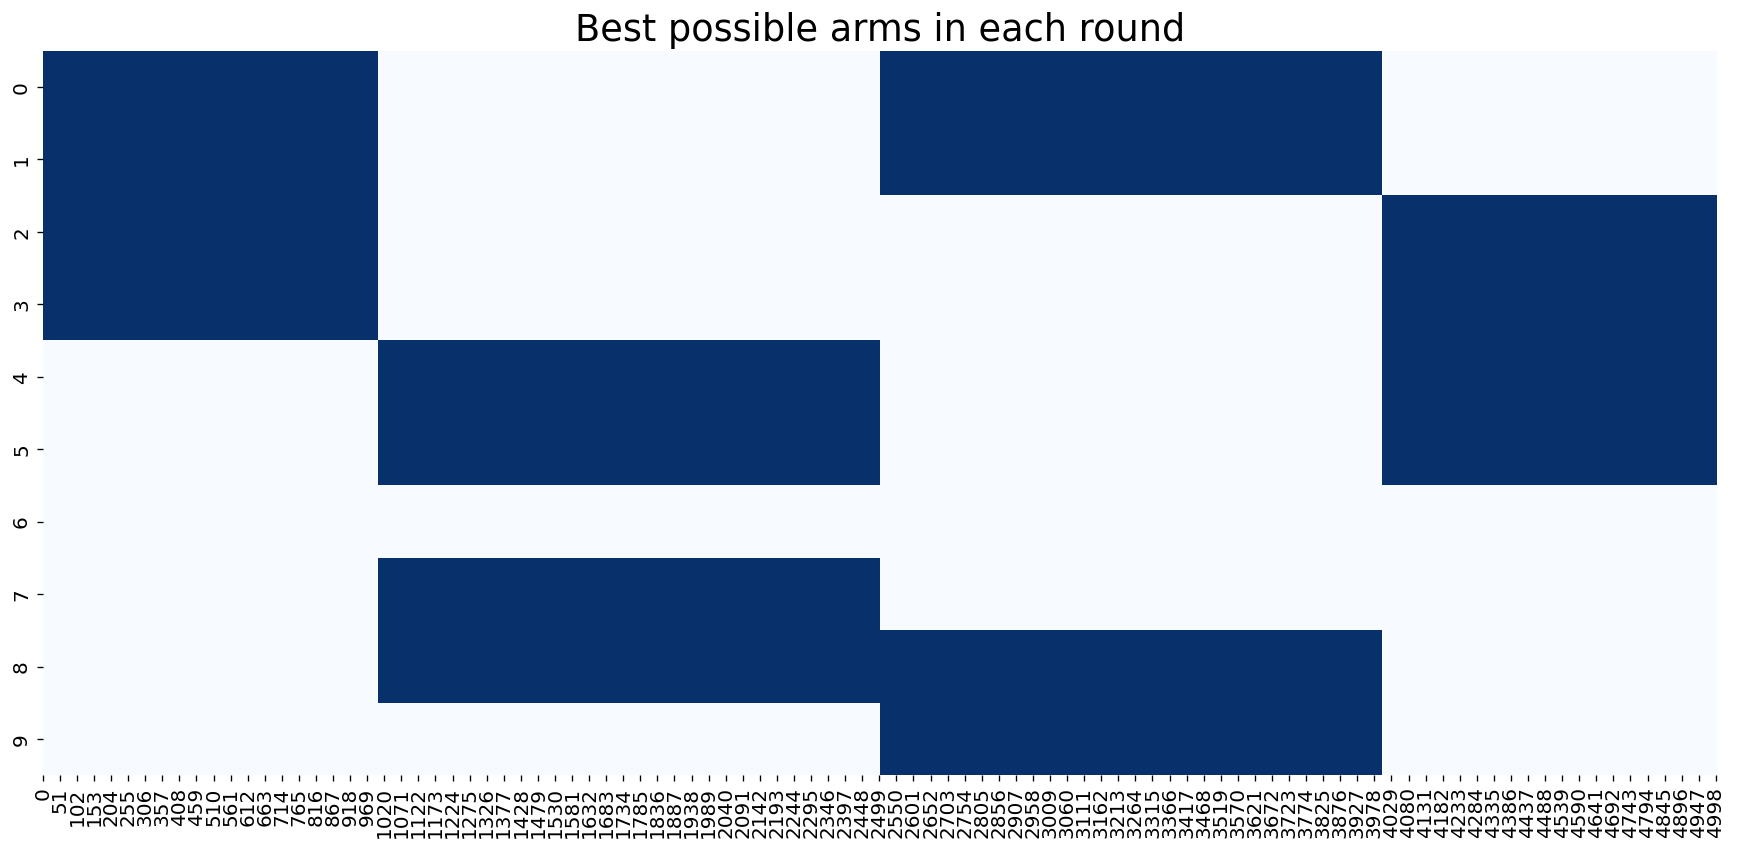

In [28]:
oracle_actions = best_action_choice[0]
for i in range(rounds):
    ch_p_ind = change_point_index(i)
    oracle_actions = np.concatenate((oracle_actions, best_action_choice[ch_p_ind]), axis=1)

# Plot
fig3 = plt.figure(figsize=(18,8), dpi= 120)
tttt=sns.heatmap(oracle_actions, cmap='Blues',linewidth=0.001, linecolor='k',cbar=False)

# Decorations
plt.title('Best possible arms in each round', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
fig3.savefig(f"oracle_actions.jpg", format = 'jpg', dpi =300)

In [29]:
# Plot actions by our algorithm
fig3 = plt.figure(figsize=(18,8), dpi= 1000)
tttt=sns.heatmap(all_actions_taken, cmap='Blues', linewidth=0.01, linecolor='k', cbar=False)

# Decorations
plt.title('Chosen arms by NDC-SEM in each round', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
fig3.savefig(f"chosen_actions_d_{Delay}.jpg", format = 'jpg', dpi = 1500)

#### Plot Graph MSE

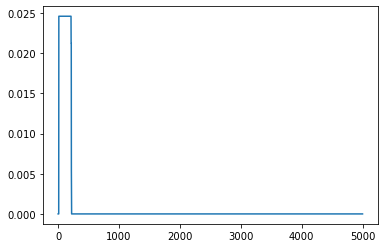

In [30]:
plt.plot(graph_mse[0])

## 2. Acting based on SEM-UCB

In [31]:
def UCB_func_semucb(t, x, num_plays_state, inst_reward, Delay):
    
    emp_avg_reward_state_builtin = np.zeros((num_plays_state.shape[0], 1))
    UCB_state_builtin = np.ones((num_plays_state.shape[0], 1))
        
    delayed_counts_state = np.zeros(num_plays_state.shape[0])
    for k in range(num_plays_state.shape[0]):
        for j in range(t - Delay):
            delayed_counts_state[k] += num_plays_state[k,:,j]


    emp_avg_reward_state_temp = np.zeros(num_plays_state.shape[0])
    for k in range(num_plays_state.shape[0]):
        for j in range(t - Delay):
            emp_avg_reward_state_temp[k] += inst_reward[k,j] * num_plays_state[k,:,j]

    array_indices_of_chosen_base_arms = np.where(x!=0)
    for i in range(array_indices_of_chosen_base_arms[0].shape[0]):
        j = array_indices_of_chosen_base_arms[0][i]
        
        if delayed_counts_state[j] != 0 and t >= Delay:
            emp_avg_reward_state_builtin[j,0] = emp_avg_reward_state_temp[j] / (delayed_counts_state[j])
            
            inside_sqrt = (3 * np.log(t + 1)) / (2 * delayed_counts_state[j])
            if inside_sqrt < 0:
                raise ValueError('UCB calculation produced nan value, because inside sqrt is ', inside_sqrt)

            UCB_state_temp = emp_avg_reward_state_builtin[j, 0] + np.sqrt(inside_sqrt) # UCB calculations for the chosen arms
            UCB_state_builtin[j, 0] = UCB_state_temp

        else:
            print("The given base arm is not pulled yet")

    
    array_indices_of_not_chosen_base_arms = np.where(x==0)
    for i in range(array_indices_of_not_chosen_base_arms[0].shape[0]):
        k = array_indices_of_not_chosen_base_arms[0][i]
        
        if delayed_counts_state[k] != 0 and t >= Delay:
            emp_avg_reward_state_builtin[k,0] = emp_avg_reward_state_temp[k] / (delayed_counts_state[k])
            
            inside_sqrt = (3 * np.log(t + 1)) / (2 * delayed_counts_state[k]) 
            UCB_state_temp = emp_avg_reward_state_builtin[k,0] + np.sqrt(inside_sqrt) # UCB calculations for the non-chosen arms 
            UCB_state_builtin[k,0] = UCB_state_temp

        else:
            print("The given (not selected) base arm is not pulled yet")
     
    new_num_plays_state = (np.asanyarray([x])).T.astype(int) #(num_plays_state[:,:,] + )

    return new_num_plays_state, emp_avg_reward_state_builtin, UCB_state_builtin


In [32]:
np.random.seed(42)

all_actions_taken_semucb = initial_rounds_actions(nodes=nodes, s=super_arm_sparsity)
initial_rounds = nodes

best_lambda_semucb = 0.1
skiped_semucb = 0

In [33]:
# Our algorithm variables
f_measure_semucb = np.zeros((1, rounds)) 
collected_expected_rewards_semucb = np.zeros((1, rounds))
collected_instantaneous_rewards_semucb = np.zeros((1, rounds))
instantaneous_regret_semucb = np.zeros((1, rounds))
expected_regret_semucb = np.zeros((1, rounds))


#To record number of plays of each state #(B_signals.shape[0],1,num_rounds)
num_plays_state_semucb = np.zeros((nodes, 1, rounds)) 

#To record empirical average reward of each state #(B_signals.shape[0],1,num_rounds)
emp_avg_reward_state_semucb = np.zeros((nodes, 1, rounds))

#To record UCB index of each state #(B_signals.shape[0],1,num_rounds)
UCB_state_semucb = np.ones((nodes, 1, rounds))

In [34]:
base_reward_0_semucb = np.transpose(np.asarray([B[:,0]]))

Y_semucb = np.matmul(
    C_gt, np.multiply(base_reward_0_semucb, np.transpose(np.asarray([all_actions_taken_semucb[:,0]])))
)

action_0_semucb = np.transpose(np.asarray([all_actions_taken_semucb[:,0]]))

collected_expected_rewards_semucb[0,0] = overall_reward(x=action_0_semucb, b=mean_b_gt[0], A=w_gt)
collected_instantaneous_rewards_semucb[0,0] = overall_reward(x=action_0_semucb, b=base_reward_0_semucb, A=w_gt)
print('collected reward of round ', 0 , ' is ', collected_expected_rewards_semucb[0,0])

expected_regret_semucb[0,0] = best_expected_reward[0] - collected_expected_rewards_semucb[0,0]

instantaneous_regret_semucb[0,0] = overall_reward(
    x=best_action_choice[0], b=base_reward_0_semucb, A=w_gt
) - collected_instantaneous_rewards_semucb[0,0]

num_plays_state_semucb[:,:,0], emp_avg_reward_state_semucb[:,:,0], UCB_state_semucb[:,:,0] = UCB_func_semucb(
    t=0, x=all_actions_taken_semucb[:,0], num_plays_state=num_plays_state_semucb,
    inst_reward=B, Delay=Delay,
) 

################ initial rounds SEM-UCB ######################

for i in range(1,initial_rounds):
    ch_p_ind = change_point_index(i)
    
    base_reward_i_semucb = np.transpose(np.asarray([B[:,i]]))
    x_i_semucb = np.transpose(np.asarray([all_actions_taken_semucb[:, i]]))  
    z_i_semucb = np.multiply(base_reward_i_semucb, x_i_semucb)
    
    y_i_semucb = np.matmul(C_gt, z_i_semucb)
    Y_semucb = np.concatenate((Y_semucb, y_i_semucb), axis=1)
    
    collected_expected_rewards_semucb[0,i] = overall_reward(x=x_i_semucb, b=mean_b_gt[ch_p_ind], A=w_gt) 
    collected_instantaneous_rewards_semucb[0,i] = overall_reward(x=x_i_semucb, b=base_reward_i_semucb, A=w_gt)
    
    expected_regret_semucb[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_semucb[0,i]
    instantaneous_regret_semucb[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i_semucb, A=w_gt
    ) - collected_instantaneous_rewards_semucb[0, i]
    
    num_plays_state_semucb[:,:,i], emp_avg_reward_state_semucb[:,:,i], UCB_state_semucb[:,:,i] = UCB_func_semucb(
      t=i, x=all_actions_taken_semucb[:, i], num_plays_state=num_plays_state_semucb,
      inst_reward=B, Delay=Delay,
    )

    print('collected reward of round ', i , ' is ', collected_expected_rewards_semucb[0,i])


collected reward of round  0  is  0.8401672517614813
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The 

In [35]:
for i in range(initial_rounds, rounds):
    ch_p_ind = change_point_index(i)
    
    # Matrix which columns are z_t values up to current moment. 
    # Truncated matrix with up to (t - D) is calculated inside `graph_learning`
    Z_t_semucb = np.multiply(all_actions_taken_semucb, B[:, 0:all_actions_taken_semucb.shape[1]])
#     print('Z_t_semucb shape is ', Z_t_semucb.shape)

    if f_measure_semucb[0, i - 1] == 1:
        # Estimated adjacency matrix is good enough in previous round, no need to re-estimate it.
        f_measure_semucb[0, i] = f_measure_semucb[0, i - 1]
    else:     
        w_hat_semucb, f_measure_semucb[0, i], best_lambda_semucb, _ = graph_learning(
            current_time=i, A_gt=w_gt, observ=Y_semucb, perturb=Z_t_semucb, 
            nodes=nodes, skiped=skiped, best_lambda=best_lambda, Delay=Delay,
        )
        if f_measure_semucb[0,i]>=0.9:
            skiped_semucb = 1
        elif f_measure_semucb[0,i]<0.9:
            skiped_semucb = 0
    
    base_reward_i_semucb = np.transpose(np.asarray([B[:,i]]))
    x_i_semucb = Best_action_func_new(A=w_hat_semucb, b=UCB_state_semucb[:,:,i - 1], s=super_arm_sparsity)
    all_actions_taken_semucb = np.concatenate((all_actions_taken_semucb, x_i_semucb), axis=1)

    z_i_semucb = np.multiply(base_reward_i_semucb, x_i_semucb)
    y_i_semucb = np.matmul(C_gt, z_i_semucb)
    Y_semucb = np.concatenate((Y_semucb, y_i_semucb), axis=1)
    
    collected_expected_rewards_semucb[0, i] = overall_reward(x=x_i_semucb, b=mean_b_gt[ch_p_ind], A=w_gt)
    collected_instantaneous_rewards_semucb[0, i] = overall_reward(x=x_i_semucb, b=base_reward_i_semucb, A=w_gt)
    expected_regret_semucb[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_semucb[0, i]
    instantaneous_regret_semucb[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i_semucb, A=w_gt
    ) - collected_instantaneous_rewards_semucb[0,i]
    
    if expected_regret_semucb[0, i] < 0:
        raise ValueError()
    
    print(f'collected reward round {i} is: ', collected_expected_rewards_semucb[0, i])
    
    num_plays_state_semucb[:,:,i], emp_avg_reward_state_semucb[:,:,i], UCB_state_semucb[:,:,i] = UCB_func_semucb(
      t=i, x=x_i_semucb, num_plays_state=num_plays_state_semucb,
      inst_reward=B, Delay=Delay,
    )
	


collected reward round 10 is:  2.326139392738873
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 11 is:  1.4650869458732159
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm

collected reward round 51 is:  1.458921590599684
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 52 is:  2.2595080469075617
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm

collected reward round 95 is:  2.234086709890488
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 96 is:  2.5971075620063067
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm

collected reward round 136 is:  2.172001292014759
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 137 is:  2.7282296096966077
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base a

collected reward round 184 is:  2.2023832450207514
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
collected reward round 185 is:  2.2112768831696514
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base arm is not pulled yet
The given (not selected) base 

collected reward round 221 is:  1.9271981493260886
collected reward round 222 is:  1.9271981493260886
collected reward round 223 is:  1.9271981493260886
collected reward round 224 is:  1.9271981493260886
collected reward round 225 is:  1.9271981493260886
collected reward round 226 is:  1.9271981493260886
collected reward round 227 is:  1.9271981493260886
collected reward round 228 is:  1.9271981493260886
collected reward round 229 is:  1.9271981493260886
collected reward round 230 is:  1.9271981493260886
collected reward round 231 is:  1.9839241464005295
collected reward round 232 is:  1.9271981493260886
collected reward round 233 is:  1.9839241464005295
collected reward round 234 is:  1.9839241464005295
collected reward round 235 is:  1.9839241464005295
collected reward round 236 is:  1.9839241464005295
collected reward round 237 is:  2.7037700396285165
collected reward round 238 is:  2.7037700396285165
collected reward round 239 is:  2.7037700396285165
collected reward round 240 is: 

collected reward round 384 is:  3.3833557002161174
collected reward round 385 is:  3.3833557002161174
collected reward round 386 is:  3.3833557002161174
collected reward round 387 is:  3.3833557002161174
collected reward round 388 is:  3.3833557002161174
collected reward round 389 is:  3.3833557002161174
collected reward round 390 is:  3.3833557002161174
collected reward round 391 is:  3.3833557002161174
collected reward round 392 is:  3.3833557002161174
collected reward round 393 is:  3.3833557002161174
collected reward round 394 is:  3.3833557002161174
collected reward round 395 is:  3.3833557002161174
collected reward round 396 is:  3.3833557002161174
collected reward round 397 is:  3.3833557002161174
collected reward round 398 is:  3.3833557002161174
collected reward round 399 is:  3.3833557002161174
collected reward round 400 is:  3.3833557002161174
collected reward round 401 is:  3.3833557002161174
collected reward round 402 is:  3.3833557002161174
collected reward round 403 is: 

collected reward round 556 is:  3.3673120653081923
collected reward round 557 is:  3.3673120653081923
collected reward round 558 is:  3.3673120653081923
collected reward round 559 is:  3.3673120653081923
collected reward round 560 is:  3.3673120653081923
collected reward round 561 is:  3.3673120653081923
collected reward round 562 is:  3.3673120653081923
collected reward round 563 is:  3.3673120653081923
collected reward round 564 is:  3.3673120653081923
collected reward round 565 is:  3.3673120653081923
collected reward round 566 is:  3.3673120653081923
collected reward round 567 is:  3.3673120653081923
collected reward round 568 is:  3.3673120653081923
collected reward round 569 is:  3.3673120653081923
collected reward round 570 is:  3.3673120653081923
collected reward round 571 is:  3.3673120653081923
collected reward round 572 is:  3.3673120653081923
collected reward round 573 is:  3.3673120653081923
collected reward round 574 is:  3.3673120653081923
collected reward round 575 is: 

collected reward round 721 is:  3.3833557002161174
collected reward round 722 is:  3.3833557002161174
collected reward round 723 is:  3.3833557002161174
collected reward round 724 is:  3.3833557002161174
collected reward round 725 is:  3.3833557002161174
collected reward round 726 is:  3.3833557002161174
collected reward round 727 is:  3.3833557002161174
collected reward round 728 is:  3.3833557002161174
collected reward round 729 is:  3.3833557002161174
collected reward round 730 is:  3.3833557002161174
collected reward round 731 is:  3.3833557002161174
collected reward round 732 is:  3.3833557002161174
collected reward round 733 is:  3.3833557002161174
collected reward round 734 is:  3.3833557002161174
collected reward round 735 is:  3.3833557002161174
collected reward round 736 is:  3.3833557002161174
collected reward round 737 is:  3.3833557002161174
collected reward round 738 is:  3.3833557002161174
collected reward round 739 is:  3.3833557002161174
collected reward round 740 is: 

collected reward round 893 is:  3.3833557002161174
collected reward round 894 is:  3.3833557002161174
collected reward round 895 is:  3.3833557002161174
collected reward round 896 is:  3.3833557002161174
collected reward round 897 is:  3.3833557002161174
collected reward round 898 is:  3.3833557002161174
collected reward round 899 is:  3.3833557002161174
collected reward round 900 is:  3.3833557002161174
collected reward round 901 is:  3.3833557002161174
collected reward round 902 is:  3.3833557002161174
collected reward round 903 is:  3.3833557002161174
collected reward round 904 is:  3.3833557002161174
collected reward round 905 is:  3.3833557002161174
collected reward round 906 is:  3.3833557002161174
collected reward round 907 is:  3.3833557002161174
collected reward round 908 is:  3.3833557002161174
collected reward round 909 is:  3.3833557002161174
collected reward round 910 is:  3.3833557002161174
collected reward round 911 is:  3.3833557002161174
collected reward round 912 is: 

collected reward round 1056 is:  1.8353532756899986
collected reward round 1057 is:  1.8353532756899986
collected reward round 1058 is:  1.8353532756899986
collected reward round 1059 is:  1.8353532756899986
collected reward round 1060 is:  1.8353532756899986
collected reward round 1061 is:  1.8353532756899986
collected reward round 1062 is:  1.8353532756899986
collected reward round 1063 is:  1.8353532756899986
collected reward round 1064 is:  1.8353532756899986
collected reward round 1065 is:  1.8353532756899986
collected reward round 1066 is:  1.8353532756899986
collected reward round 1067 is:  1.8353532756899986
collected reward round 1068 is:  1.8353532756899986
collected reward round 1069 is:  1.8353532756899986
collected reward round 1070 is:  1.8353532756899986
collected reward round 1071 is:  1.8353532756899986
collected reward round 1072 is:  1.8353532756899986
collected reward round 1073 is:  1.8353532756899986
collected reward round 1074 is:  1.8353532756899986
collected re

collected reward round 1215 is:  1.8353532756899986
collected reward round 1216 is:  1.8353532756899986
collected reward round 1217 is:  1.8353532756899986
collected reward round 1218 is:  1.8353532756899986
collected reward round 1219 is:  1.8353532756899986
collected reward round 1220 is:  1.8353532756899986
collected reward round 1221 is:  1.8353532756899986
collected reward round 1222 is:  1.7881684720768136
collected reward round 1223 is:  1.7881684720768136
collected reward round 1224 is:  1.7881684720768136
collected reward round 1225 is:  1.7881684720768136
collected reward round 1226 is:  1.7881684720768136
collected reward round 1227 is:  1.7881684720768136
collected reward round 1228 is:  1.7881684720768136
collected reward round 1229 is:  1.7881684720768136
collected reward round 1230 is:  1.7881684720768136
collected reward round 1231 is:  1.7881684720768136
collected reward round 1232 is:  1.7881684720768136
collected reward round 1233 is:  1.7881684720768136
collected re

collected reward round 1375 is:  1.7881684720768136
collected reward round 1376 is:  1.7881684720768136
collected reward round 1377 is:  1.7881684720768136
collected reward round 1378 is:  1.7881684720768136
collected reward round 1379 is:  1.7881684720768136
collected reward round 1380 is:  1.7881684720768136
collected reward round 1381 is:  1.7881684720768136
collected reward round 1382 is:  1.7881684720768136
collected reward round 1383 is:  1.7881684720768136
collected reward round 1384 is:  1.7881684720768136
collected reward round 1385 is:  1.7881684720768136
collected reward round 1386 is:  1.7881684720768136
collected reward round 1387 is:  1.7881684720768136
collected reward round 1388 is:  1.7881684720768136
collected reward round 1389 is:  2.0230663600936216
collected reward round 1390 is:  2.0230663600936216
collected reward round 1391 is:  2.0230663600936216
collected reward round 1392 is:  2.0230663600936216
collected reward round 1393 is:  2.0230663600936216
collected re

collected reward round 1534 is:  2.0230663600936216
collected reward round 1535 is:  2.0230663600936216
collected reward round 1536 is:  2.0230663600936216
collected reward round 1537 is:  2.0230663600936216
collected reward round 1538 is:  2.0230663600936216
collected reward round 1539 is:  2.0230663600936216
collected reward round 1540 is:  2.0230663600936216
collected reward round 1541 is:  2.0230663600936216
collected reward round 1542 is:  2.0230663600936216
collected reward round 1543 is:  2.0230663600936216
collected reward round 1544 is:  2.0230663600936216
collected reward round 1545 is:  2.0230663600936216
collected reward round 1546 is:  2.0230663600936216
collected reward round 1547 is:  2.0230663600936216
collected reward round 1548 is:  2.0230663600936216
collected reward round 1549 is:  2.0230663600936216
collected reward round 1550 is:  2.0230663600936216
collected reward round 1551 is:  2.0230663600936216
collected reward round 1552 is:  2.0230663600936216
collected re

collected reward round 1698 is:  2.0230663600936216
collected reward round 1699 is:  2.0230663600936216
collected reward round 1700 is:  2.0230663600936216
collected reward round 1701 is:  2.0230663600936216
collected reward round 1702 is:  2.0230663600936216
collected reward round 1703 is:  2.0230663600936216
collected reward round 1704 is:  2.0230663600936216
collected reward round 1705 is:  1.9121440596370285
collected reward round 1706 is:  2.0230663600936216
collected reward round 1707 is:  2.0230663600936216
collected reward round 1708 is:  1.9121440596370285
collected reward round 1709 is:  1.9121440596370285
collected reward round 1710 is:  1.9121440596370285
collected reward round 1711 is:  1.9121440596370285
collected reward round 1712 is:  1.9121440596370285
collected reward round 1713 is:  1.9121440596370285
collected reward round 1714 is:  1.9121440596370285
collected reward round 1715 is:  1.9121440596370285
collected reward round 1716 is:  1.9121440596370285
collected re

collected reward round 1861 is:  1.8353532756899986
collected reward round 1862 is:  1.8353532756899986
collected reward round 1863 is:  1.8353532756899986
collected reward round 1864 is:  1.8353532756899986
collected reward round 1865 is:  1.8353532756899986
collected reward round 1866 is:  1.8353532756899986
collected reward round 1867 is:  1.8353532756899986
collected reward round 1868 is:  1.8353532756899986
collected reward round 1869 is:  1.8353532756899986
collected reward round 1870 is:  1.8353532756899986
collected reward round 1871 is:  1.8353532756899986
collected reward round 1872 is:  1.8353532756899986
collected reward round 1873 is:  1.8353532756899986
collected reward round 1874 is:  1.8353532756899986
collected reward round 1875 is:  1.8353532756899986
collected reward round 1876 is:  1.8353532756899986
collected reward round 1877 is:  1.8353532756899986
collected reward round 1878 is:  1.8353532756899986
collected reward round 1879 is:  1.8353532756899986
collected re

collected reward round 2023 is:  2.8178424880036226
collected reward round 2024 is:  2.8178424880036226
collected reward round 2025 is:  2.8178424880036226
collected reward round 2026 is:  2.8178424880036226
collected reward round 2027 is:  2.8178424880036226
collected reward round 2028 is:  2.8178424880036226
collected reward round 2029 is:  2.8178424880036226
collected reward round 2030 is:  2.8178424880036226
collected reward round 2031 is:  2.8178424880036226
collected reward round 2032 is:  2.8178424880036226
collected reward round 2033 is:  2.8178424880036226
collected reward round 2034 is:  2.8178424880036226
collected reward round 2035 is:  2.8178424880036226
collected reward round 2036 is:  2.8178424880036226
collected reward round 2037 is:  2.8178424880036226
collected reward round 2038 is:  2.8178424880036226
collected reward round 2039 is:  2.8178424880036226
collected reward round 2040 is:  2.8178424880036226
collected reward round 2041 is:  2.8178424880036226
collected re

collected reward round 2186 is:  3.6203413672949094
collected reward round 2187 is:  3.6203413672949094
collected reward round 2188 is:  3.6203413672949094
collected reward round 2189 is:  3.6203413672949094
collected reward round 2190 is:  3.6203413672949094
collected reward round 2191 is:  3.6203413672949094
collected reward round 2192 is:  3.6203413672949094
collected reward round 2193 is:  3.6203413672949094
collected reward round 2194 is:  3.6203413672949094
collected reward round 2195 is:  3.6203413672949094
collected reward round 2196 is:  3.6203413672949094
collected reward round 2197 is:  3.6203413672949094
collected reward round 2198 is:  4.678867348679898
collected reward round 2199 is:  4.678867348679898
collected reward round 2200 is:  4.678867348679898
collected reward round 2201 is:  4.678867348679898
collected reward round 2202 is:  4.678867348679898
collected reward round 2203 is:  4.678867348679898
collected reward round 2204 is:  4.678867348679898
collected reward ro

collected reward round 2347 is:  4.678867348679898
collected reward round 2348 is:  4.678867348679898
collected reward round 2349 is:  4.678867348679898
collected reward round 2350 is:  4.678867348679898
collected reward round 2351 is:  4.678867348679898
collected reward round 2352 is:  4.678867348679898
collected reward round 2353 is:  4.678867348679898
collected reward round 2354 is:  4.678867348679898
collected reward round 2355 is:  4.678867348679898
collected reward round 2356 is:  4.678867348679898
collected reward round 2357 is:  4.678867348679898
collected reward round 2358 is:  4.678867348679898
collected reward round 2359 is:  4.678867348679898
collected reward round 2360 is:  4.678867348679898
collected reward round 2361 is:  4.678867348679898
collected reward round 2362 is:  4.678867348679898
collected reward round 2363 is:  4.678867348679898
collected reward round 2364 is:  4.678867348679898
collected reward round 2365 is:  4.678867348679898
collected reward round 2366 is:

collected reward round 2512 is:  4.50086442609052
collected reward round 2513 is:  4.50086442609052
collected reward round 2514 is:  4.50086442609052
collected reward round 2515 is:  4.50086442609052
collected reward round 2516 is:  4.50086442609052
collected reward round 2517 is:  4.50086442609052
collected reward round 2518 is:  4.50086442609052
collected reward round 2519 is:  4.50086442609052
collected reward round 2520 is:  4.50086442609052
collected reward round 2521 is:  4.50086442609052
collected reward round 2522 is:  4.50086442609052
collected reward round 2523 is:  4.50086442609052
collected reward round 2524 is:  4.50086442609052
collected reward round 2525 is:  4.50086442609052
collected reward round 2526 is:  4.50086442609052
collected reward round 2527 is:  4.50086442609052
collected reward round 2528 is:  4.50086442609052
collected reward round 2529 is:  4.50086442609052
collected reward round 2530 is:  4.50086442609052
collected reward round 2531 is:  4.50086442609052


collected reward round 2676 is:  4.50086442609052
collected reward round 2677 is:  4.50086442609052
collected reward round 2678 is:  4.50086442609052
collected reward round 2679 is:  4.50086442609052
collected reward round 2680 is:  4.50086442609052
collected reward round 2681 is:  4.50086442609052
collected reward round 2682 is:  4.50086442609052
collected reward round 2683 is:  4.50086442609052
collected reward round 2684 is:  4.50086442609052
collected reward round 2685 is:  4.50086442609052
collected reward round 2686 is:  4.50086442609052
collected reward round 2687 is:  4.50086442609052
collected reward round 2688 is:  4.50086442609052
collected reward round 2689 is:  4.50086442609052
collected reward round 2690 is:  4.50086442609052
collected reward round 2691 is:  4.50086442609052
collected reward round 2692 is:  4.50086442609052
collected reward round 2693 is:  4.50086442609052
collected reward round 2694 is:  4.50086442609052
collected reward round 2695 is:  4.50086442609052


collected reward round 2843 is:  4.50086442609052
collected reward round 2844 is:  4.50086442609052
collected reward round 2845 is:  4.50086442609052
collected reward round 2846 is:  4.50086442609052
collected reward round 2847 is:  4.50086442609052
collected reward round 2848 is:  4.50086442609052
collected reward round 2849 is:  4.50086442609052
collected reward round 2850 is:  4.50086442609052
collected reward round 2851 is:  4.50086442609052
collected reward round 2852 is:  4.50086442609052
collected reward round 2853 is:  4.50086442609052
collected reward round 2854 is:  4.50086442609052
collected reward round 2855 is:  4.50086442609052
collected reward round 2856 is:  4.50086442609052
collected reward round 2857 is:  4.50086442609052
collected reward round 2858 is:  4.50086442609052
collected reward round 2859 is:  4.50086442609052
collected reward round 2860 is:  4.50086442609052
collected reward round 2861 is:  4.50086442609052
collected reward round 2862 is:  4.50086442609052


collected reward round 3007 is:  4.50086442609052
collected reward round 3008 is:  4.50086442609052
collected reward round 3009 is:  4.50086442609052
collected reward round 3010 is:  4.50086442609052
collected reward round 3011 is:  4.50086442609052
collected reward round 3012 is:  4.50086442609052
collected reward round 3013 is:  4.50086442609052
collected reward round 3014 is:  4.50086442609052
collected reward round 3015 is:  4.50086442609052
collected reward round 3016 is:  4.50086442609052
collected reward round 3017 is:  4.50086442609052
collected reward round 3018 is:  4.50086442609052
collected reward round 3019 is:  4.50086442609052
collected reward round 3020 is:  4.50086442609052
collected reward round 3021 is:  4.50086442609052
collected reward round 3022 is:  4.50086442609052
collected reward round 3023 is:  4.50086442609052
collected reward round 3024 is:  4.50086442609052
collected reward round 3025 is:  4.50086442609052
collected reward round 3026 is:  4.50086442609052


collected reward round 3170 is:  5.063499168377318
collected reward round 3171 is:  5.063499168377318
collected reward round 3172 is:  5.063499168377318
collected reward round 3173 is:  5.063499168377318
collected reward round 3174 is:  5.063499168377318
collected reward round 3175 is:  5.063499168377318
collected reward round 3176 is:  5.063499168377318
collected reward round 3177 is:  5.063499168377318
collected reward round 3178 is:  5.063499168377318
collected reward round 3179 is:  5.063499168377318
collected reward round 3180 is:  5.063499168377318
collected reward round 3181 is:  5.063499168377318
collected reward round 3182 is:  5.063499168377318
collected reward round 3183 is:  5.063499168377318
collected reward round 3184 is:  5.063499168377318
collected reward round 3185 is:  5.063499168377318
collected reward round 3186 is:  5.063499168377318
collected reward round 3187 is:  5.063499168377318
collected reward round 3188 is:  5.063499168377318
collected reward round 3189 is:

collected reward round 3334 is:  5.063499168377318
collected reward round 3335 is:  5.063499168377318
collected reward round 3336 is:  5.063499168377318
collected reward round 3337 is:  5.063499168377318
collected reward round 3338 is:  5.063499168377318
collected reward round 3339 is:  5.063499168377318
collected reward round 3340 is:  5.063499168377318
collected reward round 3341 is:  5.063499168377318
collected reward round 3342 is:  5.063499168377318
collected reward round 3343 is:  5.063499168377318
collected reward round 3344 is:  5.063499168377318
collected reward round 3345 is:  5.063499168377318
collected reward round 3346 is:  5.063499168377318
collected reward round 3347 is:  5.063499168377318
collected reward round 3348 is:  5.063499168377318
collected reward round 3349 is:  5.063499168377318
collected reward round 3350 is:  5.063499168377318
collected reward round 3351 is:  5.063499168377318
collected reward round 3352 is:  5.063499168377318
collected reward round 3353 is:

collected reward round 3496 is:  5.063499168377318
collected reward round 3497 is:  5.063499168377318
collected reward round 3498 is:  5.063499168377318
collected reward round 3499 is:  5.063499168377318
collected reward round 3500 is:  5.063499168377318
collected reward round 3501 is:  5.063499168377318
collected reward round 3502 is:  5.063499168377318
collected reward round 3503 is:  5.063499168377318
collected reward round 3504 is:  5.063499168377318
collected reward round 3505 is:  5.063499168377318
collected reward round 3506 is:  5.063499168377318
collected reward round 3507 is:  5.063499168377318
collected reward round 3508 is:  5.063499168377318
collected reward round 3509 is:  5.063499168377318
collected reward round 3510 is:  5.063499168377318
collected reward round 3511 is:  5.063499168377318
collected reward round 3512 is:  5.063499168377318
collected reward round 3513 is:  5.063499168377318
collected reward round 3514 is:  5.063499168377318
collected reward round 3515 is:

collected reward round 3657 is:  5.064872036466251
collected reward round 3658 is:  5.064872036466251
collected reward round 3659 is:  5.064872036466251
collected reward round 3660 is:  5.064872036466251
collected reward round 3661 is:  5.064872036466251
collected reward round 3662 is:  5.064872036466251
collected reward round 3663 is:  5.064872036466251
collected reward round 3664 is:  5.064872036466251
collected reward round 3665 is:  5.064872036466251
collected reward round 3666 is:  5.064872036466251
collected reward round 3667 is:  5.064872036466251
collected reward round 3668 is:  5.064872036466251
collected reward round 3669 is:  5.064872036466251
collected reward round 3670 is:  5.064872036466251
collected reward round 3671 is:  5.064872036466251
collected reward round 3672 is:  5.064872036466251
collected reward round 3673 is:  5.064872036466251
collected reward round 3674 is:  5.064872036466251
collected reward round 3675 is:  5.064872036466251
collected reward round 3676 is:

collected reward round 3819 is:  5.064872036466251
collected reward round 3820 is:  5.064872036466251
collected reward round 3821 is:  5.064872036466251
collected reward round 3822 is:  5.064872036466251
collected reward round 3823 is:  5.064872036466251
collected reward round 3824 is:  5.064872036466251
collected reward round 3825 is:  5.064872036466251
collected reward round 3826 is:  5.064872036466251
collected reward round 3827 is:  5.064872036466251
collected reward round 3828 is:  5.064872036466251
collected reward round 3829 is:  5.064872036466251
collected reward round 3830 is:  5.064872036466251
collected reward round 3831 is:  5.064872036466251
collected reward round 3832 is:  5.064872036466251
collected reward round 3833 is:  5.064872036466251
collected reward round 3834 is:  5.064872036466251
collected reward round 3835 is:  5.064872036466251
collected reward round 3836 is:  5.064872036466251
collected reward round 3837 is:  5.064872036466251
collected reward round 3838 is:

collected reward round 3979 is:  5.6690618810940805
collected reward round 3980 is:  5.6690618810940805
collected reward round 3981 is:  5.6690618810940805
collected reward round 3982 is:  5.6690618810940805
collected reward round 3983 is:  5.6690618810940805
collected reward round 3984 is:  5.6690618810940805
collected reward round 3985 is:  5.6690618810940805
collected reward round 3986 is:  5.6690618810940805
collected reward round 3987 is:  5.6690618810940805
collected reward round 3988 is:  5.6690618810940805
collected reward round 3989 is:  5.6690618810940805
collected reward round 3990 is:  5.6690618810940805
collected reward round 3991 is:  5.6690618810940805
collected reward round 3992 is:  5.6690618810940805
collected reward round 3993 is:  5.6690618810940805
collected reward round 3994 is:  5.6690618810940805
collected reward round 3995 is:  5.6690618810940805
collected reward round 3996 is:  5.6690618810940805
collected reward round 3997 is:  5.6690618810940805
collected re

collected reward round 4141 is:  2.142299226136448
collected reward round 4142 is:  2.142299226136448
collected reward round 4143 is:  2.142299226136448
collected reward round 4144 is:  2.142299226136448
collected reward round 4145 is:  2.142299226136448
collected reward round 4146 is:  2.142299226136448
collected reward round 4147 is:  2.142299226136448
collected reward round 4148 is:  2.142299226136448
collected reward round 4149 is:  2.142299226136448
collected reward round 4150 is:  2.142299226136448
collected reward round 4151 is:  2.142299226136448
collected reward round 4152 is:  2.142299226136448
collected reward round 4153 is:  2.142299226136448
collected reward round 4154 is:  2.142299226136448
collected reward round 4155 is:  2.142299226136448
collected reward round 4156 is:  2.142299226136448
collected reward round 4157 is:  2.142299226136448
collected reward round 4158 is:  2.142299226136448
collected reward round 4159 is:  2.142299226136448
collected reward round 4160 is:

collected reward round 4303 is:  2.142299226136448
collected reward round 4304 is:  2.142299226136448
collected reward round 4305 is:  2.142299226136448
collected reward round 4306 is:  2.142299226136448
collected reward round 4307 is:  2.142299226136448
collected reward round 4308 is:  2.142299226136448
collected reward round 4309 is:  2.142299226136448
collected reward round 4310 is:  2.142299226136448
collected reward round 4311 is:  2.142299226136448
collected reward round 4312 is:  2.142299226136448
collected reward round 4313 is:  2.142299226136448
collected reward round 4314 is:  2.142299226136448
collected reward round 4315 is:  2.142299226136448
collected reward round 4316 is:  2.142299226136448
collected reward round 4317 is:  2.142299226136448
collected reward round 4318 is:  2.142299226136448
collected reward round 4319 is:  2.142299226136448
collected reward round 4320 is:  2.142299226136448
collected reward round 4321 is:  2.142299226136448
collected reward round 4322 is:

collected reward round 4465 is:  2.787503448635494
collected reward round 4466 is:  2.787503448635494
collected reward round 4467 is:  2.787503448635494
collected reward round 4468 is:  2.787503448635494
collected reward round 4469 is:  2.787503448635494
collected reward round 4470 is:  2.787503448635494
collected reward round 4471 is:  2.787503448635494
collected reward round 4472 is:  2.787503448635494
collected reward round 4473 is:  2.787503448635494
collected reward round 4474 is:  2.787503448635494
collected reward round 4475 is:  2.787503448635494
collected reward round 4476 is:  2.787503448635494
collected reward round 4477 is:  2.787503448635494
collected reward round 4478 is:  2.787503448635494
collected reward round 4479 is:  2.787503448635494
collected reward round 4480 is:  2.787503448635494
collected reward round 4481 is:  2.787503448635494
collected reward round 4482 is:  2.787503448635494
collected reward round 4483 is:  2.787503448635494
collected reward round 4484 is:

collected reward round 4628 is:  2.787503448635494
collected reward round 4629 is:  2.787503448635494
collected reward round 4630 is:  2.787503448635494
collected reward round 4631 is:  2.787503448635494
collected reward round 4632 is:  2.787503448635494
collected reward round 4633 is:  2.787503448635494
collected reward round 4634 is:  2.787503448635494
collected reward round 4635 is:  2.787503448635494
collected reward round 4636 is:  2.787503448635494
collected reward round 4637 is:  2.787503448635494
collected reward round 4638 is:  2.787503448635494
collected reward round 4639 is:  2.787503448635494
collected reward round 4640 is:  2.787503448635494
collected reward round 4641 is:  2.787503448635494
collected reward round 4642 is:  2.787503448635494
collected reward round 4643 is:  2.787503448635494
collected reward round 4644 is:  2.787503448635494
collected reward round 4645 is:  2.787503448635494
collected reward round 4646 is:  2.787503448635494
collected reward round 4647 is:

collected reward round 4789 is:  2.787503448635494
collected reward round 4790 is:  2.787503448635494
collected reward round 4791 is:  2.787503448635494
collected reward round 4792 is:  2.787503448635494
collected reward round 4793 is:  2.787503448635494
collected reward round 4794 is:  2.787503448635494
collected reward round 4795 is:  2.787503448635494
collected reward round 4796 is:  2.787503448635494
collected reward round 4797 is:  2.787503448635494
collected reward round 4798 is:  2.787503448635494
collected reward round 4799 is:  2.787503448635494
collected reward round 4800 is:  2.787503448635494
collected reward round 4801 is:  2.787503448635494
collected reward round 4802 is:  2.787503448635494
collected reward round 4803 is:  2.787503448635494
collected reward round 4804 is:  2.787503448635494
collected reward round 4805 is:  2.787503448635494
collected reward round 4806 is:  2.787503448635494
collected reward round 4807 is:  2.787503448635494
collected reward round 4808 is:

collected reward round 4951 is:  2.9119282294280717
collected reward round 4952 is:  2.9119282294280717
collected reward round 4953 is:  2.9119282294280717
collected reward round 4954 is:  2.9119282294280717
collected reward round 4955 is:  2.9119282294280717
collected reward round 4956 is:  2.9119282294280717
collected reward round 4957 is:  2.9119282294280717
collected reward round 4958 is:  2.9119282294280717
collected reward round 4959 is:  2.9119282294280717
collected reward round 4960 is:  2.9119282294280717
collected reward round 4961 is:  2.9119282294280717
collected reward round 4962 is:  2.9119282294280717
collected reward round 4963 is:  2.9119282294280717
collected reward round 4964 is:  2.9119282294280717
collected reward round 4965 is:  2.9119282294280717
collected reward round 4966 is:  2.9119282294280717
collected reward round 4967 is:  2.9119282294280717
collected reward round 4968 is:  2.9119282294280717
collected reward round 4969 is:  2.9119282294280717
collected re

In [36]:
# Plot actions by SEM-UCB
fig3 = plt.figure(figsize=(18,8), dpi= 1000)
tttt=sns.heatmap(all_actions_taken_semucb, cmap='Blues', linewidth=0.01, linecolor='k', cbar=False)

# Decorations
plt.title('Chosen arms by SEM-UCB', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


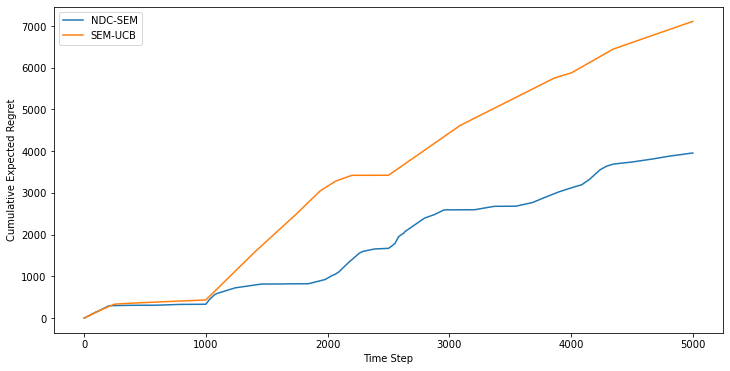

In [37]:
fig = plt.figure(figsize=(12, 6))


plt.plot(np.cumsum(expected_regret[0]), label='NDC-SEM')
plt.plot(np.cumsum(expected_regret_semucb[0]), label='SEM-UCB')



plt.ylabel('Cumulative Expected Regret')
plt.xlabel('Time Step')
plt.legend()
plt.show()

## 3. Acting uniformely at random

In [38]:
# Uniformly at random taken actions 

randomly_taken_actions = create_random_action(n=rounds)
collected_expected_random_rewards = np.zeros((1, rounds))
collected_instantaneous_random_rewards = np.zeros((1, rounds))
expected_random_regret = np.zeros((1, rounds))
instantaneous_random_regret = np.zeros((1, rounds))

for i in range(rounds):
    ch_p_ind = change_point_index(i)
    
    base_reward_i = np.transpose(np.asarray([B[:, i]]))
    
    x_i = np.transpose(np.asarray([randomly_taken_actions[:, i]]))
    
    collected_instantaneous_random_rewards[0, i] = overall_reward(x=x_i, b=base_reward_i, A=w_gt)
    collected_expected_random_rewards[0,i] = overall_reward(x=x_i, b=mean_b_gt[ch_p_ind], A=w_gt)
    expected_random_regret[0, i] = best_expected_reward[ch_p_ind] - collected_expected_random_rewards[0,i] 
    instantaneous_random_regret[0 ,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i, A=w_gt
    ) - collected_instantaneous_random_rewards[0,i]


## 4. Acting based on Chen's algorithm (CUCB)

Acting naively based on Chen algorithm for the y feedbacks

In [39]:
np.random.seed(42)

##################   UCB  function as part of decision making strategy
def UCB_func_chen(t, x, num_plays_state, inst_reward, Delay):
    
    emp_avg_reward_state_builtin = np.zeros((nodes, 1))
    UCB_state_builtin = np.ones((nodes, 1))
    
    delayed_counts_state = np.zeros(nodes) # Denominator of empirical reward
    for k in range(nodes):
        for j in range(t - Delay):
            delayed_counts_state[k] += num_plays_state[k,:,j]
    
    
    emp_avg_reward_state_temp = np.zeros(nodes) # Numerator of emprical reward
    for k in range(nodes):
        for j in range(t - Delay):
            emp_avg_reward_state_temp[k] += inst_reward[k, j] * num_plays_state[k, :, j]
    
    array_indices_of_chosen_base_arms = np.where(x != 0)[0]
    for i in range(array_indices_of_chosen_base_arms.shape[0]):
        j = array_indices_of_chosen_base_arms[i]
        
        if delayed_counts_state[j] != 0:
            emp_avg_reward_state_builtin[j, 0] = emp_avg_reward_state_temp[j] / (delayed_counts_state[j])

            UCB_state_builtin[j, 0] = emp_avg_reward_state_builtin[j, 0] + np.sqrt(
                (3 * np.log(t)) / (2 * (delayed_counts_state[j]))
            )
            UCB_state_builtin[j, 0] = min(1, UCB_state_builtin[j, 0])
        else:
            print(f"The selected arm {j} is not pulled yet")
    ######################################################
    array_indices_of_not_chosen_base_arms = np.where(x == 0)[0]
    for i in range(array_indices_of_not_chosen_base_arms.shape[0]):
        jj = array_indices_of_not_chosen_base_arms[i]
        if delayed_counts_state[jj] != 0:
            emp_avg_reward_state_builtin[jj, 0] = emp_avg_reward_state_temp[jj] / (delayed_counts_state[jj])
            
            UCB_state_builtin[jj, 0] = emp_avg_reward_state_builtin[jj, 0] + np.sqrt(
                (3 * np.log(t )) / (2 * delayed_counts_state[jj])
            )
            UCB_state_builtin[jj, 0] = min(1, UCB_state_builtin[jj, 0])
            
        else:
            print(f"The not selected arm {jj} is not pulled yet")
    
    new_num_plays_state = (np.asanyarray([x])).T.astype(int)
            
    return new_num_plays_state, emp_avg_reward_state_builtin, UCB_state_builtin

In [40]:
collected_expected_rewards_chen = np.zeros((1, rounds))
collected_instantaneous_rewards_chen = np.zeros((1, rounds))
expected_regret_chen = np.zeros((1, rounds))
instantaneous_regret_chen = np.zeros((1, rounds))

num_plays_state_chen = np.zeros((nodes, 1, rounds))
emp_avg_reward_state_chen = np.zeros((nodes, 1, rounds)) 
UCB_state_chen = np.ones((nodes, 1, rounds)) #b_hat = np.ones((nodes,1))


################## initializaion chen ######################

all_actions_taken_chen = create_random_action(n=initial_rounds)

base_reward_0_chen = np.transpose(np.asarray([B[:, 0]]))
x_0_chen = np.transpose(np.asarray([all_actions_taken_chen[:, 0]]))

Y_chen = np.matmul(C_gt, np.multiply(base_reward_0_chen, x_0_chen))


collected_expected_rewards_chen[0, 0] = overall_reward(x=x_0_chen, b=mean_b_gt[0], A=w_gt)
collected_instantaneous_rewards_chen[0, i] = overall_reward(x=x_0_chen, b=base_reward_0_chen, A=w_gt)
expected_regret_chen[0, i] = best_expected_reward[0] - collected_expected_rewards_chen[0, 0]
instantaneous_regret_chen[0, i] = overall_reward(
    x=best_action_choice[0], b=base_reward_0_chen, A=w_gt
) - collected_instantaneous_rewards_chen[0, i]

print('collected reward of round ', 0 , ' is ', collected_expected_rewards_chen[0, 0])
num_plays_state_chen[:,:,0], emp_avg_reward_state_chen[:,:,0], UCB_state_chen[:,:,0] = UCB_func_chen(
    t=0, x=x_0_chen, num_plays_state=num_plays_state_chen, inst_reward=Y_chen, Delay=Delay,
) 

################### acting based on Chen's algorithm ##################

def best_action_Chen(y, s=super_arm_sparsity): 
    ind = np.argsort(y, axis=0)[-s:]
    x = np.zeros((nodes,1))
    for i in range(ind.shape[0]):
        x[ind[i],0]=1
    
    if (y == y[0]).all():
            print(f'All UCBs are same, taking random action')
            np.random.shuffle(x)
    
    return x

#######################################################################

for i in range(1, rounds):
    ch_p_ind = change_point_index(i)
    
    if i < initial_rounds:
        # Use random actions from initialization
        x_i = np.transpose(np.asarray([all_actions_taken_chen[:, i]]))
    else:
        x_i = best_action_Chen(y=UCB_state_chen[:,:, i - 1], s = super_arm_sparsity)
        all_actions_taken_chen = np.concatenate((all_actions_taken_chen, x_i), axis=1)
        
    base_reward_i = np.transpose(np.asarray([B[:,i]]))
    z_i = np.multiply(base_reward_i, x_i)
    y_i = np.matmul(C_gt, z_i)
    
    Y_chen = np.concatenate((Y_chen, y_i), axis=1)
    
    collected_expected_rewards_chen[0, i] = overall_reward(x=x_i, b=mean_b_gt[ch_p_ind], A=w_gt)
    collected_instantaneous_rewards_chen[0, i] = overall_reward(x=x_i, b=base_reward_i, A=w_gt)
    expected_regret_chen[0, i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_chen[0, i]
    instantaneous_regret_chen[0, i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i, A=w_gt
    ) - collected_instantaneous_rewards_chen[0, i]
    
    print(f'collected reward round {i} is: ', collected_expected_rewards_chen[0, i])
    
    (
        num_plays_state_chen[:,:,i],
        emp_avg_reward_state_chen[:,:,i],
        UCB_state_chen[:,:,i],
    ) = UCB_func_chen(
        t=i, x=x_i, num_plays_state=num_plays_state_chen, inst_reward=Y_chen, Delay=Delay,
    )


collected reward of round  0  is  2.613151196914232
The selected arm 1 is not pulled yet
The selected arm 3 is not pulled yet
The selected arm 5 is not pulled yet
The selected arm 8 is not pulled yet
The not selected arm 0 is not pulled yet
The not selected arm 2 is not pulled yet
The not selected arm 4 is not pulled yet
The not selected arm 6 is not pulled yet
The not selected arm 7 is not pulled yet
The not selected arm 9 is not pulled yet
collected reward round 1 is:  2.253369760756507
The selected arm 0 is not pulled yet
The selected arm 1 is not pulled yet
The selected arm 4 is not pulled yet
The selected arm 9 is not pulled yet
The not selected arm 2 is not pulled yet
The not selected arm 3 is not pulled yet
The not selected arm 5 is not pulled yet
The not selected arm 6 is not pulled yet
The not selected arm 7 is not pulled yet
The not selected arm 8 is not pulled yet
collected reward round 2 is:  2.6242342158332383
The selected arm 1 is not pulled yet
The selected arm 2 is not 

collected reward round 323 is:  3.504801499999035
collected reward round 324 is:  3.504801499999035
collected reward round 325 is:  3.504801499999035
collected reward round 326 is:  3.504801499999035
collected reward round 327 is:  3.504801499999035
collected reward round 328 is:  3.504801499999035
collected reward round 329 is:  3.504801499999035
collected reward round 330 is:  3.504801499999035
collected reward round 331 is:  3.504801499999035
collected reward round 332 is:  3.504801499999035
collected reward round 333 is:  3.504801499999035
collected reward round 334 is:  3.504801499999035
collected reward round 335 is:  3.504801499999035
collected reward round 336 is:  3.504801499999035
collected reward round 337 is:  3.504801499999035
collected reward round 338 is:  3.504801499999035
collected reward round 339 is:  3.504801499999035
collected reward round 340 is:  3.504801499999035
collected reward round 341 is:  3.504801499999035
collected reward round 342 is:  3.504801499999035


collected reward round 513 is:  3.504801499999035
collected reward round 514 is:  3.504801499999035
collected reward round 515 is:  3.504801499999035
collected reward round 516 is:  3.504801499999035
collected reward round 517 is:  3.504801499999035
collected reward round 518 is:  3.504801499999035
collected reward round 519 is:  3.504801499999035
collected reward round 520 is:  3.504801499999035
collected reward round 521 is:  3.504801499999035
collected reward round 522 is:  3.504801499999035
collected reward round 523 is:  3.504801499999035
collected reward round 524 is:  3.504801499999035
collected reward round 525 is:  3.504801499999035
collected reward round 526 is:  3.504801499999035
collected reward round 527 is:  3.504801499999035
collected reward round 528 is:  3.504801499999035
collected reward round 529 is:  3.504801499999035
collected reward round 530 is:  3.504801499999035
collected reward round 531 is:  3.504801499999035
collected reward round 532 is:  3.504801499999035


collected reward round 694 is:  3.504801499999035
collected reward round 695 is:  3.504801499999035
collected reward round 696 is:  3.504801499999035
collected reward round 697 is:  3.504801499999035
collected reward round 698 is:  3.504801499999035
collected reward round 699 is:  3.504801499999035
collected reward round 700 is:  3.504801499999035
collected reward round 701 is:  3.504801499999035
collected reward round 702 is:  3.504801499999035
collected reward round 703 is:  3.504801499999035
collected reward round 704 is:  3.504801499999035
collected reward round 705 is:  3.504801499999035
collected reward round 706 is:  3.504801499999035
collected reward round 707 is:  3.504801499999035
collected reward round 708 is:  3.504801499999035
collected reward round 709 is:  3.504801499999035
collected reward round 710 is:  3.504801499999035
collected reward round 711 is:  3.504801499999035
collected reward round 712 is:  3.504801499999035
collected reward round 713 is:  3.504801499999035


collected reward round 871 is:  3.504801499999035
collected reward round 872 is:  3.504801499999035
collected reward round 873 is:  3.504801499999035
collected reward round 874 is:  3.504801499999035
collected reward round 875 is:  3.504801499999035
collected reward round 876 is:  3.504801499999035
collected reward round 877 is:  3.504801499999035
collected reward round 878 is:  3.504801499999035
collected reward round 879 is:  3.504801499999035
collected reward round 880 is:  3.504801499999035
collected reward round 881 is:  3.504801499999035
collected reward round 882 is:  3.504801499999035
collected reward round 883 is:  3.504801499999035
collected reward round 884 is:  3.504801499999035
collected reward round 885 is:  3.504801499999035
collected reward round 886 is:  3.504801499999035
collected reward round 887 is:  3.504801499999035
collected reward round 888 is:  3.504801499999035
collected reward round 889 is:  3.504801499999035
collected reward round 890 is:  3.504801499999035


collected reward round 1044 is:  0.7965173915878101
collected reward round 1045 is:  0.7965173915878101
collected reward round 1046 is:  0.7965173915878101
collected reward round 1047 is:  0.7965173915878101
collected reward round 1048 is:  0.7965173915878101
collected reward round 1049 is:  0.7965173915878101
collected reward round 1050 is:  0.7965173915878101
collected reward round 1051 is:  0.7965173915878101
collected reward round 1052 is:  0.7965173915878101
collected reward round 1053 is:  0.7965173915878101
collected reward round 1054 is:  0.7965173915878101
collected reward round 1055 is:  0.7965173915878101
collected reward round 1056 is:  0.7965173915878101
collected reward round 1057 is:  0.7965173915878101
collected reward round 1058 is:  0.7965173915878101
collected reward round 1059 is:  0.7965173915878101
collected reward round 1060 is:  0.7965173915878101
collected reward round 1061 is:  0.7965173915878101
collected reward round 1062 is:  0.7965173915878101
collected re

collected reward round 1205 is:  0.7965173915878101
collected reward round 1206 is:  0.7965173915878101
collected reward round 1207 is:  0.7965173915878101
collected reward round 1208 is:  0.7965173915878101
collected reward round 1209 is:  0.7965173915878101
collected reward round 1210 is:  0.7965173915878101
collected reward round 1211 is:  0.7965173915878101
collected reward round 1212 is:  0.7965173915878101
collected reward round 1213 is:  0.7965173915878101
collected reward round 1214 is:  0.7965173915878101
collected reward round 1215 is:  0.7965173915878101
collected reward round 1216 is:  0.7965173915878101
collected reward round 1217 is:  0.7965173915878101
collected reward round 1218 is:  0.7965173915878101
collected reward round 1219 is:  0.7965173915878101
collected reward round 1220 is:  0.7965173915878101
collected reward round 1221 is:  0.7965173915878101
collected reward round 1222 is:  0.7965173915878101
collected reward round 1223 is:  0.7965173915878101
collected re

collected reward round 1373 is:  0.7965173915878101
collected reward round 1374 is:  0.7965173915878101
collected reward round 1375 is:  0.7965173915878101
collected reward round 1376 is:  0.7965173915878101
collected reward round 1377 is:  0.7965173915878101
collected reward round 1378 is:  0.7965173915878101
collected reward round 1379 is:  0.7965173915878101
collected reward round 1380 is:  0.7965173915878101
collected reward round 1381 is:  0.7965173915878101
collected reward round 1382 is:  0.7965173915878101
collected reward round 1383 is:  0.7965173915878101
collected reward round 1384 is:  0.7965173915878101
collected reward round 1385 is:  0.7965173915878101
collected reward round 1386 is:  0.7965173915878101
collected reward round 1387 is:  0.7965173915878101
collected reward round 1388 is:  0.7965173915878101
collected reward round 1389 is:  0.7965173915878101
collected reward round 1390 is:  0.7965173915878101
collected reward round 1391 is:  0.7965173915878101
collected re

collected reward round 1538 is:  0.7965173915878101
collected reward round 1539 is:  0.7965173915878101
collected reward round 1540 is:  0.7965173915878101
collected reward round 1541 is:  0.7965173915878101
collected reward round 1542 is:  0.7965173915878101
collected reward round 1543 is:  0.7965173915878101
collected reward round 1544 is:  0.7965173915878101
collected reward round 1545 is:  0.7965173915878101
collected reward round 1546 is:  0.7965173915878101
collected reward round 1547 is:  0.7965173915878101
collected reward round 1548 is:  0.7965173915878101
collected reward round 1549 is:  0.7965173915878101
collected reward round 1550 is:  0.7965173915878101
collected reward round 1551 is:  0.7965173915878101
collected reward round 1552 is:  0.7965173915878101
collected reward round 1553 is:  0.7965173915878101
collected reward round 1554 is:  0.7965173915878101
collected reward round 1555 is:  0.7965173915878101
collected reward round 1556 is:  0.7965173915878101
collected re

collected reward round 1700 is:  0.7965173915878101
collected reward round 1701 is:  0.7965173915878101
collected reward round 1702 is:  0.7965173915878101
collected reward round 1703 is:  0.7965173915878101
collected reward round 1704 is:  0.7965173915878101
collected reward round 1705 is:  0.7965173915878101
collected reward round 1706 is:  0.7965173915878101
collected reward round 1707 is:  0.7965173915878101
collected reward round 1708 is:  0.7965173915878101
collected reward round 1709 is:  0.7965173915878101
collected reward round 1710 is:  0.7965173915878101
collected reward round 1711 is:  0.7965173915878101
collected reward round 1712 is:  0.7965173915878101
collected reward round 1713 is:  0.7965173915878101
collected reward round 1714 is:  0.7965173915878101
collected reward round 1715 is:  0.7965173915878101
collected reward round 1716 is:  0.7965173915878101
collected reward round 1717 is:  0.7965173915878101
collected reward round 1718 is:  0.7965173915878101
collected re

collected reward round 1858 is:  0.7965173915878101
collected reward round 1859 is:  0.7965173915878101
collected reward round 1860 is:  0.7965173915878101
collected reward round 1861 is:  0.7965173915878101
collected reward round 1862 is:  0.7965173915878101
collected reward round 1863 is:  0.7965173915878101
collected reward round 1864 is:  0.7965173915878101
collected reward round 1865 is:  0.7965173915878101
collected reward round 1866 is:  0.7965173915878101
collected reward round 1867 is:  0.7965173915878101
collected reward round 1868 is:  0.7965173915878101
collected reward round 1869 is:  0.7965173915878101
collected reward round 1870 is:  0.7965173915878101
collected reward round 1871 is:  0.7965173915878101
collected reward round 1872 is:  0.7965173915878101
collected reward round 1873 is:  0.7965173915878101
collected reward round 1874 is:  0.7965173915878101
collected reward round 1875 is:  1.5990162708790976
collected reward round 1876 is:  1.5990162708790976
collected re

collected reward round 2020 is:  1.5990162708790976
collected reward round 2021 is:  1.5990162708790976
collected reward round 2022 is:  1.5990162708790976
collected reward round 2023 is:  1.5990162708790976
collected reward round 2024 is:  1.5990162708790976
collected reward round 2025 is:  1.5990162708790976
collected reward round 2026 is:  1.5990162708790976
collected reward round 2027 is:  1.5990162708790976
collected reward round 2028 is:  1.5990162708790976
collected reward round 2029 is:  1.5990162708790976
collected reward round 2030 is:  1.5990162708790976
collected reward round 2031 is:  1.5990162708790976
collected reward round 2032 is:  1.5990162708790976
collected reward round 2033 is:  1.5990162708790976
collected reward round 2034 is:  1.5990162708790976
collected reward round 2035 is:  1.5990162708790976
collected reward round 2036 is:  1.5990162708790976
collected reward round 2037 is:  1.5990162708790976
collected reward round 2038 is:  1.5990162708790976
collected re

collected reward round 2183 is:  1.5990162708790976
collected reward round 2184 is:  1.5990162708790976
collected reward round 2185 is:  1.5990162708790976
collected reward round 2186 is:  1.5990162708790976
collected reward round 2187 is:  1.5990162708790976
collected reward round 2188 is:  1.5990162708790976
collected reward round 2189 is:  1.5990162708790976
collected reward round 2190 is:  1.5990162708790976
collected reward round 2191 is:  1.5990162708790976
collected reward round 2192 is:  1.5222254869320675
collected reward round 2193 is:  1.5222254869320675
collected reward round 2194 is:  1.5222254869320675
collected reward round 2195 is:  1.5222254869320675
collected reward round 2196 is:  1.5222254869320675
collected reward round 2197 is:  1.5222254869320675
collected reward round 2198 is:  1.5222254869320675
collected reward round 2199 is:  1.5222254869320675
collected reward round 2200 is:  1.5222254869320675
collected reward round 2201 is:  1.5222254869320675
collected re

collected reward round 2344 is:  1.6331477873886604
collected reward round 2345 is:  1.6331477873886604
collected reward round 2346 is:  1.6331477873886604
collected reward round 2347 is:  1.6331477873886604
collected reward round 2348 is:  1.6331477873886604
collected reward round 2349 is:  1.6331477873886604
collected reward round 2350 is:  1.6331477873886604
collected reward round 2351 is:  1.6331477873886604
collected reward round 2352 is:  1.6331477873886604
collected reward round 2353 is:  1.6331477873886604
collected reward round 2354 is:  1.6331477873886604
collected reward round 2355 is:  1.6331477873886604
collected reward round 2356 is:  1.6331477873886604
collected reward round 2357 is:  1.6331477873886604
collected reward round 2358 is:  1.6331477873886604
collected reward round 2359 is:  1.6331477873886604
collected reward round 2360 is:  1.6331477873886604
collected reward round 2361 is:  1.6331477873886604
collected reward round 2362 is:  1.6331477873886604
collected re

collected reward round 2506 is:  1.8765215349058142
collected reward round 2507 is:  1.8765215349058142
collected reward round 2508 is:  1.8765215349058142
collected reward round 2509 is:  1.8765215349058142
collected reward round 2510 is:  1.8765215349058142
collected reward round 2511 is:  1.7867010562569918
collected reward round 2512 is:  1.7867010562569918
collected reward round 2513 is:  1.7867010562569918
collected reward round 2514 is:  1.7867010562569918
collected reward round 2515 is:  1.7867010562569918
collected reward round 2516 is:  1.7867010562569918
collected reward round 2517 is:  1.7867010562569918
collected reward round 2518 is:  1.7867010562569918
collected reward round 2519 is:  1.7867010562569918
collected reward round 2520 is:  1.7867010562569918
collected reward round 2521 is:  1.7867010562569918
collected reward round 2522 is:  1.7867010562569918
collected reward round 2523 is:  1.7867010562569918
collected reward round 2524 is:  1.7867010562569918
collected re

collected reward round 2668 is:  4.245814845168295
collected reward round 2669 is:  4.245814845168295
collected reward round 2670 is:  4.245814845168295
collected reward round 2671 is:  4.245814845168295
collected reward round 2672 is:  4.245814845168295
collected reward round 2673 is:  4.245814845168295
collected reward round 2674 is:  4.245814845168295
collected reward round 2675 is:  4.245814845168295
collected reward round 2676 is:  4.245814845168295
collected reward round 2677 is:  4.245814845168295
collected reward round 2678 is:  4.245814845168295
collected reward round 2679 is:  4.245814845168295
collected reward round 2680 is:  4.245814845168295
collected reward round 2681 is:  4.245814845168295
collected reward round 2682 is:  4.245814845168295
collected reward round 2683 is:  4.245814845168295
collected reward round 2684 is:  4.245814845168295
collected reward round 2685 is:  4.245814845168295
collected reward round 2686 is:  4.245814845168295
collected reward round 2687 is:

collected reward round 2830 is:  5.368647026431021
collected reward round 2831 is:  5.368647026431021
collected reward round 2832 is:  5.368647026431021
collected reward round 2833 is:  5.368647026431021
collected reward round 2834 is:  5.368647026431021
collected reward round 2835 is:  5.368647026431021
collected reward round 2836 is:  5.368647026431021
collected reward round 2837 is:  5.368647026431021
collected reward round 2838 is:  5.368647026431021
collected reward round 2839 is:  5.368647026431021
collected reward round 2840 is:  5.368647026431021
collected reward round 2841 is:  5.368647026431021
collected reward round 2842 is:  5.368647026431021
collected reward round 2843 is:  5.368647026431021
collected reward round 2844 is:  5.368647026431021
collected reward round 2845 is:  5.368647026431021
collected reward round 2846 is:  5.368647026431021
collected reward round 2847 is:  5.368647026431021
collected reward round 2848 is:  5.368647026431021
collected reward round 2849 is:

collected reward round 2991 is:  5.368647026431021
collected reward round 2992 is:  5.368647026431021
collected reward round 2993 is:  5.368647026431021
collected reward round 2994 is:  5.368647026431021
collected reward round 2995 is:  5.368647026431021
collected reward round 2996 is:  5.368647026431021
collected reward round 2997 is:  5.368647026431021
collected reward round 2998 is:  5.368647026431021
collected reward round 2999 is:  5.368647026431021
collected reward round 3000 is:  5.368647026431021
collected reward round 3001 is:  5.368647026431021
collected reward round 3002 is:  5.368647026431021
collected reward round 3003 is:  5.368647026431021
collected reward round 3004 is:  5.368647026431021
collected reward round 3005 is:  5.368647026431021
collected reward round 3006 is:  5.368647026431021
collected reward round 3007 is:  5.368647026431021
collected reward round 3008 is:  5.368647026431021
collected reward round 3009 is:  5.368647026431021
collected reward round 3010 is:

collected reward round 3154 is:  5.368647026431021
collected reward round 3155 is:  5.368647026431021
collected reward round 3156 is:  5.368647026431021
collected reward round 3157 is:  5.368647026431021
collected reward round 3158 is:  5.368647026431021
collected reward round 3159 is:  5.368647026431021
collected reward round 3160 is:  5.368647026431021
collected reward round 3161 is:  5.368647026431021
collected reward round 3162 is:  5.368647026431021
collected reward round 3163 is:  5.368647026431021
collected reward round 3164 is:  5.368647026431021
collected reward round 3165 is:  5.368647026431021
collected reward round 3166 is:  5.368647026431021
collected reward round 3167 is:  5.368647026431021
collected reward round 3168 is:  5.368647026431021
collected reward round 3169 is:  5.368647026431021
collected reward round 3170 is:  5.368647026431021
collected reward round 3171 is:  5.368647026431021
collected reward round 3172 is:  5.368647026431021
collected reward round 3173 is:

collected reward round 3318 is:  5.368647026431021
collected reward round 3319 is:  5.368647026431021
collected reward round 3320 is:  5.368647026431021
collected reward round 3321 is:  5.368647026431021
collected reward round 3322 is:  5.368647026431021
collected reward round 3323 is:  5.368647026431021
collected reward round 3324 is:  5.368647026431021
collected reward round 3325 is:  5.368647026431021
collected reward round 3326 is:  5.368647026431021
collected reward round 3327 is:  5.368647026431021
collected reward round 3328 is:  5.368647026431021
collected reward round 3329 is:  5.368647026431021
collected reward round 3330 is:  5.368647026431021
collected reward round 3331 is:  5.368647026431021
collected reward round 3332 is:  5.368647026431021
collected reward round 3333 is:  5.368647026431021
collected reward round 3334 is:  5.368647026431021
collected reward round 3335 is:  5.368647026431021
collected reward round 3336 is:  5.368647026431021
collected reward round 3337 is:

collected reward round 3481 is:  6.005076007069141
collected reward round 3482 is:  6.005076007069141
collected reward round 3483 is:  6.005076007069141
collected reward round 3484 is:  6.005076007069141
collected reward round 3485 is:  6.005076007069141
collected reward round 3486 is:  6.005076007069141
collected reward round 3487 is:  6.005076007069141
collected reward round 3488 is:  6.005076007069141
collected reward round 3489 is:  6.005076007069141
collected reward round 3490 is:  6.005076007069141
collected reward round 3491 is:  6.005076007069141
collected reward round 3492 is:  6.005076007069141
collected reward round 3493 is:  6.005076007069141
collected reward round 3494 is:  6.005076007069141
collected reward round 3495 is:  6.005076007069141
collected reward round 3496 is:  6.005076007069141
collected reward round 3497 is:  6.005076007069141
collected reward round 3498 is:  6.005076007069141
collected reward round 3499 is:  6.005076007069141
collected reward round 3500 is:

collected reward round 3644 is:  6.005076007069141
collected reward round 3645 is:  6.005076007069141
collected reward round 3646 is:  6.005076007069141
collected reward round 3647 is:  6.005076007069141
collected reward round 3648 is:  6.005076007069141
collected reward round 3649 is:  6.005076007069141
collected reward round 3650 is:  6.005076007069141
collected reward round 3651 is:  6.005076007069141
collected reward round 3652 is:  6.005076007069141
collected reward round 3653 is:  6.005076007069141
collected reward round 3654 is:  6.005076007069141
collected reward round 3655 is:  6.005076007069141
collected reward round 3656 is:  6.005076007069141
collected reward round 3657 is:  6.005076007069141
collected reward round 3658 is:  6.005076007069141
collected reward round 3659 is:  6.005076007069141
collected reward round 3660 is:  6.005076007069141
collected reward round 3661 is:  6.005076007069141
collected reward round 3662 is:  6.005076007069141
collected reward round 3663 is:

collected reward round 3805 is:  6.005076007069141
collected reward round 3806 is:  6.005076007069141
collected reward round 3807 is:  6.005076007069141
collected reward round 3808 is:  6.005076007069141
collected reward round 3809 is:  6.005076007069141
collected reward round 3810 is:  6.005076007069141
collected reward round 3811 is:  6.005076007069141
collected reward round 3812 is:  6.005076007069141
collected reward round 3813 is:  6.005076007069141
collected reward round 3814 is:  6.005076007069141
collected reward round 3815 is:  6.005076007069141
collected reward round 3816 is:  6.005076007069141
collected reward round 3817 is:  6.005076007069141
collected reward round 3818 is:  6.005076007069141
collected reward round 3819 is:  6.005076007069141
collected reward round 3820 is:  6.005076007069141
collected reward round 3821 is:  6.005076007069141
collected reward round 3822 is:  6.005076007069141
collected reward round 3823 is:  6.005076007069141
collected reward round 3824 is:

collected reward round 3967 is:  6.005076007069141
collected reward round 3968 is:  6.005076007069141
collected reward round 3969 is:  6.005076007069141
collected reward round 3970 is:  6.005076007069141
collected reward round 3971 is:  6.005076007069141
collected reward round 3972 is:  6.005076007069141
collected reward round 3973 is:  6.005076007069141
collected reward round 3974 is:  6.005076007069141
collected reward round 3975 is:  6.005076007069141
collected reward round 3976 is:  6.005076007069141
collected reward round 3977 is:  6.005076007069141
collected reward round 3978 is:  6.005076007069141
collected reward round 3979 is:  6.005076007069141
collected reward round 3980 is:  6.005076007069141
collected reward round 3981 is:  6.005076007069141
collected reward round 3982 is:  6.005076007069141
collected reward round 3983 is:  6.005076007069141
collected reward round 3984 is:  6.005076007069141
collected reward round 3985 is:  6.005076007069141
collected reward round 3986 is:

collected reward round 4126 is:  1.6851527671370574
collected reward round 4127 is:  1.6851527671370574
collected reward round 4128 is:  1.6851527671370574
collected reward round 4129 is:  1.6851527671370574
collected reward round 4130 is:  1.6851527671370574
collected reward round 4131 is:  1.6851527671370574
collected reward round 4132 is:  1.6851527671370574
collected reward round 4133 is:  1.6851527671370574
collected reward round 4134 is:  1.6851527671370574
collected reward round 4135 is:  1.6851527671370574
collected reward round 4136 is:  1.6851527671370574
collected reward round 4137 is:  1.6851527671370574
collected reward round 4138 is:  1.6851527671370574
collected reward round 4139 is:  1.6851527671370574
collected reward round 4140 is:  1.6851527671370574
collected reward round 4141 is:  1.6851527671370574
collected reward round 4142 is:  1.6851527671370574
collected reward round 4143 is:  1.6851527671370574
collected reward round 4144 is:  1.6851527671370574
collected re

collected reward round 4286 is:  1.6851527671370574
collected reward round 4287 is:  1.6851527671370574
collected reward round 4288 is:  1.6851527671370574
collected reward round 4289 is:  1.6851527671370574
collected reward round 4290 is:  1.6851527671370574
collected reward round 4291 is:  1.6851527671370574
collected reward round 4292 is:  1.6851527671370574
collected reward round 4293 is:  1.6851527671370574
collected reward round 4294 is:  1.6851527671370574
collected reward round 4295 is:  1.6851527671370574
collected reward round 4296 is:  1.6851527671370574
collected reward round 4297 is:  1.6851527671370574
collected reward round 4298 is:  1.6851527671370574
collected reward round 4299 is:  1.6851527671370574
collected reward round 4300 is:  1.6851527671370574
collected reward round 4301 is:  1.6851527671370574
collected reward round 4302 is:  1.6851527671370574
collected reward round 4303 is:  1.6851527671370574
collected reward round 4304 is:  1.6851527671370574
collected re

collected reward round 4445 is:  1.6851527671370574
collected reward round 4446 is:  1.6851527671370574
collected reward round 4447 is:  1.6851527671370574
collected reward round 4448 is:  1.6851527671370574
collected reward round 4449 is:  1.6851527671370574
collected reward round 4450 is:  1.6851527671370574
collected reward round 4451 is:  1.6851527671370574
collected reward round 4452 is:  1.6851527671370574
collected reward round 4453 is:  1.6851527671370574
collected reward round 4454 is:  1.6851527671370574
collected reward round 4455 is:  1.6851527671370574
collected reward round 4456 is:  1.6851527671370574
collected reward round 4457 is:  1.6851527671370574
collected reward round 4458 is:  1.6851527671370574
collected reward round 4459 is:  1.6851527671370574
collected reward round 4460 is:  1.6851527671370574
collected reward round 4461 is:  1.6851527671370574
collected reward round 4462 is:  1.6851527671370574
collected reward round 4463 is:  1.6851527671370574
collected re

collected reward round 4603 is:  1.6851527671370574
collected reward round 4604 is:  1.6851527671370574
collected reward round 4605 is:  1.6851527671370574
collected reward round 4606 is:  1.6851527671370574
collected reward round 4607 is:  1.6851527671370574
collected reward round 4608 is:  1.6851527671370574
collected reward round 4609 is:  1.6851527671370574
collected reward round 4610 is:  1.6851527671370574
collected reward round 4611 is:  1.6851527671370574
collected reward round 4612 is:  1.6851527671370574
collected reward round 4613 is:  1.6851527671370574
collected reward round 4614 is:  1.6851527671370574
collected reward round 4615 is:  1.6851527671370574
collected reward round 4616 is:  1.6851527671370574
collected reward round 4617 is:  1.6851527671370574
collected reward round 4618 is:  1.6851527671370574
collected reward round 4619 is:  1.6851527671370574
collected reward round 4620 is:  1.6851527671370574
collected reward round 4621 is:  1.6851527671370574
collected re

collected reward round 4762 is:  1.6851527671370574
collected reward round 4763 is:  1.6851527671370574
collected reward round 4764 is:  1.6851527671370574
collected reward round 4765 is:  1.6851527671370574
collected reward round 4766 is:  1.6851527671370574
collected reward round 4767 is:  1.6851527671370574
collected reward round 4768 is:  1.6851527671370574
collected reward round 4769 is:  1.6851527671370574
collected reward round 4770 is:  1.6851527671370574
collected reward round 4771 is:  1.6851527671370574
collected reward round 4772 is:  1.6851527671370574
collected reward round 4773 is:  1.6851527671370574
collected reward round 4774 is:  1.6851527671370574
collected reward round 4775 is:  1.6851527671370574
collected reward round 4776 is:  1.6851527671370574
collected reward round 4777 is:  1.6851527671370574
collected reward round 4778 is:  1.6851527671370574
collected reward round 4779 is:  1.6851527671370574
collected reward round 4780 is:  1.6851527671370574
collected re

collected reward round 4920 is:  1.6851527671370574
collected reward round 4921 is:  1.6851527671370574
collected reward round 4922 is:  1.6851527671370574
collected reward round 4923 is:  1.6851527671370574
collected reward round 4924 is:  1.6851527671370574
collected reward round 4925 is:  1.6851527671370574
collected reward round 4926 is:  1.6851527671370574
collected reward round 4927 is:  1.6851527671370574
collected reward round 4928 is:  1.6851527671370574
collected reward round 4929 is:  1.6851527671370574
collected reward round 4930 is:  1.6851527671370574
collected reward round 4931 is:  1.6851527671370574
collected reward round 4932 is:  1.6851527671370574
collected reward round 4933 is:  1.6851527671370574
collected reward round 4934 is:  1.6851527671370574
collected reward round 4935 is:  1.6851527671370574
collected reward round 4936 is:  1.6851527671370574
collected reward round 4937 is:  1.6851527671370574
collected reward round 4938 is:  1.6851527671370574
collected re

## 5. Implementation of CTS with normalized y_{i}

In [41]:
###################### the following must be executed at the beginning of each decision making point 
#posterior_cts = np.zeros((nodes,1))
#for i in range(nodes):
#    posterior_cts[i,0] = np.random.beta(a_it[i,0], b_it[i,0], size=1)
    
############################################ 
# def CTS_update(a_it, b_it, action_vector, x_mean_cts, t, T_cts):

#     action_vector = np.asarray([action_vector]).T 
#     for i in range(nodes):
        
#         if action_vector[i,0]!=0:
#             x_mean_cts[i,0]=(x_mean_cts[i,0] * T_cts[i,0] + B[i,t]) / (T_cts[i,0]+1)
#             T_cts[i,0]+=1
#             temp80 = np.random.binomial(size=1,n=1,p=x_mean_cts[i,0])
#             a_it[i,0] = a_it[i,0] + temp80
#             b_it[i,0] = b_it[i,0] + 1-temp80

#     return a_it, b_it, x_mean_cts, T_cts
    

In [42]:
def biggest_y_i(s=super_arm_sparsity):
    b_max_i = np.transpose(np.asarray([np.amax(B, axis=1)]))
    b_diag = np.diagflat(b_max_i) 
    C = np.matmul(C_gt, b_diag)
    C_sorted = np.sort(C)
    temp_C_biggest = C_sorted[:,-s:]
    temp_biggest_sum = np.cumsum(temp_C_biggest,axis=1)
    y_max_i = (np.transpose(np.asarray([temp_biggest_sum[:,-1]])))
    
    return y_max_i


def best_action_pcts(y, s = super_arm_sparsity): 
    
    ind = np.argsort(y, axis=0)[-s:]
    x = np.zeros((nodes,1))
    for i in range(ind.shape[0]):
        x[ind[i], 0]=1
    
    return x

def PCTS_update(a_it, b_it, action_vector, x_mean_pcts, t, num_plays_state, Delay):
    global Y_pcts_normal 
    
    delayed_counts_state = np.ones(nodes) # Denominator of empirical reward
    for k in range(nodes):
        for j in range(t - Delay):
            delayed_counts_state[k] += num_plays_state[k,:,j]
    
    
    emp_avg_reward_state_temp = np.zeros(nodes) # Numerator of emprical reward
    for k in range(nodes):
        for j in range(t - Delay):
            emp_avg_reward_state_temp[k] += Y_pcts_normal[k, j] * num_plays_state[k, :, j]
    
    
    action_vector = np.asarray([action_vector]).T 
    for i in range(nodes):
        
        if action_vector[i, 0] != 0:            
            x_mean_pcts[i, 0] = emp_avg_reward_state_temp[i] / (delayed_counts_state[i])
            
            temp80 = np.random.binomial(size=1, n=1, p=x_mean_pcts[i,0])
            a_it[i, 0] = a_it[i, 0] + temp80
            b_it[i, 0] = b_it[i, 0] + (1 - temp80)
    
    new_num_plays_state = (np.asanyarray([action_vector])).T.astype(int)
    
    return new_num_plays_state, a_it, b_it, x_mean_pcts

#### acting based on Huyuk's algorithm (CTS) for the y feedbacks


In [43]:
np.random.seed(42)

########## CTS  function as part of decision making strategy ##########################

y_i_max = biggest_y_i();

collected_rewards_pcts = np.zeros((1,rounds)) 

collected_expected_rewards_pcts = np.zeros((1, rounds))
collected_instantaneous_rewards_pcts = np.zeros((1, rounds))
expected_regret_pcts = np.zeros((1, rounds))
instantaneous_regret_pcts = np.zeros((1, rounds))

a_it = np.ones((nodes,1))
b_it = np.ones((nodes,1))
num_plays_state_pcts = np.zeros((nodes, 1, rounds))

################## initial rounds PCTS ######################

all_actions_taken_pcts = create_random_action(n=initial_rounds)
base_reward_0_pcts = np.transpose(np.asarray([B[:,0]]))

x_0_pcts = np.transpose(np.asarray([all_actions_taken_pcts[:,0]]))
z_0_pcts = np.multiply(base_reward_0_pcts, x_0_pcts)
y_0_pcts = np.matmul(C_gt, z_0_pcts)

Y_pcts = y_0_pcts
Y_pcts_normal = np.divide(y_0_pcts, y_i_max)

x_mean_pcts = np.ones((nodes, 1))*0.5 #np.asarray([B[:,0]]).T

#for i in range(Y_pcts.shape[0]):
#    y_hat_pcts[i,0] = Y_pcts[i,0]


collected_expected_rewards_pcts[0,0] = overall_reward(x=x_0_pcts, b=mean_b_gt[0], A=w_gt)
collected_instantaneous_rewards_pcts[0,0] = overall_reward(x=x_0_pcts, b=base_reward_0_pcts, A=w_gt)
expected_regret_pcts[0,0] = best_expected_reward[0] - collected_expected_rewards_pcts[0,0]
instantaneous_regret_pcts[0,0] = overall_reward(
    x=best_action_choice[0], b=base_reward_0_pcts, A=w_gt
) - collected_instantaneous_rewards_pcts[0,0]
print('collected reward of round  ', 0  ,' is: ', collected_expected_rewards_pcts[0,0])


num_plays_state_pcts[:,:,0], a_it, b_it, x_mean_pcts = PCTS_update(
    a_it=a_it, b_it=b_it, action_vector=x_0_pcts.T, 
    x_mean_pcts=x_mean_pcts, t=0, num_plays_state=num_plays_state_pcts, Delay=Delay,
) 

################ initial rounds pcts ######################

for i in range(1, initial_rounds):
    ch_p_ind = change_point_index(i)
    
    base_reward_i_pcts = np.transpose(np.asarray([B[:,i]]))

    x_i_pcts = np.transpose(np.asarray([all_actions_taken_pcts[:,i]]))
    z_i_pcts = np.multiply(base_reward_i_pcts, x_i_pcts)
    y_i_pcts = np.matmul(C_gt, z_i_pcts)
    Y_pcts = np.concatenate((Y_pcts, y_i_pcts), axis=1)
    
    y_i_pcts_normal = np.divide(y_i_pcts, y_i_max)
    Y_pcts_normal = np.concatenate((Y_pcts_normal, y_i_pcts_normal), axis=1)
    
    collected_expected_rewards_pcts[0,i] = overall_reward(x=x_i_pcts, b=mean_b_gt[ch_p_ind], A=w_gt)
    collected_instantaneous_rewards_pcts[0,i] = overall_reward(x=x_i_pcts, b=base_reward_i_pcts, A=w_gt)
    expected_regret_pcts[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_pcts[0,i]
    instantaneous_regret_pcts[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i_pcts, A=w_gt
    ) - collected_instantaneous_rewards_pcts[0,i]
    print('collected reward of round  ', i  ,' is: ', collected_expected_rewards_pcts[0,i])

    
    num_plays_state_pcts[:,:,i], a_it, b_it, x_mean_pcts = PCTS_update(
        a_it=a_it, b_it=b_it, action_vector=x_i_pcts.T,
        x_mean_pcts=x_mean_pcts, t=i, num_plays_state=num_plays_state_pcts, Delay=Delay,
    ) 

################### acting based on CTS algorithm ##################
####################################################################

for i in range(initial_rounds,rounds):
    ch_p_ind = change_point_index(i)
    
#     temporary_pcts = np.multiply(all_actions_taken_pcts,B[:,0:all_actions_taken_pcts.shape[1]])
    posterior_pcts = np.zeros((nodes,1))
    for jj in range(nodes):
        posterior_pcts[jj, 0] = np.random.beta(a_it[jj,0], b_it[jj,0], size=1)
    
    x_i_pcts = best_action_pcts(y=posterior_pcts, s = super_arm_sparsity)
    all_actions_taken_pcts = np.concatenate((all_actions_taken_pcts, x_i_pcts), axis=1)
    
    base_reward_i_pcts = np.transpose(np.asarray([B[:, i]]))
    
    z_i_pcts = np.multiply(base_reward_i_pcts, x_i_pcts)
    y_i_pcts = np.matmul(C_gt, z_i_pcts)
    Y_pcts = np.concatenate((Y_pcts, y_i_pcts), axis=1)
    
    y_i_pcts_normal = np.divide(y_i_pcts, y_i_max)
    Y_pcts_normal = np.concatenate((Y_pcts_normal, y_i_pcts_normal), axis=1)
    
    collected_expected_rewards_pcts[0,i] = overall_reward(x=x_i_pcts, b=mean_b_gt[ch_p_ind], A=w_gt)
    collected_instantaneous_rewards_pcts[0,i] = overall_reward(x=x_i_pcts, b=base_reward_i_pcts, A=w_gt)
    expected_regret_pcts[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_pcts[0,i]
    instantaneous_regret_pcts[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i_pcts, A=w_gt
    ) - collected_instantaneous_rewards_pcts[0,i]
    print('collected reward of round  ', i  ,' is: ', collected_expected_rewards_pcts[0,i])

    num_plays_state_pcts[:,:,i], a_it, b_it, x_mean_pcts = PCTS_update(
        a_it=a_it, b_it=b_it, action_vector=x_i_pcts.T, 
        x_mean_pcts=x_mean_pcts, t=i, num_plays_state=num_plays_state_pcts, Delay=Delay,
    ) 


collected reward of round   0  is:  2.613151196914232
collected reward of round   1  is:  2.253369760756507
collected reward of round   2  is:  2.6242342158332383
collected reward of round   3  is:  2.014751103469163
collected reward of round   4  is:  2.0412780491368276
collected reward of round   5  is:  1.4813326125081514
collected reward of round   6  is:  2.2354934809021114
collected reward of round   7  is:  2.2112768831696514
collected reward of round   8  is:  2.7056026845749868
collected reward of round   9  is:  2.1849328391012026
collected reward of round   10  is:  2.365414983893765
collected reward of round   11  is:  2.064893810329908
collected reward of round   12  is:  2.817647907712245
collected reward of round   13  is:  1.4017967887128737
collected reward of round   14  is:  1.5557057885875
collected reward of round   15  is:  1.9107557096057939
collected reward of round   16  is:  2.744878275729879
collected reward of round   17  is:  3.3105860682337513
collected re

collected reward of round   295  is:  2.8998181163402705
collected reward of round   296  is:  2.8998181163402705
collected reward of round   297  is:  2.8998181163402705
collected reward of round   298  is:  2.8998181163402705
collected reward of round   299  is:  2.8998181163402705
collected reward of round   300  is:  2.8998181163402705
collected reward of round   301  is:  2.8998181163402705
collected reward of round   302  is:  2.8998181163402705
collected reward of round   303  is:  2.8998181163402705
collected reward of round   304  is:  2.8998181163402705
collected reward of round   305  is:  2.8998181163402705
collected reward of round   306  is:  2.8998181163402705
collected reward of round   307  is:  2.8998181163402705
collected reward of round   308  is:  2.8998181163402705
collected reward of round   309  is:  2.8998181163402705
collected reward of round   310  is:  2.8998181163402705
collected reward of round   311  is:  2.8998181163402705
collected reward of round   312

collected reward of round   464  is:  2.8998181163402705
collected reward of round   465  is:  2.8998181163402705
collected reward of round   466  is:  2.8998181163402705
collected reward of round   467  is:  2.8998181163402705
collected reward of round   468  is:  2.8998181163402705
collected reward of round   469  is:  2.8998181163402705
collected reward of round   470  is:  2.8998181163402705
collected reward of round   471  is:  2.8998181163402705
collected reward of round   472  is:  2.8998181163402705
collected reward of round   473  is:  2.8998181163402705
collected reward of round   474  is:  2.8998181163402705
collected reward of round   475  is:  2.8998181163402705
collected reward of round   476  is:  2.8998181163402705
collected reward of round   477  is:  2.8998181163402705
collected reward of round   478  is:  2.8998181163402705
collected reward of round   479  is:  2.8998181163402705
collected reward of round   480  is:  2.8998181163402705
collected reward of round   481

collected reward of round   622  is:  2.8998181163402705
collected reward of round   623  is:  2.8998181163402705
collected reward of round   624  is:  2.8998181163402705
collected reward of round   625  is:  2.8998181163402705
collected reward of round   626  is:  2.8998181163402705
collected reward of round   627  is:  2.8998181163402705
collected reward of round   628  is:  2.8998181163402705
collected reward of round   629  is:  2.8998181163402705
collected reward of round   630  is:  2.8998181163402705
collected reward of round   631  is:  2.8998181163402705
collected reward of round   632  is:  2.8998181163402705
collected reward of round   633  is:  2.8998181163402705
collected reward of round   634  is:  2.8998181163402705
collected reward of round   635  is:  2.8998181163402705
collected reward of round   636  is:  2.8998181163402705
collected reward of round   637  is:  2.8998181163402705
collected reward of round   638  is:  2.8998181163402705
collected reward of round   639

collected reward of round   770  is:  2.8998181163402705
collected reward of round   771  is:  2.8998181163402705
collected reward of round   772  is:  2.8998181163402705
collected reward of round   773  is:  2.8998181163402705
collected reward of round   774  is:  2.8998181163402705
collected reward of round   775  is:  2.8998181163402705
collected reward of round   776  is:  2.8998181163402705
collected reward of round   777  is:  2.8998181163402705
collected reward of round   778  is:  2.8998181163402705
collected reward of round   779  is:  2.8998181163402705
collected reward of round   780  is:  2.8998181163402705
collected reward of round   781  is:  2.8998181163402705
collected reward of round   782  is:  2.8998181163402705
collected reward of round   783  is:  2.8998181163402705
collected reward of round   784  is:  2.8998181163402705
collected reward of round   785  is:  2.8998181163402705
collected reward of round   786  is:  2.8998181163402705
collected reward of round   787

collected reward of round   922  is:  2.8998181163402705
collected reward of round   923  is:  2.8998181163402705
collected reward of round   924  is:  2.8998181163402705
collected reward of round   925  is:  2.8998181163402705
collected reward of round   926  is:  2.8998181163402705
collected reward of round   927  is:  2.8998181163402705
collected reward of round   928  is:  2.8998181163402705
collected reward of round   929  is:  2.8998181163402705
collected reward of round   930  is:  2.8998181163402705
collected reward of round   931  is:  2.8998181163402705
collected reward of round   932  is:  2.8998181163402705
collected reward of round   933  is:  2.8998181163402705
collected reward of round   934  is:  2.8998181163402705
collected reward of round   935  is:  2.8998181163402705
collected reward of round   936  is:  2.8998181163402705
collected reward of round   937  is:  2.8998181163402705
collected reward of round   938  is:  2.8998181163402705
collected reward of round   939

collected reward of round   1073  is:  1.031415279604618
collected reward of round   1074  is:  1.031415279604618
collected reward of round   1075  is:  1.031415279604618
collected reward of round   1076  is:  1.031415279604618
collected reward of round   1077  is:  1.031415279604618
collected reward of round   1078  is:  1.031415279604618
collected reward of round   1079  is:  1.031415279604618
collected reward of round   1080  is:  1.031415279604618
collected reward of round   1081  is:  1.031415279604618
collected reward of round   1082  is:  1.031415279604618
collected reward of round   1083  is:  1.031415279604618
collected reward of round   1084  is:  1.031415279604618
collected reward of round   1085  is:  1.031415279604618
collected reward of round   1086  is:  1.031415279604618
collected reward of round   1087  is:  1.031415279604618
collected reward of round   1088  is:  1.031415279604618
collected reward of round   1089  is:  1.031415279604618
collected reward of round   109

collected reward of round   1220  is:  1.031415279604618
collected reward of round   1221  is:  1.031415279604618
collected reward of round   1222  is:  1.031415279604618
collected reward of round   1223  is:  1.031415279604618
collected reward of round   1224  is:  1.031415279604618
collected reward of round   1225  is:  1.031415279604618
collected reward of round   1226  is:  1.031415279604618
collected reward of round   1227  is:  1.031415279604618
collected reward of round   1228  is:  1.031415279604618
collected reward of round   1229  is:  1.031415279604618
collected reward of round   1230  is:  1.031415279604618
collected reward of round   1231  is:  1.031415279604618
collected reward of round   1232  is:  1.031415279604618
collected reward of round   1233  is:  1.031415279604618
collected reward of round   1234  is:  1.031415279604618
collected reward of round   1235  is:  1.031415279604618
collected reward of round   1236  is:  1.031415279604618
collected reward of round   123

collected reward of round   1367  is:  1.031415279604618
collected reward of round   1368  is:  1.031415279604618
collected reward of round   1369  is:  1.031415279604618
collected reward of round   1370  is:  1.031415279604618
collected reward of round   1371  is:  1.031415279604618
collected reward of round   1372  is:  1.031415279604618
collected reward of round   1373  is:  1.031415279604618
collected reward of round   1374  is:  1.031415279604618
collected reward of round   1375  is:  1.031415279604618
collected reward of round   1376  is:  1.031415279604618
collected reward of round   1377  is:  1.031415279604618
collected reward of round   1378  is:  1.031415279604618
collected reward of round   1379  is:  1.031415279604618
collected reward of round   1380  is:  1.031415279604618
collected reward of round   1381  is:  1.031415279604618
collected reward of round   1382  is:  1.031415279604618
collected reward of round   1383  is:  1.031415279604618
collected reward of round   138

collected reward of round   1513  is:  1.031415279604618
collected reward of round   1514  is:  1.031415279604618
collected reward of round   1515  is:  1.031415279604618
collected reward of round   1516  is:  1.031415279604618
collected reward of round   1517  is:  1.031415279604618
collected reward of round   1518  is:  1.031415279604618
collected reward of round   1519  is:  1.031415279604618
collected reward of round   1520  is:  1.031415279604618
collected reward of round   1521  is:  1.031415279604618
collected reward of round   1522  is:  1.031415279604618
collected reward of round   1523  is:  1.031415279604618
collected reward of round   1524  is:  1.031415279604618
collected reward of round   1525  is:  1.031415279604618
collected reward of round   1526  is:  1.031415279604618
collected reward of round   1527  is:  1.031415279604618
collected reward of round   1528  is:  1.031415279604618
collected reward of round   1529  is:  1.031415279604618
collected reward of round   153

collected reward of round   1658  is:  1.031415279604618
collected reward of round   1659  is:  1.031415279604618
collected reward of round   1660  is:  1.031415279604618
collected reward of round   1661  is:  1.031415279604618
collected reward of round   1662  is:  1.031415279604618
collected reward of round   1663  is:  1.031415279604618
collected reward of round   1664  is:  1.031415279604618
collected reward of round   1665  is:  1.031415279604618
collected reward of round   1666  is:  1.031415279604618
collected reward of round   1667  is:  1.031415279604618
collected reward of round   1668  is:  1.031415279604618
collected reward of round   1669  is:  1.031415279604618
collected reward of round   1670  is:  1.031415279604618
collected reward of round   1671  is:  1.031415279604618
collected reward of round   1672  is:  1.031415279604618
collected reward of round   1673  is:  1.031415279604618
collected reward of round   1674  is:  1.031415279604618
collected reward of round   167

collected reward of round   1805  is:  1.031415279604618
collected reward of round   1806  is:  1.031415279604618
collected reward of round   1807  is:  1.031415279604618
collected reward of round   1808  is:  1.031415279604618
collected reward of round   1809  is:  1.031415279604618
collected reward of round   1810  is:  1.031415279604618
collected reward of round   1811  is:  1.031415279604618
collected reward of round   1812  is:  1.031415279604618
collected reward of round   1813  is:  1.031415279604618
collected reward of round   1814  is:  1.031415279604618
collected reward of round   1815  is:  1.031415279604618
collected reward of round   1816  is:  1.031415279604618
collected reward of round   1817  is:  1.031415279604618
collected reward of round   1818  is:  1.031415279604618
collected reward of round   1819  is:  1.031415279604618
collected reward of round   1820  is:  1.031415279604618
collected reward of round   1821  is:  1.031415279604618
collected reward of round   182

collected reward of round   1950  is:  1.031415279604618
collected reward of round   1951  is:  1.031415279604618
collected reward of round   1952  is:  1.031415279604618
collected reward of round   1953  is:  1.031415279604618
collected reward of round   1954  is:  1.031415279604618
collected reward of round   1955  is:  1.031415279604618
collected reward of round   1956  is:  1.031415279604618
collected reward of round   1957  is:  1.031415279604618
collected reward of round   1958  is:  1.031415279604618
collected reward of round   1959  is:  1.031415279604618
collected reward of round   1960  is:  1.031415279604618
collected reward of round   1961  is:  1.031415279604618
collected reward of round   1962  is:  1.031415279604618
collected reward of round   1963  is:  1.031415279604618
collected reward of round   1964  is:  1.031415279604618
collected reward of round   1965  is:  1.031415279604618
collected reward of round   1966  is:  1.031415279604618
collected reward of round   196

collected reward of round   2095  is:  1.031415279604618
collected reward of round   2096  is:  1.031415279604618
collected reward of round   2097  is:  1.031415279604618
collected reward of round   2098  is:  1.031415279604618
collected reward of round   2099  is:  1.031415279604618
collected reward of round   2100  is:  1.031415279604618
collected reward of round   2101  is:  1.031415279604618
collected reward of round   2102  is:  1.031415279604618
collected reward of round   2103  is:  1.031415279604618
collected reward of round   2104  is:  1.031415279604618
collected reward of round   2105  is:  1.031415279604618
collected reward of round   2106  is:  1.031415279604618
collected reward of round   2107  is:  1.031415279604618
collected reward of round   2108  is:  1.031415279604618
collected reward of round   2109  is:  1.031415279604618
collected reward of round   2110  is:  1.031415279604618
collected reward of round   2111  is:  1.031415279604618
collected reward of round   211

collected reward of round   2241  is:  1.031415279604618
collected reward of round   2242  is:  1.031415279604618
collected reward of round   2243  is:  1.031415279604618
collected reward of round   2244  is:  1.031415279604618
collected reward of round   2245  is:  1.031415279604618
collected reward of round   2246  is:  1.031415279604618
collected reward of round   2247  is:  1.031415279604618
collected reward of round   2248  is:  1.031415279604618
collected reward of round   2249  is:  1.031415279604618
collected reward of round   2250  is:  1.031415279604618
collected reward of round   2251  is:  1.031415279604618
collected reward of round   2252  is:  1.031415279604618
collected reward of round   2253  is:  1.031415279604618
collected reward of round   2254  is:  1.031415279604618
collected reward of round   2255  is:  1.031415279604618
collected reward of round   2256  is:  1.031415279604618
collected reward of round   2257  is:  1.031415279604618
collected reward of round   225

collected reward of round   2389  is:  1.031415279604618
collected reward of round   2390  is:  1.031415279604618
collected reward of round   2391  is:  1.031415279604618
collected reward of round   2392  is:  1.031415279604618
collected reward of round   2393  is:  1.031415279604618
collected reward of round   2394  is:  1.031415279604618
collected reward of round   2395  is:  1.031415279604618
collected reward of round   2396  is:  1.031415279604618
collected reward of round   2397  is:  1.031415279604618
collected reward of round   2398  is:  1.031415279604618
collected reward of round   2399  is:  1.031415279604618
collected reward of round   2400  is:  1.031415279604618
collected reward of round   2401  is:  1.031415279604618
collected reward of round   2402  is:  1.031415279604618
collected reward of round   2403  is:  1.031415279604618
collected reward of round   2404  is:  1.031415279604618
collected reward of round   2405  is:  1.031415279604618
collected reward of round   240

collected reward of round   2533  is:  2.954898511260553
collected reward of round   2534  is:  2.954898511260553
collected reward of round   2535  is:  2.954898511260553
collected reward of round   2536  is:  2.954898511260553
collected reward of round   2537  is:  2.954898511260553
collected reward of round   2538  is:  2.954898511260553
collected reward of round   2539  is:  2.954898511260553
collected reward of round   2540  is:  2.954898511260553
collected reward of round   2541  is:  2.954898511260553
collected reward of round   2542  is:  2.954898511260553
collected reward of round   2543  is:  2.954898511260553
collected reward of round   2544  is:  2.954898511260553
collected reward of round   2545  is:  2.954898511260553
collected reward of round   2546  is:  2.954898511260553
collected reward of round   2547  is:  2.954898511260553
collected reward of round   2548  is:  2.954898511260553
collected reward of round   2549  is:  2.954898511260553
collected reward of round   255

collected reward of round   2678  is:  2.954898511260553
collected reward of round   2679  is:  2.954898511260553
collected reward of round   2680  is:  2.954898511260553
collected reward of round   2681  is:  2.954898511260553
collected reward of round   2682  is:  2.954898511260553
collected reward of round   2683  is:  2.954898511260553
collected reward of round   2684  is:  2.954898511260553
collected reward of round   2685  is:  2.954898511260553
collected reward of round   2686  is:  2.954898511260553
collected reward of round   2687  is:  2.954898511260553
collected reward of round   2688  is:  2.954898511260553
collected reward of round   2689  is:  2.954898511260553
collected reward of round   2690  is:  2.954898511260553
collected reward of round   2691  is:  2.954898511260553
collected reward of round   2692  is:  2.954898511260553
collected reward of round   2693  is:  2.954898511260553
collected reward of round   2694  is:  2.954898511260553
collected reward of round   269

collected reward of round   2825  is:  2.954898511260553
collected reward of round   2826  is:  2.954898511260553
collected reward of round   2827  is:  2.954898511260553
collected reward of round   2828  is:  2.954898511260553
collected reward of round   2829  is:  2.954898511260553
collected reward of round   2830  is:  2.954898511260553
collected reward of round   2831  is:  2.954898511260553
collected reward of round   2832  is:  2.954898511260553
collected reward of round   2833  is:  2.954898511260553
collected reward of round   2834  is:  2.954898511260553
collected reward of round   2835  is:  2.954898511260553
collected reward of round   2836  is:  2.954898511260553
collected reward of round   2837  is:  2.954898511260553
collected reward of round   2838  is:  2.954898511260553
collected reward of round   2839  is:  2.954898511260553
collected reward of round   2840  is:  2.954898511260553
collected reward of round   2841  is:  2.954898511260553
collected reward of round   284

collected reward of round   2970  is:  2.954898511260553
collected reward of round   2971  is:  2.954898511260553
collected reward of round   2972  is:  2.954898511260553
collected reward of round   2973  is:  2.954898511260553
collected reward of round   2974  is:  2.954898511260553
collected reward of round   2975  is:  2.954898511260553
collected reward of round   2976  is:  2.954898511260553
collected reward of round   2977  is:  2.954898511260553
collected reward of round   2978  is:  2.954898511260553
collected reward of round   2979  is:  2.954898511260553
collected reward of round   2980  is:  2.954898511260553
collected reward of round   2981  is:  2.954898511260553
collected reward of round   2982  is:  2.954898511260553
collected reward of round   2983  is:  2.954898511260553
collected reward of round   2984  is:  2.954898511260553
collected reward of round   2985  is:  2.954898511260553
collected reward of round   2986  is:  2.954898511260553
collected reward of round   298

collected reward of round   3116  is:  2.954898511260553
collected reward of round   3117  is:  2.954898511260553
collected reward of round   3118  is:  2.954898511260553
collected reward of round   3119  is:  2.954898511260553
collected reward of round   3120  is:  2.954898511260553
collected reward of round   3121  is:  2.954898511260553
collected reward of round   3122  is:  2.954898511260553
collected reward of round   3123  is:  2.954898511260553
collected reward of round   3124  is:  2.954898511260553
collected reward of round   3125  is:  2.954898511260553
collected reward of round   3126  is:  2.954898511260553
collected reward of round   3127  is:  2.954898511260553
collected reward of round   3128  is:  2.954898511260553
collected reward of round   3129  is:  2.954898511260553
collected reward of round   3130  is:  2.954898511260553
collected reward of round   3131  is:  2.954898511260553
collected reward of round   3132  is:  2.954898511260553
collected reward of round   313

collected reward of round   3261  is:  2.954898511260553
collected reward of round   3262  is:  2.954898511260553
collected reward of round   3263  is:  2.954898511260553
collected reward of round   3264  is:  2.954898511260553
collected reward of round   3265  is:  2.954898511260553
collected reward of round   3266  is:  2.954898511260553
collected reward of round   3267  is:  2.954898511260553
collected reward of round   3268  is:  2.954898511260553
collected reward of round   3269  is:  2.954898511260553
collected reward of round   3270  is:  2.954898511260553
collected reward of round   3271  is:  2.954898511260553
collected reward of round   3272  is:  2.954898511260553
collected reward of round   3273  is:  2.954898511260553
collected reward of round   3274  is:  2.954898511260553
collected reward of round   3275  is:  2.954898511260553
collected reward of round   3276  is:  2.954898511260553
collected reward of round   3277  is:  2.954898511260553
collected reward of round   327

collected reward of round   3405  is:  2.954898511260553
collected reward of round   3406  is:  2.954898511260553
collected reward of round   3407  is:  2.954898511260553
collected reward of round   3408  is:  2.954898511260553
collected reward of round   3409  is:  2.954898511260553
collected reward of round   3410  is:  2.954898511260553
collected reward of round   3411  is:  2.954898511260553
collected reward of round   3412  is:  2.954898511260553
collected reward of round   3413  is:  2.954898511260553
collected reward of round   3414  is:  2.954898511260553
collected reward of round   3415  is:  2.954898511260553
collected reward of round   3416  is:  2.954898511260553
collected reward of round   3417  is:  2.954898511260553
collected reward of round   3418  is:  2.954898511260553
collected reward of round   3419  is:  2.954898511260553
collected reward of round   3420  is:  2.954898511260553
collected reward of round   3421  is:  2.954898511260553
collected reward of round   342

collected reward of round   3549  is:  2.954898511260553
collected reward of round   3550  is:  2.954898511260553
collected reward of round   3551  is:  2.954898511260553
collected reward of round   3552  is:  2.954898511260553
collected reward of round   3553  is:  2.954898511260553
collected reward of round   3554  is:  2.954898511260553
collected reward of round   3555  is:  2.954898511260553
collected reward of round   3556  is:  2.954898511260553
collected reward of round   3557  is:  2.954898511260553
collected reward of round   3558  is:  2.954898511260553
collected reward of round   3559  is:  2.954898511260553
collected reward of round   3560  is:  2.954898511260553
collected reward of round   3561  is:  2.954898511260553
collected reward of round   3562  is:  2.954898511260553
collected reward of round   3563  is:  2.954898511260553
collected reward of round   3564  is:  2.954898511260553
collected reward of round   3565  is:  2.954898511260553
collected reward of round   356

collected reward of round   3694  is:  2.954898511260553
collected reward of round   3695  is:  2.954898511260553
collected reward of round   3696  is:  2.954898511260553
collected reward of round   3697  is:  2.954898511260553
collected reward of round   3698  is:  2.954898511260553
collected reward of round   3699  is:  2.954898511260553
collected reward of round   3700  is:  2.954898511260553
collected reward of round   3701  is:  2.954898511260553
collected reward of round   3702  is:  2.954898511260553
collected reward of round   3703  is:  2.954898511260553
collected reward of round   3704  is:  2.954898511260553
collected reward of round   3705  is:  2.954898511260553
collected reward of round   3706  is:  2.954898511260553
collected reward of round   3707  is:  2.954898511260553
collected reward of round   3708  is:  2.954898511260553
collected reward of round   3709  is:  2.954898511260553
collected reward of round   3710  is:  2.954898511260553
collected reward of round   371

collected reward of round   3840  is:  2.954898511260553
collected reward of round   3841  is:  2.954898511260553
collected reward of round   3842  is:  2.954898511260553
collected reward of round   3843  is:  2.954898511260553
collected reward of round   3844  is:  2.954898511260553
collected reward of round   3845  is:  2.954898511260553
collected reward of round   3846  is:  2.954898511260553
collected reward of round   3847  is:  2.954898511260553
collected reward of round   3848  is:  2.954898511260553
collected reward of round   3849  is:  2.954898511260553
collected reward of round   3850  is:  2.954898511260553
collected reward of round   3851  is:  2.954898511260553
collected reward of round   3852  is:  2.954898511260553
collected reward of round   3853  is:  2.954898511260553
collected reward of round   3854  is:  2.954898511260553
collected reward of round   3855  is:  2.954898511260553
collected reward of round   3856  is:  2.954898511260553
collected reward of round   385

collected reward of round   3984  is:  2.954898511260553
collected reward of round   3985  is:  2.954898511260553
collected reward of round   3986  is:  2.954898511260553
collected reward of round   3987  is:  2.954898511260553
collected reward of round   3988  is:  2.954898511260553
collected reward of round   3989  is:  2.954898511260553
collected reward of round   3990  is:  2.954898511260553
collected reward of round   3991  is:  2.954898511260553
collected reward of round   3992  is:  2.954898511260553
collected reward of round   3993  is:  2.954898511260553
collected reward of round   3994  is:  2.954898511260553
collected reward of round   3995  is:  2.954898511260553
collected reward of round   3996  is:  2.954898511260553
collected reward of round   3997  is:  2.954898511260553
collected reward of round   3998  is:  2.954898511260553
collected reward of round   3999  is:  2.954898511260553
collected reward of round   4000  is:  1.5682022200780934
collected reward of round   40

collected reward of round   4128  is:  1.5682022200780934
collected reward of round   4129  is:  1.5682022200780934
collected reward of round   4130  is:  1.5682022200780934
collected reward of round   4131  is:  1.5682022200780934
collected reward of round   4132  is:  1.5682022200780934
collected reward of round   4133  is:  1.5682022200780934
collected reward of round   4134  is:  1.5682022200780934
collected reward of round   4135  is:  1.5682022200780934
collected reward of round   4136  is:  1.5682022200780934
collected reward of round   4137  is:  1.5682022200780934
collected reward of round   4138  is:  1.5682022200780934
collected reward of round   4139  is:  1.5682022200780934
collected reward of round   4140  is:  1.5682022200780934
collected reward of round   4141  is:  1.5682022200780934
collected reward of round   4142  is:  1.5682022200780934
collected reward of round   4143  is:  1.5682022200780934
collected reward of round   4144  is:  1.5682022200780934
collected rewa

collected reward of round   4272  is:  1.5682022200780934
collected reward of round   4273  is:  1.5682022200780934
collected reward of round   4274  is:  1.5682022200780934
collected reward of round   4275  is:  1.5682022200780934
collected reward of round   4276  is:  1.5682022200780934
collected reward of round   4277  is:  1.5682022200780934
collected reward of round   4278  is:  1.5682022200780934
collected reward of round   4279  is:  1.5682022200780934
collected reward of round   4280  is:  1.5682022200780934
collected reward of round   4281  is:  1.5682022200780934
collected reward of round   4282  is:  1.5682022200780934
collected reward of round   4283  is:  1.5682022200780934
collected reward of round   4284  is:  1.5682022200780934
collected reward of round   4285  is:  1.5682022200780934
collected reward of round   4286  is:  1.5682022200780934
collected reward of round   4287  is:  1.5682022200780934
collected reward of round   4288  is:  1.5682022200780934
collected rewa

collected reward of round   4416  is:  1.5682022200780934
collected reward of round   4417  is:  1.5682022200780934
collected reward of round   4418  is:  1.5682022200780934
collected reward of round   4419  is:  1.5682022200780934
collected reward of round   4420  is:  1.5682022200780934
collected reward of round   4421  is:  1.5682022200780934
collected reward of round   4422  is:  1.5682022200780934
collected reward of round   4423  is:  1.5682022200780934
collected reward of round   4424  is:  1.5682022200780934
collected reward of round   4425  is:  1.5682022200780934
collected reward of round   4426  is:  1.5682022200780934
collected reward of round   4427  is:  1.5682022200780934
collected reward of round   4428  is:  1.5682022200780934
collected reward of round   4429  is:  1.5682022200780934
collected reward of round   4430  is:  1.5682022200780934
collected reward of round   4431  is:  1.5682022200780934
collected reward of round   4432  is:  1.5682022200780934
collected rewa

collected reward of round   4560  is:  1.5682022200780934
collected reward of round   4561  is:  1.5682022200780934
collected reward of round   4562  is:  1.5682022200780934
collected reward of round   4563  is:  1.5682022200780934
collected reward of round   4564  is:  1.5682022200780934
collected reward of round   4565  is:  1.5682022200780934
collected reward of round   4566  is:  1.5682022200780934
collected reward of round   4567  is:  1.5682022200780934
collected reward of round   4568  is:  1.5682022200780934
collected reward of round   4569  is:  1.5682022200780934
collected reward of round   4570  is:  1.5682022200780934
collected reward of round   4571  is:  1.5682022200780934
collected reward of round   4572  is:  1.5682022200780934
collected reward of round   4573  is:  1.5682022200780934
collected reward of round   4574  is:  1.5682022200780934
collected reward of round   4575  is:  1.5682022200780934
collected reward of round   4576  is:  1.5682022200780934
collected rewa

collected reward of round   4702  is:  1.5682022200780934
collected reward of round   4703  is:  1.5682022200780934
collected reward of round   4704  is:  1.5682022200780934
collected reward of round   4705  is:  1.5682022200780934
collected reward of round   4706  is:  1.5682022200780934
collected reward of round   4707  is:  1.5682022200780934
collected reward of round   4708  is:  1.5682022200780934
collected reward of round   4709  is:  1.5682022200780934
collected reward of round   4710  is:  1.5682022200780934
collected reward of round   4711  is:  1.5682022200780934
collected reward of round   4712  is:  1.5682022200780934
collected reward of round   4713  is:  1.5682022200780934
collected reward of round   4714  is:  1.5682022200780934
collected reward of round   4715  is:  1.5682022200780934
collected reward of round   4716  is:  1.5682022200780934
collected reward of round   4717  is:  1.5682022200780934
collected reward of round   4718  is:  1.5682022200780934
collected rewa

collected reward of round   4846  is:  1.5682022200780934
collected reward of round   4847  is:  1.5682022200780934
collected reward of round   4848  is:  1.5682022200780934
collected reward of round   4849  is:  1.5682022200780934
collected reward of round   4850  is:  1.5682022200780934
collected reward of round   4851  is:  1.5682022200780934
collected reward of round   4852  is:  1.5682022200780934
collected reward of round   4853  is:  1.5682022200780934
collected reward of round   4854  is:  1.5682022200780934
collected reward of round   4855  is:  1.5682022200780934
collected reward of round   4856  is:  1.5682022200780934
collected reward of round   4857  is:  1.5682022200780934
collected reward of round   4858  is:  1.5682022200780934
collected reward of round   4859  is:  1.5682022200780934
collected reward of round   4860  is:  1.5682022200780934
collected reward of round   4861  is:  1.5682022200780934
collected reward of round   4862  is:  1.5682022200780934
collected rewa

collected reward of round   4988  is:  1.5682022200780934
collected reward of round   4989  is:  1.5682022200780934
collected reward of round   4990  is:  1.5682022200780934
collected reward of round   4991  is:  1.5682022200780934
collected reward of round   4992  is:  1.5682022200780934
collected reward of round   4993  is:  1.5682022200780934
collected reward of round   4994  is:  1.5682022200780934
collected reward of round   4995  is:  1.5682022200780934
collected reward of round   4996  is:  1.5682022200780934
collected reward of round   4997  is:  1.5682022200780934
collected reward of round   4998  is:  1.5682022200780934
collected reward of round   4999  is:  1.5682022200780934


## 5. FTRL with hybrid regularizer in Zimmert's paper 

In [44]:
################## initial rounds ######################

y_i_max = biggest_y_i()

collected_expected_rewards_zimmer = np.zeros((1,rounds))
collected_instantaneous_rewards_zimmer = np.zeros((1,rounds))
expected_regret_zimmer = np.zeros((1,rounds))
instantaneous_regret_zimmer = np.zeros((1,rounds))

loss_zimmer = np.zeros((nodes, rounds))
feedback_zimmer = np.zeros((nodes, rounds))
L_zimmer = np.zeros((nodes,1))

##########################################

In [45]:
6#  Optimization problem

def FTRL(L_zimmer, t, gamma, s=super_arm_sparsity):

    x        = cp.Variable((nodes, 1))
    #temp_mag = cp.atoms.elementwise.abs.abs(1-x)
    #temp_12  = cp.atoms.elementwise.log.log(temp_mag)
    #temp_11  = cp.atoms.affine.binary_operators.multiply(temp_mag,temp_12)
    temp_10  = cp.atoms.elementwise.entr.entr(1 - x)
    
    
    temp_reg = -1 * cp.atoms.elementwise.sqrt.sqrt(x) - gamma * temp_10
    
    reg      = cp.sum(temp_reg)
    temp_obj = cp.sum(cp.multiply(x[:, 0], L_zimmer[:, 0]))
    cost     = temp_obj + np.sqrt(t)*reg
    obj      = cp.Minimize(cost)
    constr   = [cp.sum(x) == s,x >= 0,x <= 1]
    prob     = cp.Problem(obj,constr)
    opt_val  = prob.solve()
    x_output = x.value

    return x_output
	
def best_action_zimmer(x):
    best_action = np.zeros((nodes,1))
    for i in range(len(x)):
        k = x[i]
        best_action[k,0] = 1
        
    return best_action

def L_update(x, feedback, L_zimmer=L_zimmer):
    
    for i in range(x.shape[0]):
        if x[i,0] > 10E-6:
            L_temp = ((feedback[i] + 1) / x[i,0]) - 1
            L_zimmer[i, 0] += L_temp
    return L_zimmer

In [46]:
EPS = 10E-12
#d = # this is the dimension of the vector that is the result of the optimization problem
#m = # this is the number of elements we want to pick at last
''' The following function gets the result of the optimization problem as its input and returns a 
list containing the indices of the arms that are supposed to be sampled accroding to the sampling rule'''
#x = # this is an array of shape (d,)

def sample_action(x):
    # m-set problem
    m = super_arm_sparsity
    d = nodes
    order = np.argsort(-x) # index of the decreasing order of elements
    included = np.copy(x[order]) # copies the ordered values of 'x' into 'included' 
    remaining = 1.0 - included 
    outer_samples = [w for w in split_sample(included, remaining)]          
    weights = list(map(lambda x: x[0], outer_samples))  
    weights = np.asarray(weights)
    weights = np.where(weights<0,0,weights)
    #print('The cummulative sum is ', np.max(np.cumsum(weights)))
    if np.max(np.cumsum(weights))>1.0:
        temp_s_1 = np.argsort(weights)
        temp_s_2 = temp_s_1[-1]
        weights[temp_s_2] = weights[temp_s_2]-(np.max(np.cumsum(weights))-1.0)
        #print('The cummulative sum is ', np.max(np.cumsum(weights)))
    weights = list(weights)
    '''
    here in the above line we take the weights that the function split_sample extracted for us and 
    use it in the next line 
    '''
    _, left, right = outer_samples[np.random.choice(len(outer_samples), p=weights)]  
    # probabilities in weights must sum up to one 
    # for the function np.random.choice the first and the second argument must have the same size 
    
    if left == right - 1:
        sample = range(m)
    else:
        candidates = [i for i in range(left, right)]  
        np.random.shuffle(candidates)  
        sample = [i for i in range(left)] + candidates[:m - left]  
    action = [order[i] for i in sample] # 
    return action


def split_sample(included, remaining):
    m = super_arm_sparsity
    d = nodes
    prop = 1.0
    left, right = 0, nodes
    i = nodes
    while left < right:
        i -= 1
        active = (m - left) / (right - left)
        inactive = 1.0 - active
        if active == 0 or inactive == 0:

            yield (prop, left, right) 
            return   
        weight = min(included[right - 1] / active, remaining[left] / inactive) 
        yield weight, left, right 
        prop -= weight 
        assert prop >= -EPS  
        included -= weight * active
        remaining -= weight * inactive
        while right > 0 and included[right - 1] <= EPS:
            right -= 1
        while left < d and remaining[left] <= EPS:
            left += 1
        assert right - left <= i 
        
    if prop > 0.0:
        yield (prop, m, m + 1)

In [47]:
np.random.seed(42)

# For the initialization phase 

all_actions_zimmer = np.zeros((nodes, initial_rounds))
for i in range(initial_rounds):
    temp_z_1 = np.asarray(
        [all_actions_zimmer[:,i]]
    ) + create_random_action(number_of_chosen_arms=super_arm_sparsity,n=1)
    all_actions_zimmer[:,i] = temp_z_1[:,0]
# np.where(all_actions_zimmer==0,0,1)
for i in range(nodes):
    all_actions_zimmer[i, i]=1
    
#########################################

base_reward_0_zimmer = np.transpose(np.asarray([B[:, 0]]))
x_0_zimmer = np.transpose(np.asarray([all_actions_zimmer[:, 0]]))
z_0_zimmer = np.multiply(base_reward_0_zimmer, x_0_zimmer)

Y = np.matmul(C_gt, z_0_zimmer)
Y_N = np.divide(Y, y_i_max)
loss_zimmer[:, 0] = 1 - Y_N[:,0]
#print('1 is ',x_0_zimmer.shape)
#print('2 is ',loss_zimmer[:,0].shape)
feedback_zimmer[:, 0] = np.multiply(loss_zimmer[:, 0], x_0_zimmer[:, 0])

collected_expected_rewards_zimmer[0,0] = overall_reward(x=x_0_zimmer, b=mean_b_gt[0], A=w_gt)
collected_instantaneous_rewards_zimmer[0,0] = overall_reward(x=x_0_zimmer, b=base_reward_0_zimmer, A=w_gt)
print('collected reward of round ', 0 , ' is ', collected_expected_rewards_zimmer[0,0])
expected_regret_zimmer[0,0] = best_expected_reward[0] - collected_expected_rewards_zimmer[0,0]
instantaneous_regret_zimmer[0,0] = overall_reward(
    x=best_action_choice[0], b=base_reward_0_zimmer, A=w_gt
) - collected_instantaneous_rewards_zimmer[0, 0]

################ initial rounds ######################

for i in range(1,initial_rounds):
    ch_p_ind = change_point_index(i)
    
    base_reward_i_zimmer = np.transpose(np.asarray([B[:,i]]))
    x_i_zimmer = np.transpose(np.asarray([all_actions_zimmer[:,i]]))
    z_i_zimmer = np.multiply(base_reward_i_zimmer, x_i_zimmer)
    y_i_zimmer = np.matmul(C_gt, z_i_zimmer)
    Y = np.concatenate((Y,y_i_zimmer), axis=1)
    
    y_i_zimmer_normal = np.divide(y_i_zimmer, y_i_max)
    Y_N = np.concatenate((Y_N, y_i_zimmer_normal),axis=1) 
    
    loss_zimmer[:,i] = 1 - Y_N[:, i]
    feedback_zimmer[:, i] = np.multiply(loss_zimmer[:,i], x_i_zimmer[:,0])
    
    collected_expected_rewards_zimmer[0,i] = overall_reward(x=x_i_zimmer, b=mean_b_gt[ch_p_ind], A=w_gt)
    collected_instantaneous_rewards_zimmer[0,i] = overall_reward(x=x_i_zimmer, b=base_reward_i_zimmer, A=w_gt)
    expected_regret_zimmer[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_zimmer[0,i]
    instantaneous_regret_zimmer[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i_zimmer, A=w_gt
    ) - collected_instantaneous_rewards_zimmer[0,i]
    print('collected reward of round ', i , ' is ', collected_expected_rewards_zimmer[0,i])
	
	

collected reward of round  0  is  3.453318448675714
collected reward of round  1  is  2.253369760756507
collected reward of round  2  is  2.6242342158332383
collected reward of round  3  is  2.014751103469163
collected reward of round  4  is  2.0412780491368276
collected reward of round  5  is  1.4813326125081514
collected reward of round  6  is  2.3718584743435316
collected reward of round  7  is  2.4271777004063493
collected reward of round  8  is  2.7056026845749868
collected reward of round  9  is  2.1849328391012026


In [48]:
################### acting based on the decisions taken by the agent 

for i in range(initial_rounds, rounds):
    ch_p_ind = change_point_index(i)
    
    if i > Delay:
        # taking the best action
        prob_vector = FTRL(L_zimmer=L_zimmer, t=i, gamma=0.7, s=super_arm_sparsity)
        #print(' p is: ',prob_vector)
        best_action_list = sample_action(prob_vector[:,0])
        x_i_zimmer = best_action_zimmer(best_action_list)
    else:
        x_i_zimmer = create_random_action(number_of_chosen_arms=super_arm_sparsity, n=1)
        
    all_actions_zimmer = np.concatenate((all_actions_zimmer, x_i_zimmer), axis=1)
    
    # taking the Y
    base_reward_i_zimmer = np.transpose(np.asarray([B[:,i]]))
    z_i_zimmer = np.multiply(base_reward_i_zimmer, x_i_zimmer)
    y_i_zimmer = np.matmul(C_gt, z_i_zimmer)
    Y = np.concatenate((Y, y_i_zimmer), axis=1)
    
    y_i_zimmer_normal = np.divide(y_i_zimmer, y_i_max)
    Y_N = np.concatenate((Y_N, y_i_zimmer_normal), axis=1)
    
    loss_zimmer[:,i] = 1 - Y_N[:,i]
    #print('1  ',x_i_zimmer.shape)
    #print('2',loss_zimmer[:,i].shape)
    feedback_zimmer[:,i] = np.multiply(loss_zimmer[:, i], x_i_zimmer[:,0])
    if i > Delay:
        L_zimmer = L_update(x=prob_vector, feedback=feedback_zimmer[:, i - Delay], L_zimmer=L_zimmer)
    #temp_z_14 = np.transpose(np.asarray([all_actions_zimmer[:,i]]))
    #print('arms in round : ', i , ' are ' , np.where(x_i_zimmer!=0))
    
    collected_expected_rewards_zimmer[0,i] = overall_reward(x=x_i_zimmer, b=mean_b_gt[ch_p_ind], A=w_gt)
    print('The reward of round ', i, ' is ', collected_expected_rewards_zimmer[0,i])
    #print('------------------------------------------------------------------')
    collected_instantaneous_rewards_zimmer[0,i] = overall_reward(x=x_i_zimmer, b=base_reward_i_zimmer, A=w_gt)
    expected_regret_zimmer[0,i] = best_expected_reward[ch_p_ind] - collected_expected_rewards_zimmer[0,i]
    instantaneous_regret_zimmer[0,i] = overall_reward(
        x=best_action_choice[ch_p_ind], b=base_reward_i_zimmer, A=w_gt
    ) - collected_instantaneous_rewards_zimmer[0,i]
    #print('collected reward of round ', i , ' is ', collected_expected_rewards_zimmer[0,i])
    

The reward of round  10  is  2.736907344632354
The reward of round  11  is  2.310095757830948
The reward of round  12  is  2.7056026845749868
The reward of round  13  is  2.0942869272644407
The reward of round  14  is  2.178368679015301
The reward of round  15  is  2.778372316557353
The reward of round  16  is  1.3904846689443797
The reward of round  17  is  2.6702759988010425
The reward of round  18  is  2.258101275895938
The reward of round  19  is  2.745680015616156
The reward of round  20  is  2.0486439491090063
The reward of round  21  is  1.9107557096057939
The reward of round  22  is  1.361490356822216
The reward of round  23  is  1.4184454547461447
The reward of round  24  is  1.9728411274815232
The reward of round  25  is  1.9617422253415497
The reward of round  26  is  2.1103305621723663
The reward of round  27  is  1.5316912225820503
The reward of round  28  is  2.7037700396285165
The reward of round  29  is  2.131923960973589
The reward of round  30  is  1.966473740480981
T

The reward of round  201  is  1.4184454547461447
The reward of round  202  is  1.5380586095825923
The reward of round  203  is  2.326139392738873
The reward of round  204  is  2.314827272970379
The reward of round  205  is  2.314827272970379
The reward of round  206  is  1.8933053036862453
The reward of round  207  is  1.977785860249475
The reward of round  208  is  2.2416588361756435
The reward of round  209  is  2.2416588361756435
The reward of round  210  is  2.1277809680919146
The reward of round  211  is  2.314827272970379
The reward of round  212  is  2.258101275895938
The reward of round  213  is  2.258101275895938
The reward of round  214  is  2.314827272970379
The reward of round  215  is  2.1849328391012026
The reward of round  216  is  2.2416588361756435
The reward of round  217  is  1.5053471785136014
The reward of round  218  is  2.314827272970379
The reward of round  219  is  2.1849328391012026
The reward of round  220  is  2.314827272970379
The reward of round  221  is  

/Users/sbokupripeku/miniforge3/envs/combi_bandits/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/sbokupripeku/miniforge3/envs/combi_bandits/lib/python3.10/site-packages/cvxpy/atoms/elementwise/power.py:181: RuntimeWarning: invalid value encountered in power
  return np.power(values[0], float(self.p.value))


The reward of round  232  is  1.5620731755880424
The reward of round  233  is  2.2416588361756435
The reward of round  234  is  2.314827272970379
The reward of round  235  is  2.314827272970379
The reward of round  236  is  2.2416588361756435
The reward of round  237  is  2.2416588361756435
The reward of round  238  is  2.314827272970379
The reward of round  239  is  2.2416588361756435
The reward of round  240  is  2.2416588361756435
The reward of round  241  is  2.314827272970379
The reward of round  242  is  2.314827272970379
The reward of round  243  is  2.2416588361756435
The reward of round  244  is  2.314827272970379
The reward of round  245  is  2.314827272970379
The reward of round  246  is  2.2416588361756435
The reward of round  247  is  2.2416588361756435
The reward of round  248  is  2.314827272970379
The reward of round  249  is  2.314827272970379
The reward of round  250  is  2.314827272970379
The reward of round  251  is  2.314827272970379
The reward of round  252  is  2

The reward of round  415  is  2.314827272970379
The reward of round  416  is  2.314827272970379
The reward of round  417  is  2.314827272970379
The reward of round  418  is  2.314827272970379
The reward of round  419  is  2.314827272970379
The reward of round  420  is  2.314827272970379
The reward of round  421  is  2.314827272970379
The reward of round  422  is  2.314827272970379
The reward of round  423  is  2.314827272970379
The reward of round  424  is  2.314827272970379
The reward of round  425  is  2.314827272970379
The reward of round  426  is  2.314827272970379
The reward of round  427  is  2.314827272970379
The reward of round  428  is  2.314827272970379
The reward of round  429  is  2.314827272970379
The reward of round  430  is  2.314827272970379
The reward of round  431  is  2.314827272970379
The reward of round  432  is  2.314827272970379
The reward of round  433  is  2.314827272970379
The reward of round  434  is  2.314827272970379
The reward of round  435  is  2.31482727

The reward of round  598  is  2.314827272970379
The reward of round  599  is  2.314827272970379
The reward of round  600  is  2.314827272970379
The reward of round  601  is  2.314827272970379
The reward of round  602  is  2.314827272970379
The reward of round  603  is  2.314827272970379
The reward of round  604  is  2.314827272970379
The reward of round  605  is  2.314827272970379
The reward of round  606  is  2.314827272970379
The reward of round  607  is  2.314827272970379
The reward of round  608  is  2.314827272970379
The reward of round  609  is  2.314827272970379
The reward of round  610  is  2.314827272970379
The reward of round  611  is  2.314827272970379
The reward of round  612  is  2.314827272970379
The reward of round  613  is  2.314827272970379
The reward of round  614  is  2.314827272970379
The reward of round  615  is  2.314827272970379
The reward of round  616  is  2.314827272970379
The reward of round  617  is  2.314827272970379
The reward of round  618  is  2.31482727

The reward of round  783  is  2.314827272970379
The reward of round  784  is  2.314827272970379
The reward of round  785  is  2.314827272970379
The reward of round  786  is  2.314827272970379
The reward of round  787  is  2.314827272970379
The reward of round  788  is  2.314827272970379
The reward of round  789  is  2.314827272970379
The reward of round  790  is  2.314827272970379
The reward of round  791  is  2.314827272970379
The reward of round  792  is  2.314827272970379
The reward of round  793  is  2.314827272970379
The reward of round  794  is  2.314827272970379
The reward of round  795  is  2.314827272970379
The reward of round  796  is  2.314827272970379
The reward of round  797  is  2.314827272970379
The reward of round  798  is  2.314827272970379
The reward of round  799  is  2.314827272970379
The reward of round  800  is  2.314827272970379
The reward of round  801  is  2.314827272970379
The reward of round  802  is  2.314827272970379
The reward of round  803  is  2.31482727

The reward of round  975  is  2.314827272970379
The reward of round  976  is  2.314827272970379
The reward of round  977  is  2.314827272970379
The reward of round  978  is  2.314827272970379
The reward of round  979  is  2.314827272970379
The reward of round  980  is  2.314827272970379
The reward of round  981  is  2.314827272970379
The reward of round  982  is  2.314827272970379
The reward of round  983  is  2.314827272970379
The reward of round  984  is  2.314827272970379
The reward of round  985  is  2.314827272970379
The reward of round  986  is  2.314827272970379
The reward of round  987  is  2.314827272970379
The reward of round  988  is  2.314827272970379
The reward of round  989  is  2.314827272970379
The reward of round  990  is  2.314827272970379
The reward of round  991  is  2.314827272970379
The reward of round  992  is  2.314827272970379
The reward of round  993  is  2.314827272970379
The reward of round  994  is  2.314827272970379
The reward of round  995  is  2.31482727

The reward of round  1153  is  1.9371137079712124
The reward of round  1154  is  1.9371137079712124
The reward of round  1155  is  1.9371137079712124
The reward of round  1156  is  1.9371137079712124
The reward of round  1157  is  1.9371137079712124
The reward of round  1158  is  1.9371137079712124
The reward of round  1159  is  1.9371137079712124
The reward of round  1160  is  1.9371137079712124
The reward of round  1161  is  1.9371137079712124
The reward of round  1162  is  1.9371137079712124
The reward of round  1163  is  1.9371137079712124
The reward of round  1164  is  1.9371137079712124
The reward of round  1165  is  1.9371137079712124
The reward of round  1166  is  1.9371137079712124
The reward of round  1167  is  1.9371137079712124
The reward of round  1168  is  1.9371137079712124
The reward of round  1169  is  1.9371137079712124
The reward of round  1170  is  1.9371137079712124
The reward of round  1171  is  1.9371137079712124
The reward of round  1172  is  1.9371137079712124


The reward of round  1335  is  1.9371137079712124
The reward of round  1336  is  1.9371137079712124
The reward of round  1337  is  1.9371137079712124
The reward of round  1338  is  1.9371137079712124
The reward of round  1339  is  1.9371137079712124
The reward of round  1340  is  1.9371137079712124
The reward of round  1341  is  1.9371137079712124
The reward of round  1342  is  1.9371137079712124
The reward of round  1343  is  1.9371137079712124
The reward of round  1344  is  1.9371137079712124
The reward of round  1345  is  1.9371137079712124
The reward of round  1346  is  1.9371137079712124
The reward of round  1347  is  1.9371137079712124
The reward of round  1348  is  1.9371137079712124
The reward of round  1349  is  1.9371137079712124
The reward of round  1350  is  1.9371137079712124
The reward of round  1351  is  1.9371137079712124
The reward of round  1352  is  1.9371137079712124
The reward of round  1353  is  1.9371137079712124
The reward of round  1354  is  1.9371137079712124


The reward of round  1520  is  1.9371137079712124
The reward of round  1521  is  1.9371137079712124
The reward of round  1522  is  1.9371137079712124
The reward of round  1523  is  1.9371137079712124
The reward of round  1524  is  1.9371137079712124
The reward of round  1525  is  1.9371137079712124
The reward of round  1526  is  1.9371137079712124
The reward of round  1527  is  1.9371137079712124
The reward of round  1528  is  1.9371137079712124
The reward of round  1529  is  1.9371137079712124
The reward of round  1530  is  1.9371137079712124
The reward of round  1531  is  1.9371137079712124
The reward of round  1532  is  1.9371137079712124
The reward of round  1533  is  1.9371137079712124
The reward of round  1534  is  1.9371137079712124
The reward of round  1535  is  1.9371137079712124
The reward of round  1536  is  1.9371137079712124
The reward of round  1537  is  1.9371137079712124
The reward of round  1538  is  1.9371137079712124
The reward of round  1539  is  1.9371137079712124


The reward of round  1708  is  1.9371137079712124
The reward of round  1709  is  1.9371137079712124
The reward of round  1710  is  1.9371137079712124
The reward of round  1711  is  1.9371137079712124
The reward of round  1712  is  1.9371137079712124
The reward of round  1713  is  1.9371137079712124
The reward of round  1714  is  1.9371137079712124
The reward of round  1715  is  1.9371137079712124
The reward of round  1716  is  1.9371137079712124
The reward of round  1717  is  1.9371137079712124
The reward of round  1718  is  1.9371137079712124
The reward of round  1719  is  1.9371137079712124
The reward of round  1720  is  1.9371137079712124
The reward of round  1721  is  1.9371137079712124
The reward of round  1722  is  1.9371137079712124
The reward of round  1723  is  1.9371137079712124
The reward of round  1724  is  1.9371137079712124
The reward of round  1725  is  1.9371137079712124
The reward of round  1726  is  1.9371137079712124
The reward of round  1727  is  1.9371137079712124


The reward of round  1896  is  1.9371137079712124
The reward of round  1897  is  1.9371137079712124
The reward of round  1898  is  1.9371137079712124
The reward of round  1899  is  1.9371137079712124
The reward of round  1900  is  1.9371137079712124
The reward of round  1901  is  1.9371137079712124
The reward of round  1902  is  1.9371137079712124
The reward of round  1903  is  1.9371137079712124
The reward of round  1904  is  1.9371137079712124
The reward of round  1905  is  1.9371137079712124
The reward of round  1906  is  1.9371137079712124
The reward of round  1907  is  1.9371137079712124
The reward of round  1908  is  1.9371137079712124
The reward of round  1909  is  1.9371137079712124
The reward of round  1910  is  1.9371137079712124
The reward of round  1911  is  1.9371137079712124
The reward of round  1912  is  1.9371137079712124
The reward of round  1913  is  1.9371137079712124
The reward of round  1914  is  1.9371137079712124
The reward of round  1915  is  1.9371137079712124


The reward of round  2080  is  1.9371137079712124
The reward of round  2081  is  1.9371137079712124
The reward of round  2082  is  1.9371137079712124
The reward of round  2083  is  1.9371137079712124
The reward of round  2084  is  1.9371137079712124
The reward of round  2085  is  1.9371137079712124
The reward of round  2086  is  1.9371137079712124
The reward of round  2087  is  1.9371137079712124
The reward of round  2088  is  1.9371137079712124
The reward of round  2089  is  1.9371137079712124
The reward of round  2090  is  1.9371137079712124
The reward of round  2091  is  1.9371137079712124
The reward of round  2092  is  1.9371137079712124
The reward of round  2093  is  1.9371137079712124
The reward of round  2094  is  1.9371137079712124
The reward of round  2095  is  1.9371137079712124
The reward of round  2096  is  1.9371137079712124
The reward of round  2097  is  1.9371137079712124
The reward of round  2098  is  1.9371137079712124
The reward of round  2099  is  1.9371137079712124


The reward of round  2266  is  1.9371137079712124
The reward of round  2267  is  1.9371137079712124
The reward of round  2268  is  1.9371137079712124
The reward of round  2269  is  1.9371137079712124
The reward of round  2270  is  1.9371137079712124
The reward of round  2271  is  1.9371137079712124
The reward of round  2272  is  1.9371137079712124
The reward of round  2273  is  1.9371137079712124
The reward of round  2274  is  1.9371137079712124
The reward of round  2275  is  1.9371137079712124
The reward of round  2276  is  1.9371137079712124
The reward of round  2277  is  1.9371137079712124
The reward of round  2278  is  1.9371137079712124
The reward of round  2279  is  1.9371137079712124
The reward of round  2280  is  1.9371137079712124
The reward of round  2281  is  1.9371137079712124
The reward of round  2282  is  1.9371137079712124
The reward of round  2283  is  1.9371137079712124
The reward of round  2284  is  1.9371137079712124
The reward of round  2285  is  1.9371137079712124


The reward of round  2454  is  1.9371137079712124
The reward of round  2455  is  1.9371137079712124
The reward of round  2456  is  1.9371137079712124
The reward of round  2457  is  1.9371137079712124
The reward of round  2458  is  1.9371137079712124
The reward of round  2459  is  1.9371137079712124
The reward of round  2460  is  1.9371137079712124
The reward of round  2461  is  1.9371137079712124
The reward of round  2462  is  1.9371137079712124
The reward of round  2463  is  1.9371137079712124
The reward of round  2464  is  1.9371137079712124
The reward of round  2465  is  1.9371137079712124
The reward of round  2466  is  1.9371137079712124
The reward of round  2467  is  1.9371137079712124
The reward of round  2468  is  1.9371137079712124
The reward of round  2469  is  1.9371137079712124
The reward of round  2470  is  1.9371137079712124
The reward of round  2471  is  1.9371137079712124
The reward of round  2472  is  1.9371137079712124
The reward of round  2473  is  1.9371137079712124


The reward of round  2640  is  1.8013544284655594
The reward of round  2641  is  1.8013544284655594
The reward of round  2642  is  1.8013544284655594
The reward of round  2643  is  1.8013544284655594
The reward of round  2644  is  1.8013544284655594
The reward of round  2645  is  1.8013544284655594
The reward of round  2646  is  1.8013544284655594
The reward of round  2647  is  1.8013544284655594
The reward of round  2648  is  1.8013544284655594
The reward of round  2649  is  1.8013544284655594
The reward of round  2650  is  1.8013544284655594
The reward of round  2651  is  1.8013544284655594
The reward of round  2652  is  1.8013544284655594
The reward of round  2653  is  1.8013544284655594
The reward of round  2654  is  1.8013544284655594
The reward of round  2655  is  1.8013544284655594
The reward of round  2656  is  1.8013544284655594
The reward of round  2657  is  1.8013544284655594
The reward of round  2658  is  1.8013544284655594
The reward of round  2659  is  1.8013544284655594


The reward of round  2820  is  1.8013544284655594
The reward of round  2821  is  1.8013544284655594
The reward of round  2822  is  1.8013544284655594
The reward of round  2823  is  1.8013544284655594
The reward of round  2824  is  1.8013544284655594
The reward of round  2825  is  1.8013544284655594
The reward of round  2826  is  1.8013544284655594
The reward of round  2827  is  1.8013544284655594
The reward of round  2828  is  1.8013544284655594
The reward of round  2829  is  1.8013544284655594
The reward of round  2830  is  1.8013544284655594
The reward of round  2831  is  1.8013544284655594
The reward of round  2832  is  1.8013544284655594
The reward of round  2833  is  1.8013544284655594
The reward of round  2834  is  1.8013544284655594
The reward of round  2835  is  1.8013544284655594
The reward of round  2836  is  1.8013544284655594
The reward of round  2837  is  1.8013544284655594
The reward of round  2838  is  1.8013544284655594
The reward of round  2839  is  1.8013544284655594


The reward of round  3006  is  1.8013544284655594
The reward of round  3007  is  1.8013544284655594
The reward of round  3008  is  1.8013544284655594
The reward of round  3009  is  1.8013544284655594
The reward of round  3010  is  1.8013544284655594
The reward of round  3011  is  1.8013544284655594
The reward of round  3012  is  1.8013544284655594
The reward of round  3013  is  1.8013544284655594
The reward of round  3014  is  1.8013544284655594
The reward of round  3015  is  1.8013544284655594
The reward of round  3016  is  1.8013544284655594
The reward of round  3017  is  1.8013544284655594
The reward of round  3018  is  1.8013544284655594
The reward of round  3019  is  1.8013544284655594
The reward of round  3020  is  1.8013544284655594
The reward of round  3021  is  1.8013544284655594
The reward of round  3022  is  1.8013544284655594
The reward of round  3023  is  1.8013544284655594
The reward of round  3024  is  1.8013544284655594
The reward of round  3025  is  1.8013544284655594


The reward of round  3194  is  1.8013544284655594
The reward of round  3195  is  1.8013544284655594
The reward of round  3196  is  1.8013544284655594
The reward of round  3197  is  1.8013544284655594
The reward of round  3198  is  1.8013544284655594
The reward of round  3199  is  1.8013544284655594
The reward of round  3200  is  1.8013544284655594
The reward of round  3201  is  1.8013544284655594
The reward of round  3202  is  1.8013544284655594
The reward of round  3203  is  1.8013544284655594
The reward of round  3204  is  1.8013544284655594
The reward of round  3205  is  1.8013544284655594
The reward of round  3206  is  1.8013544284655594
The reward of round  3207  is  1.8013544284655594
The reward of round  3208  is  1.8013544284655594
The reward of round  3209  is  1.8013544284655594
The reward of round  3210  is  1.8013544284655594
The reward of round  3211  is  1.8013544284655594
The reward of round  3212  is  1.8013544284655594
The reward of round  3213  is  1.8013544284655594


The reward of round  3380  is  1.8013544284655594
The reward of round  3381  is  1.8013544284655594
The reward of round  3382  is  1.8013544284655594
The reward of round  3383  is  1.8013544284655594
The reward of round  3384  is  1.8013544284655594
The reward of round  3385  is  1.8013544284655594
The reward of round  3386  is  1.8013544284655594
The reward of round  3387  is  1.8013544284655594
The reward of round  3388  is  1.8013544284655594
The reward of round  3389  is  1.8013544284655594
The reward of round  3390  is  1.8013544284655594
The reward of round  3391  is  1.8013544284655594
The reward of round  3392  is  1.8013544284655594
The reward of round  3393  is  1.8013544284655594
The reward of round  3394  is  1.8013544284655594
The reward of round  3395  is  1.8013544284655594
The reward of round  3396  is  1.8013544284655594
The reward of round  3397  is  1.8013544284655594
The reward of round  3398  is  1.8013544284655594
The reward of round  3399  is  1.8013544284655594


The reward of round  3567  is  1.8013544284655594
The reward of round  3568  is  1.8013544284655594
The reward of round  3569  is  1.8013544284655594
The reward of round  3570  is  1.8013544284655594
The reward of round  3571  is  1.8013544284655594
The reward of round  3572  is  1.8013544284655594
The reward of round  3573  is  1.8013544284655594
The reward of round  3574  is  1.8013544284655594
The reward of round  3575  is  1.8013544284655594
The reward of round  3576  is  1.8013544284655594
The reward of round  3577  is  1.8013544284655594
The reward of round  3578  is  1.8013544284655594
The reward of round  3579  is  1.8013544284655594
The reward of round  3580  is  1.8013544284655594
The reward of round  3581  is  1.8013544284655594
The reward of round  3582  is  1.8013544284655594
The reward of round  3583  is  1.8013544284655594
The reward of round  3584  is  1.8013544284655594
The reward of round  3585  is  1.8013544284655594
The reward of round  3586  is  1.8013544284655594


The reward of round  3745  is  1.8013544284655594
The reward of round  3746  is  1.8013544284655594
The reward of round  3747  is  1.8013544284655594
The reward of round  3748  is  1.8013544284655594
The reward of round  3749  is  1.8013544284655594
The reward of round  3750  is  1.8013544284655594
The reward of round  3751  is  1.8013544284655594
The reward of round  3752  is  1.8013544284655594
The reward of round  3753  is  1.8013544284655594
The reward of round  3754  is  1.8013544284655594
The reward of round  3755  is  1.8013544284655594
The reward of round  3756  is  1.8013544284655594
The reward of round  3757  is  1.8013544284655594
The reward of round  3758  is  1.8013544284655594
The reward of round  3759  is  1.8013544284655594
The reward of round  3760  is  1.8013544284655594
The reward of round  3761  is  1.8013544284655594
The reward of round  3762  is  1.8013544284655594
The reward of round  3763  is  1.8013544284655594
The reward of round  3764  is  1.8013544284655594


The reward of round  3939  is  1.8013544284655594
The reward of round  3940  is  1.8013544284655594
The reward of round  3941  is  1.8013544284655594
The reward of round  3942  is  1.8013544284655594
The reward of round  3943  is  1.8013544284655594
The reward of round  3944  is  1.8013544284655594
The reward of round  3945  is  1.8013544284655594
The reward of round  3946  is  1.8013544284655594
The reward of round  3947  is  1.8013544284655594
The reward of round  3948  is  1.8013544284655594
The reward of round  3949  is  1.8013544284655594
The reward of round  3950  is  1.8013544284655594
The reward of round  3951  is  1.8013544284655594
The reward of round  3952  is  1.8013544284655594
The reward of round  3953  is  1.8013544284655594
The reward of round  3954  is  1.8013544284655594
The reward of round  3955  is  1.8013544284655594
The reward of round  3956  is  1.8013544284655594
The reward of round  3957  is  1.8013544284655594
The reward of round  3958  is  1.8013544284655594


The reward of round  4121  is  2.4220955617807864
The reward of round  4122  is  2.4220955617807864
The reward of round  4123  is  2.4220955617807864
The reward of round  4124  is  2.4220955617807864
The reward of round  4125  is  2.4220955617807864
The reward of round  4126  is  2.4220955617807864
The reward of round  4127  is  2.4220955617807864
The reward of round  4128  is  2.4220955617807864
The reward of round  4129  is  2.4220955617807864
The reward of round  4130  is  2.4220955617807864
The reward of round  4131  is  2.4220955617807864
The reward of round  4132  is  2.4220955617807864
The reward of round  4133  is  2.4220955617807864
The reward of round  4134  is  2.4220955617807864
The reward of round  4135  is  2.4220955617807864
The reward of round  4136  is  2.4220955617807864
The reward of round  4137  is  2.4220955617807864
The reward of round  4138  is  2.4220955617807864
The reward of round  4139  is  2.4220955617807864
The reward of round  4140  is  2.4220955617807864


The reward of round  4307  is  2.4220955617807864
The reward of round  4308  is  2.4220955617807864
The reward of round  4309  is  2.4220955617807864
The reward of round  4310  is  2.4220955617807864
The reward of round  4311  is  2.4220955617807864
The reward of round  4312  is  2.4220955617807864
The reward of round  4313  is  2.4220955617807864
The reward of round  4314  is  2.4220955617807864
The reward of round  4315  is  2.4220955617807864
The reward of round  4316  is  2.4220955617807864
The reward of round  4317  is  2.4220955617807864
The reward of round  4318  is  2.4220955617807864
The reward of round  4319  is  2.4220955617807864
The reward of round  4320  is  2.4220955617807864
The reward of round  4321  is  2.4220955617807864
The reward of round  4322  is  2.4220955617807864
The reward of round  4323  is  2.4220955617807864
The reward of round  4324  is  2.4220955617807864
The reward of round  4325  is  2.4220955617807864
The reward of round  4326  is  2.4220955617807864


The reward of round  4494  is  2.4220955617807864
The reward of round  4495  is  2.4220955617807864
The reward of round  4496  is  2.4220955617807864
The reward of round  4497  is  2.4220955617807864
The reward of round  4498  is  2.4220955617807864
The reward of round  4499  is  2.4220955617807864
The reward of round  4500  is  2.4220955617807864
The reward of round  4501  is  2.4220955617807864
The reward of round  4502  is  2.4220955617807864
The reward of round  4503  is  2.4220955617807864
The reward of round  4504  is  2.4220955617807864
The reward of round  4505  is  2.4220955617807864
The reward of round  4506  is  2.4220955617807864
The reward of round  4507  is  2.4220955617807864
The reward of round  4508  is  2.4220955617807864
The reward of round  4509  is  2.4220955617807864
The reward of round  4510  is  2.4220955617807864
The reward of round  4511  is  2.4220955617807864
The reward of round  4512  is  2.4220955617807864
The reward of round  4513  is  2.4220955617807864


The reward of round  4668  is  2.4220955617807864
The reward of round  4669  is  2.4220955617807864
The reward of round  4670  is  2.4220955617807864
The reward of round  4671  is  2.4220955617807864
The reward of round  4672  is  2.4220955617807864
The reward of round  4673  is  2.4220955617807864
The reward of round  4674  is  2.4220955617807864
The reward of round  4675  is  2.4220955617807864
The reward of round  4676  is  2.4220955617807864
The reward of round  4677  is  2.4220955617807864
The reward of round  4678  is  2.4220955617807864
The reward of round  4679  is  2.4220955617807864
The reward of round  4680  is  2.4220955617807864
The reward of round  4681  is  2.4220955617807864
The reward of round  4682  is  2.4220955617807864
The reward of round  4683  is  2.4220955617807864
The reward of round  4684  is  2.4220955617807864
The reward of round  4685  is  2.4220955617807864
The reward of round  4686  is  2.4220955617807864
The reward of round  4687  is  2.4220955617807864


The reward of round  4856  is  2.4220955617807864
The reward of round  4857  is  2.4220955617807864
The reward of round  4858  is  2.4220955617807864
The reward of round  4859  is  2.4220955617807864
The reward of round  4860  is  2.4220955617807864
The reward of round  4861  is  2.4220955617807864
The reward of round  4862  is  2.4220955617807864
The reward of round  4863  is  2.4220955617807864
The reward of round  4864  is  2.4220955617807864
The reward of round  4865  is  2.4220955617807864
The reward of round  4866  is  2.4220955617807864
The reward of round  4867  is  2.4220955617807864
The reward of round  4868  is  2.4220955617807864
The reward of round  4869  is  2.4220955617807864
The reward of round  4870  is  2.4220955617807864
The reward of round  4871  is  2.4220955617807864
The reward of round  4872  is  2.4220955617807864
The reward of round  4873  is  2.4220955617807864
The reward of round  4874  is  2.4220955617807864
The reward of round  4875  is  2.4220955617807864


### Save data

In [49]:
filename_exp_regret = f"cumulative_expected_regret_saving_d_{Delay}.csv"

In [50]:
filename_inst_regret = f"cumulative_instantaneous_regret_saving_d_{Delay}.csv"

In [51]:
filename_arms = f"all_actions_taken_d_{Delay}.pickle"

In [52]:
expected_regrets = {
    'NDC-SEM': expected_regret[0],
    'SEM-UCB': expected_regret_semucb[0],
    'FTRL': expected_regret_zimmer[0],
    'CUCB': expected_regret_chen[0],
    'Random': expected_random_regret[0],
    'CTS': expected_regret_pcts[0],
}

In [53]:
exp_regret_df = pd.DataFrame(expected_regrets)

In [54]:
exp_regret_df.to_csv(filename_exp_regret, sep=',')

In [55]:
instantaneous_regrets = {
    'NDC-SEM': instantaneous_regret[0],
    'SEM-UCB': instantaneous_regret_semucb[0],
    'FTRL': instantaneous_regret_zimmer[0],
    'CUCB': instantaneous_regret_chen[0],
    'Random': instantaneous_random_regret[0],
    'CTS': instantaneous_regret_pcts[0],
}

In [56]:
inst_regret_df = pd.DataFrame(instantaneous_regrets)

In [57]:
inst_regret_df.to_csv(filename_inst_regret, sep=',')

In [58]:
all_algorithm_actions = {
    'NDC-SEM': all_actions_taken,
    'SEM-UCB': all_actions_taken_semucb,
    'FTRL': all_actions_zimmer,
    'CUCB': all_actions_taken_chen,
    'CTS': all_actions_taken_pcts,
}

In [59]:
with open(filename_arms, 'wb') as f:
    pickle.dump(all_algorithm_actions, f)

### Load data for plotting

In [60]:
exp_regret_df = pd.read_csv(filename_exp_regret)

In [61]:
exp_regret_df

Unnamed: 0   NDC-SEM   SEM-UCB      FTRL      CUCB    Random       CTS
0              0  2.664634  2.664634  0.051483  0.000000  0.761756  0.891650
1              1  1.808423  1.808423  1.251432  1.251432  2.169636  1.251432
2              2  0.895486  0.895486  0.880567  0.880567  2.096866  0.880567
3              3  0.000000  0.000000  1.490050  1.490050  1.394471  1.490050
4              4 -0.266489 -0.266489  1.463523  1.463523  0.761756  1.463523
...          ...       ...       ...       ...       ...       ...       ...
4995        4995  0.000000  0.899038  1.388870  2.125813  2.853199  2.242764
4996        4996  0.000000  0.899038  1.388870  2.125813  1.533502  2.242764
4997        4997  0.000000  0.899038  1.388870  2.125813  2.481870  2.242764
4998        4998  0.000000  0.899038  1.388870  2.125813  2.123730  2.242764
4999        4999  0.000000  0.899038  1.388870  2.125813  0.979496  2.242764

[5000 rows x 7 columns]

In [62]:
inst_regret_df = pd.read_csv(filename_inst_regret)

In [63]:
inst_regret_df

Unnamed: 0  NDC-SEM  SEM-UCB      FTRL      CUCB    Random       CTS
0              0      3.0      3.0 -3.468314  0.000000 -2.468314 -2.468314
1              1      2.0      2.0  0.582575  0.582575  3.000000  0.582575
2              2      1.0      1.0  2.000000  2.000000  1.420402  2.000000
3              3      0.0      0.0  2.000000  2.000000  2.000000  2.000000
4              4      0.0      0.0  2.000000  2.000000  2.000000  2.000000
...          ...      ...      ...       ...       ...       ...       ...
4995        4995      0.0      2.0  2.512362  3.512362  3.512362  3.512362
4996        4996      0.0      1.0  1.512362  3.512362  2.512362  2.512362
4997        4997      0.0      2.0  2.512362  1.512362  3.512362  1.512362
4998        4998      0.0      2.0  2.512362  3.512362  3.512362  3.512362
4999        4999      0.0      1.0  1.512362  3.512362  2.000000  2.512362

[5000 rows x 7 columns]

In [64]:
with open(filename_arms, 'rb') as f:
    all_algorithm_actions = pickle.load(f)

## Visualizations

### Cumulative regret

In [65]:
aaaa = np.cumsum(exp_regret_df['NDC-SEM'])#np.cumsum(expected_regret)
bbbb = np.cumsum(exp_regret_df['SEM-UCB'])#np.cumsum(expected_regret_semucb)
cccc = np.cumsum(exp_regret_df['FTRL'])#np.cumsum(expected_regret_zimmer)
dddd = np.cumsum(exp_regret_df['CUCB'])#np.cumsum(expected_regret_chen)
eeee = np.cumsum(exp_regret_df['Random'])#np.cumsum(expected_random_regret)
ffff = np.cumsum(exp_regret_df['CTS'])#np.cumsum(expected_regret_pcts)


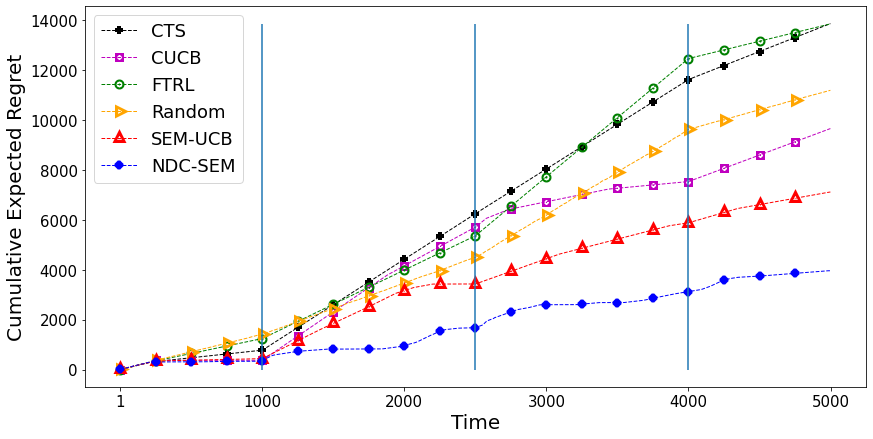

In [66]:
Y1 = aaaa[0:rounds]
Y2 = cccc[0:rounds]
Y3 = dddd[0:rounds]
Y4 = eeee[0:rounds]
Y5 = ffff[0:rounds]
Y6 = bbbb[0:rounds]

###################### saving the final results in a csv file ################
# expected_average_regret_saving=np.zeros((6, Y1.shape[0]))
# expected_average_regret_saving[0,:]=Y1
# expected_average_regret_saving[1,:]=Y2
# expected_average_regret_saving[2,:]=Y3
# expected_average_regret_saving[3,:]=Y4
# expected_average_regret_saving[4,:]=Y5
# expected_average_regret_saving[5,:]=Y6
# np.savetxt(f"cumulative_expected_regret_saving_d_{Delay}.csv", expected_average_regret_saving, delimiter=",")

###############################################################################

fig = plt.figure(figsize=[14, 7])

plt.plot(np.arange(rounds),np.transpose(Y5),'--',color = 'k', linewidth=1, marker = '+', mew = '8', ms='4', markevery=250,label='CTS');
plt.plot(np.arange(rounds),np.transpose(Y3),'--',color = 'm', linewidth=1, marker = 's', mew = '8', ms='1', markevery=250,label='CUCB');
plt.plot(np.arange(rounds),np.transpose(Y2),'--',color = 'g', linewidth=1, marker = '.', mew = '8', ms='4', markevery=250,label='FTRL');
plt.plot(np.arange(rounds),np.transpose(Y4),'--',color = 'orange', linewidth=1, marker = '>', mew = '8', ms='1', markevery=250,label='Random');
plt.plot(np.arange(rounds),np.transpose(Y6),'--',color = 'r', linewidth=1, marker = '^', mew = '8', ms='1', markevery=250,label='SEM-UCB');
plt.plot(np.arange(rounds),np.transpose(Y1),'--',color = 'b', linewidth=1, marker = 'x', mew = '8', ms='4', markevery=250,label='NDC-SEM');



max_y = 0
for array in [Y1, Y2, Y3, Y5]:
    if np.max(array) > max_y:
        max_y = np.max(array)

plt.vlines(change_points[1:], ymin=0, ymax=max_y)

#plt.legend();
#axis_font = {'fontname':'Arial', 'size':'19'}
plt.xlabel('Time', fontsize=20)
plt.xticks([1] + list(plt.xticks()[0][2:-1]), fontsize=15)

plt.ylabel("Cumulative Expected Regret",fontsize=20)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 18});
plt.show;
fig.savefig(f"cumulative_expected_regret_d_{Delay}.jpg", format = 'jpg', dpi = 300)




### Cumulative instantaneous regret

In [67]:
aaaa = np.cumsum(inst_regret_df['NDC-SEM'])
bbbb = np.cumsum(inst_regret_df['SEM-UCB'])
cccc = np.cumsum(inst_regret_df['FTRL'])
dddd = np.cumsum(inst_regret_df['CUCB'])
eeee = np.cumsum(inst_regret_df['Random'])
ffff = np.cumsum(inst_regret_df['CTS'])


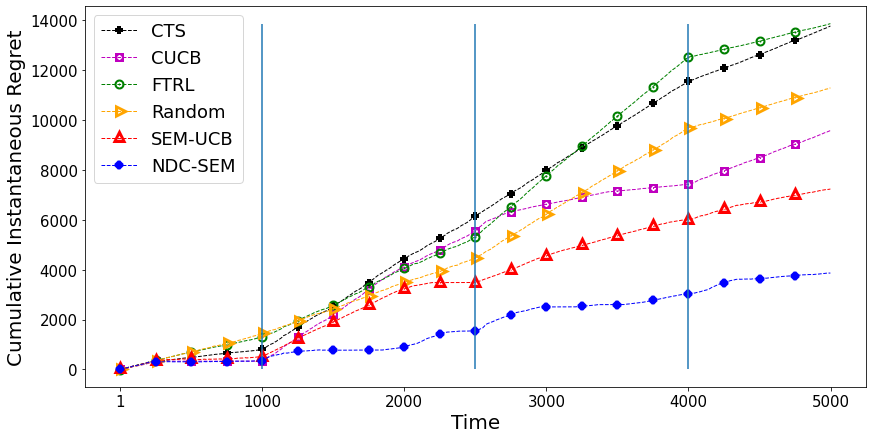

In [68]:
Y1 = aaaa[0:rounds]
Y2 = cccc[0:rounds]
Y3 = dddd[0:rounds]
Y4 = eeee[0:rounds]
Y5 = ffff[0:rounds]
Y6 = bbbb[0:rounds]

fig = plt.figure(figsize=[14, 7])

plt.plot(np.arange(rounds),np.transpose(Y5),'--',color = 'k', linewidth=1, marker = '+', mew = '8', ms='4', markevery=250,label='CTS');
plt.plot(np.arange(rounds),np.transpose(Y3),'--',color = 'm', linewidth=1, marker = 's', mew = '8', ms='1', markevery=250,label='CUCB');
plt.plot(np.arange(rounds),np.transpose(Y2),'--',color = 'g', linewidth=1, marker = '.', mew = '8', ms='4', markevery=250,label='FTRL');
plt.plot(np.arange(rounds),np.transpose(Y4),'--',color = 'orange', linewidth=1, marker = '>', mew = '8', ms='1', markevery=250,label='Random');
plt.plot(np.arange(rounds),np.transpose(Y6),'--',color = 'r', linewidth=1, marker = '^', mew = '8', ms='1', markevery=250,label='SEM-UCB');
plt.plot(np.arange(rounds),np.transpose(Y1),'--',color = 'b', linewidth=1, marker = 'x', mew = '8', ms='4', markevery=250,label='NDC-SEM');



max_y = 0
for array in [Y1, Y2, Y3, Y5]:
    if np.max(array) > max_y:
        max_y = np.max(array)

plt.vlines(change_points[1:], ymin=0, ymax=max_y)

#plt.legend();
#axis_font = {'fontname':'Arial', 'size':'19'}
plt.xlabel('Time', fontsize=20)
plt.xticks([1] + list(plt.xticks()[0][2:-1]), fontsize=15)

plt.ylabel("Cumulative Instantaneous Regret",fontsize=20)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 18});
plt.show;
fig.savefig(f"cumulative_instantaneous_regret_d_{Delay}.jpg", format = 'jpg', dpi = 300)




### Chosen arms oracle comparison

In [69]:
def oracle_superarms_ratios(actions_by_alg, best_actions_for_interval, intervals):
    """For each interval return how many (relative to oracle) chosen superarms were optimal."""
    assert actions_by_alg.shape[0] == nodes
    time_horizon = actions_by_alg.shape[1]
    
    ratios = np.zeros(len(intervals))
    
    for interval_ind, interval in enumerate(intervals):
        best_action = best_actions_for_interval[interval_ind]
        interval_length = interval[1] - interval[0]
        for t in range(interval[0], interval[1]):
            alg_action = actions_by_alg[:, t]
            
            ratios[interval_ind] += int(np.all(alg_action == best_action[:, 0]))
        
        ratios[interval_ind] /= interval_length
    
    return ratios

In [70]:
def oracle_base_arms_ratios(actions_by_alg, best_actions_for_interval, intervals):
    """For each interval return how many (relative to oracle) chosen base were optimal."""
    assert actions_by_alg.shape[0] == nodes
    time_horizon = actions_by_alg.shape[1]
    
    ratios = np.zeros(len(intervals))
    
    for interval_ind, interval in enumerate(intervals):
        best_action = best_actions_for_interval[interval_ind]
        interval_length = interval[1] - interval[0]
        for t in range(interval[0], interval[1]):
            alg_action = actions_by_alg[:, t]
            
            ratios[interval_ind] += np.count_nonzero(alg_action == best_action[:, 0])
        
        ratios[interval_ind] /= interval_length * nodes
    
    return ratios

In [71]:
all_change_points = change_points + [rounds]

In [72]:
intervals = list(zip(all_change_points, all_change_points[1:]))

In [73]:
intervals

[(0, 1000), (1000, 2500), (2500, 4000), (4000, 5000)]

#### Set which algorithms to plot

In [74]:
labels = ['NDC-SEM', 'SEM-UCB', 'FTRL']

In [75]:
all_algorithm_actions_to_plot = [
    all_algorithm_actions[label] for label in labels
]

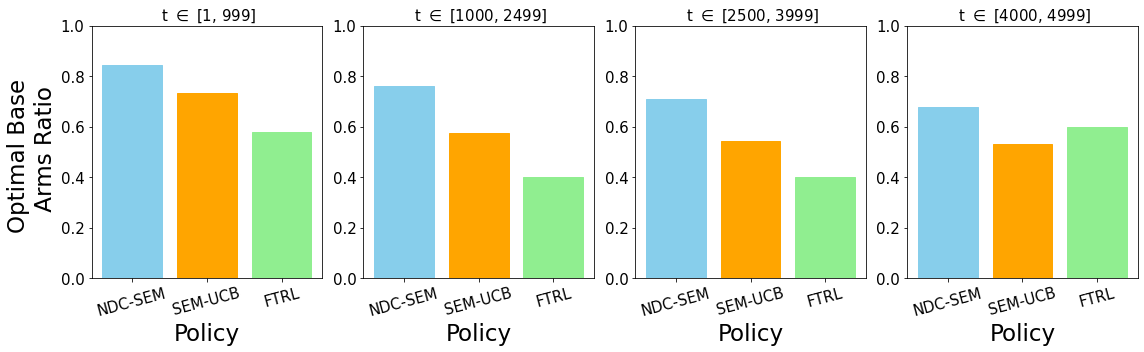

In [76]:
fig, axs = plt.subplots(1, len(intervals), figsize=(16, 5))

alg_in_interval_raio = np.zeros((len(labels), len(intervals)))
for i, alg_action in enumerate(all_algorithm_actions_to_plot):
    alg_in_interval_raio[i, :] = oracle_base_arms_ratios(alg_action, best_action_choice, intervals)

for j, interval in enumerate(intervals):
    ax = axs[j]
    
    barlist = ax.bar(labels, alg_in_interval_raio[:, j])
    
    ax.set_title(fr" t $\in$ [{interval[0] or 1}, {interval[1]-1}]", fontsize=15)
    
    if j == 0:
        ax.set_ylabel('Optimal Base \n Arms Ratio', fontsize=23)
    ax.set_xlabel('Policy', fontsize=23)
#     ax.set_xticklabels(labels, rotation=20, fontsize=14)
    
    plt.setp(ax.xaxis.get_majorticklabels(), fontsize=15, rotation=15)
    plt.setp(ax.yaxis.get_majorticklabels(), fontsize=15)
    ax.set_ylim(0, 1)
    
    barlist[0].set_color('skyblue')
    barlist[1].set_color('orange')
    barlist[2].set_color('lightgreen')

    

plt.tight_layout()
fig.savefig(f"optimal_base_arms_d_{Delay}.jpg", format = 'jpg', dpi = 300)

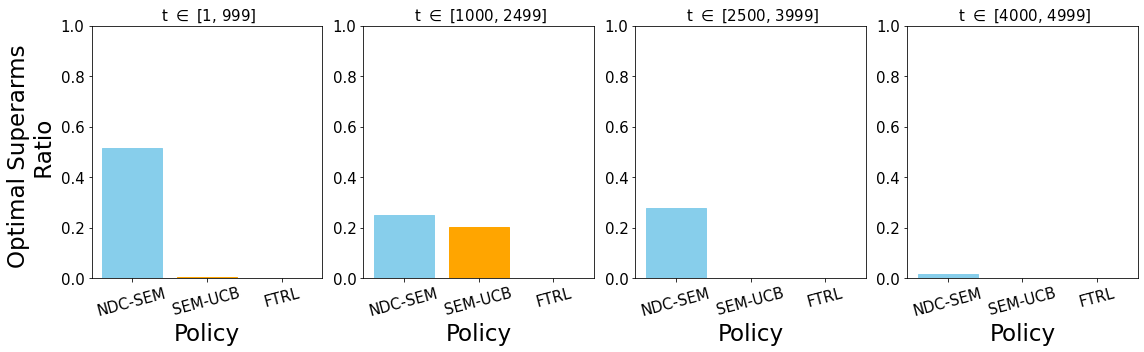

In [77]:
fig, axs = plt.subplots(1, len(intervals), figsize=(16, 5))

alg_in_interval_raio = np.zeros((len(labels), len(intervals)))
for i, alg_action in enumerate(all_algorithm_actions_to_plot):
    alg_in_interval_raio[i, :] = oracle_superarms_ratios(alg_action, best_action_choice, intervals)

for j, interval in enumerate(intervals):
    ax = axs[j]
    
    barlist = ax.bar(labels, alg_in_interval_raio[:, j])
    
    ax.set_title(fr" t $\in$ [{interval[0] or 1}, {interval[1]-1}]", fontsize=15)
    
    if j == 0:
        ax.set_ylabel('Optimal Superarms \n Ratio', fontsize=23)
    ax.set_xlabel('Policy', fontsize=23)
#     ax.set_xticklabels(labels, rotation=20, fontsize=14)
    
    plt.setp(ax.xaxis.get_majorticklabels(), fontsize=15, rotation=15)
    plt.setp(ax.yaxis.get_majorticklabels(), fontsize=15)
    ax.set_ylim(0, 1)
    
    barlist[0].set_color('skyblue')
    barlist[1].set_color('orange')
    barlist[2].set_color('lightgreen')

    

plt.tight_layout()
fig.savefig(f"optimal_superarms_d_{Delay}.jpg", format = 'jpg', dpi = 300)

In [78]:
print(f"Experiment took {time() - start_ts} s")

Experiment took 1241.053232908249 s


In [79]:
np.sum(expected_regret)

3953.7707716342466

In [80]:
# regret was 2077.234966358013